# Standard modules

In [1]:
import sys
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('dark_background')
import pandas as pd
import numpy as np
from time import time
pd.options.display.max_colwidth = 1000
from joblib import Parallel, delayed
import tracemalloc
import psutil
from sklearn import show_versions
show_versions()


System:
    python: 3.9.13 | packaged by conda-forge | (main, May 27 2022, 16:56:21)  [GCC 10.3.0]
executable: /home/mauricio/miniconda3/envs/dev/bin/python
   machine: Linux-5.15.0-53-generic-x86_64-with-glibc2.35

Python dependencies:
      sklearn: 1.1.3
          pip: 22.3.1
   setuptools: 65.5.1
        numpy: 1.23.4
        scipy: 1.9.3
       Cython: None
       pandas: 1.5.1
   matplotlib: 3.6.2
       joblib: 1.2.0
threadpoolctl: 3.1.0

Built with OpenMP: True

threadpoolctl info:
       user_api: blas
   internal_api: mkl
         prefix: libmkl_rt
       filepath: /home/mauricio/miniconda3/envs/dev/lib/libmkl_rt.so.2
        version: 2022.1-Product
threading_layer: intel
    num_threads: 8

       user_api: openmp
   internal_api: openmp
         prefix: libomp
       filepath: /home/mauricio/miniconda3/envs/dev/lib/libomp.so
        version: None
    num_threads: 16


In [2]:
np.show_config()

blas_info:
    libraries = ['cblas', 'blas', 'cblas', 'blas']
    library_dirs = ['/home/mauricio/miniconda3/envs/dev/lib']
    include_dirs = ['/home/mauricio/miniconda3/envs/dev/include']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
blas_opt_info:
    define_macros = [('NO_ATLAS_INFO', 1), ('HAVE_CBLAS', None)]
    libraries = ['cblas', 'blas', 'cblas', 'blas']
    library_dirs = ['/home/mauricio/miniconda3/envs/dev/lib']
    include_dirs = ['/home/mauricio/miniconda3/envs/dev/include']
    language = c
lapack_info:
    libraries = ['lapack', 'blas', 'lapack', 'blas']
    library_dirs = ['/home/mauricio/miniconda3/envs/dev/lib']
    language = f77
lapack_opt_info:
    libraries = ['lapack', 'blas', 'lapack', 'blas', 'cblas', 'blas', 'cblas', 'blas']
    library_dirs = ['/home/mauricio/miniconda3/envs/dev/lib']
    language = c
    define_macros = [('NO_ATLAS_INFO', 1), ('HAVE_CBLAS', None)]
    include_dirs = ['/home/mauricio/miniconda3/envs/dev/include']
Supported SIM

In [3]:
from scipy import show_config
show_config()

lapack_mkl_info:
  NOT AVAILABLE
openblas_lapack_info:
  NOT AVAILABLE
openblas_clapack_info:
  NOT AVAILABLE
flame_info:
  NOT AVAILABLE
atlas_3_10_threads_info:
  NOT AVAILABLE
atlas_3_10_info:
  NOT AVAILABLE
atlas_threads_info:
  NOT AVAILABLE
atlas_info:
  NOT AVAILABLE
lapack_info:
    libraries = ['lapack', 'blas', 'lapack', 'blas']
    library_dirs = ['/home/mauricio/miniconda3/envs/dev/lib']
    language = f77
blas_mkl_info:
  NOT AVAILABLE
blis_info:
  NOT AVAILABLE
openblas_info:
  NOT AVAILABLE
atlas_3_10_blas_threads_info:
  NOT AVAILABLE
atlas_3_10_blas_info:
  NOT AVAILABLE
atlas_blas_threads_info:
  NOT AVAILABLE
atlas_blas_info:
  NOT AVAILABLE
blas_info:
    libraries = ['cblas', 'blas', 'cblas', 'blas']
    library_dirs = ['/home/mauricio/miniconda3/envs/dev/lib']
    include_dirs = ['/home/mauricio/miniconda3/envs/dev/include']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
blas_opt_info:
    define_macros = [('NO_ATLAS_INFO', 1), ('HAVE_CBLAS', None)]


# Custom modules

In [4]:
sys.path.insert(1, '/home/mauricio/code/mcr')
from mcr.ml import fit_cache
from mcr.util import to_csv_to_zip, size

# Data

In [5]:
df = pd.read_csv('/data/drivendata/TrainingData.csv', index_col=0)
# sample to avoid bias in downstream cross-validation train-test split
df = df.sample(frac=1, random_state=1)
LABELS = ['Function', 'Object_Type', 'Operating_Status', 'Position_Type', 'Pre_K', 'Reporting', 'Sharing', 'Student_Type', 'Use']
df[LABELS] = df[LABELS].apply(lambda x: x.astype('category'), axis=0)
dummy_labels = pd.get_dummies(df[LABELS], prefix_sep='__')
NUMERIC_FEATURES=['FTE', 'Total']
TEXT_FEATURES = ['Object_Description', 'Sub_Object_Description', 'Function_Description', 'Fund_Description',
                 'SubFund_Description', 'Program_Description', 'Location_Description', 'Facility_or_Department',
                 'Job_Title_Description', 'Position_Extra', 'Text_1', 'Text_2', 'Text_3', 'Text_4']
FEATURES = TEXT_FEATURES + NUMERIC_FEATURES
holdout = pd.read_csv('/data/drivendata/TestData.csv', index_col=0, low_memory=False)

# Metrics

Multi-class multi-label log loss

In [6]:
from mcr.ml.metrics.log_loss import multi_multi_log_loss
from mcr.ml import get_dummies_indices
cci = get_dummies_indices(df[LABELS])
print(cci)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36], [37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47], [48, 49, 50], [51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75], [76, 77, 78], [79, 80, 81], [82, 83, 84, 85, 86], [87, 88, 89, 90, 91, 92, 93, 94, 95], [96, 97, 98, 99, 100, 101, 102, 103]]


# Numeric feature transformers

In [7]:
from sklearn.preprocessing import FunctionTransformer

## Numeric selector

In [8]:
def select_dtype_number(df, cols=NUMERIC_FEATURES):
    return df.select_dtypes('number') if cols is None else df[cols]
get_numeric_data = FunctionTransformer(select_dtype_number, validate=False)
get_numeric_data.fit_transform(df)

,FTE,Total
129752,NaN,1383.380000
127683,1.000027,63621.571388
265931,NaN,-1000.210000
238935,0.262392,33965.431676
253483,-0.016304,-712.462722
...,...,...
393068,NaN,239.240000
359409,NaN,-1138.460000
334609,NaN,758.130000
326288,NaN,-16.960000


## Disambiguate

The 2 numeric features are disambiguated, resulting 3 features.

In [9]:
from mcr.ml.preprocessing import disambiguate
disambiguate_transformer = FunctionTransformer(disambiguate, validate=False,
                                               kw_args = {'reference':'FTE', 'ambiguous':'Total', 'downcast':False, 'sparse':False})
disambiguate_transformer.fit_transform(df)

,FTE,Total,Total_FTE
129752,NaN,1383.38,NaN
127683,1.000027,NaN,63621.571388
265931,NaN,-1000.21,NaN
238935,0.262392,NaN,33965.431676
253483,-0.016304,NaN,-712.462722
...,...,...,...
393068,NaN,239.24,NaN
359409,NaN,-1138.46,NaN
334609,NaN,758.13,NaN
326288,NaN,-16.96,NaN


## Missing Indicator

In [10]:
from sklearn.impute import MissingIndicator
MissingIndicator().fit_transform(get_numeric_data.fit_transform(df))

array([[ True, False],
       [False, False],
       [ True, False],
       ...,
       [ True, False],
       [ True, False],
       [ True, False]])

## Simple Imputer

In [11]:
from sklearn.impute import SimpleImputer
SimpleImputer(strategy='constant', fill_value=0, add_indicator=False).fit_transform(get_numeric_data.fit_transform(df))

array([[ 0.00000000e+00,  1.38338000e+03],
       [ 1.00002697e+00,  6.36215714e+04],
       [ 0.00000000e+00, -1.00021000e+03],
       ...,
       [ 0.00000000e+00,  7.58130000e+02],
       [ 0.00000000e+00, -1.69600000e+01],
       [ 0.00000000e+00,  1.65600000e+01]])

## Sign indicator

In [12]:
from mcr.ml.preprocessing import sign_indicator
sign_indicator_transformer = FunctionTransformer(sign_indicator, validate=False,
                                               kw_args = {'missing_indicator':False})
sign_indicator_transformer.fit_transform(get_numeric_data.fit_transform(df))

,FTE_negative,FTE_zero,FTE_positive,Total_negative,Total_zero,Total_positive
129752,False,False,False,False,False,True
127683,False,False,True,False,False,True
265931,False,False,False,True,False,False
238935,False,False,True,False,False,True
253483,True,False,False,True,False,False
...,...,...,...,...,...,...
393068,False,False,False,False,False,True
359409,False,False,False,True,False,False
334609,False,False,False,False,False,True
326288,False,False,False,True,False,False


## K-bins discretizer

Refuses missing data

### Uniform strategy

In [13]:
from sklearn.preprocessing import KBinsDiscretizer
kbins_discretized_features = KBinsDiscretizer(n_bins=5, encode='onehot', strategy='uniform', subsample=None).fit_transform(
    SimpleImputer(strategy='constant', fill_value=0, add_indicator=False).fit_transform(
        get_numeric_data.fit_transform(df)
    )
)
display(kbins_discretized_features)
pd.DataFrame(data=kbins_discretized_features.toarray())

<400277x10 sparse matrix of type '<class 'numpy.float64'>'
	with 800554 stored elements in Compressed Sparse Row format>

,0,1,2,3,4,5,6,7,8,9
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
400272,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
400273,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
400274,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
400275,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Quantile strategy

In [14]:
from sklearn.preprocessing import KBinsDiscretizer
kbins_discretized_features = KBinsDiscretizer(n_bins=[2,5], encode='onehot', strategy='quantile', subsample=None).fit_transform(
    SimpleImputer(strategy='constant', fill_value=0, add_indicator=False).fit_transform(
        get_numeric_data.fit_transform(df)
    )
)
display(kbins_discretized_features)
pd.DataFrame(data=kbins_discretized_features.toarray())

<400277x7 sparse matrix of type '<class 'numpy.float64'>'
	with 800554 stored elements in Compressed Sparse Row format>

,0,1,2,3,4,5,6
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
400272,0.0,1.0,0.0,0.0,1.0,0.0,0.0
400273,0.0,1.0,1.0,0.0,0.0,0.0,0.0
400274,0.0,1.0,0.0,0.0,1.0,0.0,0.0
400275,0.0,1.0,1.0,0.0,0.0,0.0,0.0


### K-means strategy

In [15]:
from sklearn.preprocessing import KBinsDiscretizer
kbins_discretized_features = KBinsDiscretizer(n_bins=5, encode='onehot', strategy='kmeans', subsample=None).fit_transform(
    SimpleImputer(strategy='constant', fill_value=0, add_indicator=False).fit_transform(
        get_numeric_data.fit_transform(df)
    )
)
display(kbins_discretized_features)
pd.DataFrame(data=kbins_discretized_features.toarray())

<400277x10 sparse matrix of type '<class 'numpy.float64'>'
	with 800554 stored elements in Compressed Sparse Row format>

,0,1,2,3,4,5,6,7,8,9
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
400272,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
400273,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
400274,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
400275,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


# Numeric pipelines

In [16]:
from sklearn.pipeline import Pipeline, FeatureUnion, FunctionTransformer
from sklearn.base import clone

## Numeric imputer

In [17]:
numeric_impute_pl = Pipeline([
    ('numeric_selector', get_numeric_data),
    ('imputer', SimpleImputer(strategy='constant', fill_value=0, add_indicator=False))
], verbose=False)
display(numeric_impute_pl)
pd.DataFrame(numeric_impute_pl.fit_transform(df))

Pipeline(steps=[('numeric_selector',
                 FunctionTransformer(func=<function select_dtype_number at 0x7fd9bea6c5e0>)),
                ('imputer', SimpleImputer(fill_value=0, strategy='constant'))])

,0,1
0,0.000000,1383.380000
1,1.000027,63621.571388
2,0.000000,-1000.210000
3,0.262392,33965.431676
4,-0.016304,-712.462722
...,...,...
400272,0.000000,239.240000
400273,0.000000,-1138.460000
400274,0.000000,758.130000
400275,0.000000,-16.960000


## Numeric, imputer and missing

In [18]:
numeric_impute_missing_pl = Pipeline([
    ('numeric_selector', get_numeric_data),
    ('imputer', SimpleImputer(strategy='constant', fill_value=0, add_indicator=True))
], verbose=False)
display(numeric_impute_missing_pl)
pd.DataFrame(numeric_impute_missing_pl.fit_transform(df))

Pipeline(steps=[('numeric_selector',
                 FunctionTransformer(func=<function select_dtype_number at 0x7fd9bea6c5e0>)),
                ('imputer',
                 SimpleImputer(add_indicator=True, fill_value=0,
                               strategy='constant'))])

,0,1,2,3
0,0.000000,1383.380000,1.0,0.0
1,1.000027,63621.571388,0.0,0.0
2,0.000000,-1000.210000,1.0,0.0
3,0.262392,33965.431676,0.0,0.0
4,-0.016304,-712.462722,0.0,0.0
...,...,...,...,...
400272,0.000000,239.240000,1.0,0.0
400273,0.000000,-1138.460000,1.0,0.0
400274,0.000000,758.130000,1.0,0.0
400275,0.000000,-16.960000,1.0,0.0


## Numeric, imputer, discretizer

### Uniform exclusive

In [19]:
numeric_impute_discrete_uniform_exclusive_pl = Pipeline([
    ('numeric_selector', get_numeric_data),
    ('imputer', SimpleImputer(strategy='constant', fill_value=0, add_indicator=False)),
    ('imputed_discretizer', KBinsDiscretizer(n_bins=5, encode='onehot', strategy='uniform', subsample=None))
], verbose=False)
display(numeric_impute_discrete_uniform_exclusive_pl)
pd.DataFrame(numeric_impute_discrete_uniform_exclusive_pl.fit_transform(df).toarray())

Pipeline(steps=[('numeric_selector',
                 FunctionTransformer(func=<function select_dtype_number at 0x7fd9bea6c5e0>)),
                ('imputer', SimpleImputer(fill_value=0, strategy='constant')),
                ('imputed_discretizer',
                 KBinsDiscretizer(strategy='uniform', subsample=None))])

,0,1,2,3,4,5,6,7,8,9
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
400272,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
400273,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
400274,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
400275,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Quantile exclusive

In [20]:
numeric_impute_discrete_quantile_exclusive_pl = Pipeline([
    ('numeric_selector', get_numeric_data),
    ('imputer', SimpleImputer(strategy='constant', fill_value=0, add_indicator=False)),
    ('imputed_discretizer', KBinsDiscretizer(n_bins=[2,5], encode='onehot', strategy='quantile', subsample=None))
], verbose=False)
display(numeric_impute_discrete_quantile_exclusive_pl)
pd.DataFrame(numeric_impute_discrete_quantile_exclusive_pl.fit_transform(df).toarray())

Pipeline(steps=[('numeric_selector',
                 FunctionTransformer(func=<function select_dtype_number at 0x7fd9bea6c5e0>)),
                ('imputer', SimpleImputer(fill_value=0, strategy='constant')),
                ('imputed_discretizer',
                 KBinsDiscretizer(n_bins=[2, 5], subsample=None))])

,0,1,2,3,4,5,6
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
400272,0.0,1.0,0.0,0.0,1.0,0.0,0.0
400273,0.0,1.0,1.0,0.0,0.0,0.0,0.0
400274,0.0,1.0,0.0,0.0,1.0,0.0,0.0
400275,0.0,1.0,1.0,0.0,0.0,0.0,0.0


### K-means exclusive

In [21]:
numeric_impute_discrete_kmeans_exclusive_pl = Pipeline([
    ('numeric_selector', get_numeric_data),
    ('imputer', SimpleImputer(strategy='constant', fill_value=0, add_indicator=False)),
    ('imputed_discretizer', KBinsDiscretizer(n_bins=5, encode='onehot', strategy='kmeans', subsample=None))
], verbose=False)
display(numeric_impute_discrete_kmeans_exclusive_pl)
pd.DataFrame(numeric_impute_discrete_kmeans_exclusive_pl.fit_transform(df).toarray())

Pipeline(steps=[('numeric_selector',
                 FunctionTransformer(func=<function select_dtype_number at 0x7fd9bea6c5e0>)),
                ('imputer', SimpleImputer(fill_value=0, strategy='constant')),
                ('imputed_discretizer',
                 KBinsDiscretizer(strategy='kmeans', subsample=None))])

,0,1,2,3,4,5,6,7,8,9
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
400272,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
400273,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
400274,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
400275,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Uniform inclusive

In [22]:
numeric_impute_discrete_uniform_inclusive_pl = Pipeline([
    ('numeric_selector', get_numeric_data),
    ('union', FeatureUnion([
        ('imputer', SimpleImputer(strategy='constant', fill_value=0, add_indicator=False)),
        ('discretizer', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value=0, add_indicator=False)),
            ('imputed_discretizer', KBinsDiscretizer(n_bins=5, encode='onehot', strategy='uniform', subsample=None))
        ], verbose=False)),
    ], verbose=False, n_jobs=None))
], verbose=False)
display(numeric_impute_discrete_uniform_inclusive_pl)
pd.DataFrame(numeric_impute_discrete_uniform_inclusive_pl.fit_transform(df).toarray())

Pipeline(steps=[('numeric_selector',
                 FunctionTransformer(func=<function select_dtype_number at 0x7fd9bea6c5e0>)),
                ('union',
                 FeatureUnion(transformer_list=[('imputer',
                                                 SimpleImputer(fill_value=0,
                                                               strategy='constant')),
                                                ('discretizer',
                                                 Pipeline(steps=[('imputer',
                                                                  SimpleImputer(fill_value=0,
                                                                                strategy='constant')),
                                                                 ('imputed_discretizer',
                                                                  KBinsDiscretizer(strategy='uniform',
                                                                                   subsample=None))]))]))])

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.000000,1383.380000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.000027,63621.571388,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.000000,-1000.210000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.262392,33965.431676,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.016304,-712.462722,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
400272,0.000000,239.240000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
400273,0.000000,-1138.460000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
400274,0.000000,758.130000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
400275,0.000000,-16.960000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Quantile inclusive

In [23]:
numeric_impute_discrete_quantile_inclusive_pl = Pipeline([
    ('numeric_selector', get_numeric_data),
    ('union', FeatureUnion([
        ('imputer', SimpleImputer(strategy='constant', fill_value=0, add_indicator=False)),
        ('discretizer', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value=0, add_indicator=False)),
            ('imputed_discretizer', KBinsDiscretizer(n_bins=[2,5], encode='onehot', strategy='quantile', subsample=None))
        ], verbose=False)),
    ], verbose=False, n_jobs=None))
], verbose=False)
display(numeric_impute_discrete_quantile_inclusive_pl)
pd.DataFrame(numeric_impute_discrete_quantile_inclusive_pl.fit_transform(df).toarray())

Pipeline(steps=[('numeric_selector',
                 FunctionTransformer(func=<function select_dtype_number at 0x7fd9bea6c5e0>)),
                ('union',
                 FeatureUnion(transformer_list=[('imputer',
                                                 SimpleImputer(fill_value=0,
                                                               strategy='constant')),
                                                ('discretizer',
                                                 Pipeline(steps=[('imputer',
                                                                  SimpleImputer(fill_value=0,
                                                                                strategy='constant')),
                                                                 ('imputed_discretizer',
                                                                  KBinsDiscretizer(n_bins=[2,
                                                                                           5],
                                                                                   subsample=None))]))]))])

,0,1,2,3,4,5,6,7,8
0,0.000000,1383.380000,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,1.000027,63621.571388,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.000000,-1000.210000,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,0.262392,33965.431676,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,-0.016304,-712.462722,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
400272,0.000000,239.240000,0.0,1.0,0.0,0.0,1.0,0.0,0.0
400273,0.000000,-1138.460000,0.0,1.0,1.0,0.0,0.0,0.0,0.0
400274,0.000000,758.130000,0.0,1.0,0.0,0.0,1.0,0.0,0.0
400275,0.000000,-16.960000,0.0,1.0,1.0,0.0,0.0,0.0,0.0


### K-means inclusive

In [24]:
numeric_impute_discrete_kmeans_inclusive_pl = Pipeline([
    ('numeric_selector', get_numeric_data),
    ('union', FeatureUnion([
        ('imputer', SimpleImputer(strategy='constant', fill_value=0, add_indicator=False)),
        ('discretizer', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value=0, add_indicator=False)),
            ('imputed_discretizer', KBinsDiscretizer(n_bins=5, encode='onehot', strategy='kmeans', subsample=None))
        ], verbose=False)),
    ], verbose=False, n_jobs=None))
], verbose=False)
display(numeric_impute_discrete_kmeans_inclusive_pl)
pd.DataFrame(numeric_impute_discrete_kmeans_inclusive_pl.fit_transform(df).toarray())

Pipeline(steps=[('numeric_selector',
                 FunctionTransformer(func=<function select_dtype_number at 0x7fd9bea6c5e0>)),
                ('union',
                 FeatureUnion(transformer_list=[('imputer',
                                                 SimpleImputer(fill_value=0,
                                                               strategy='constant')),
                                                ('discretizer',
                                                 Pipeline(steps=[('imputer',
                                                                  SimpleImputer(fill_value=0,
                                                                                strategy='constant')),
                                                                 ('imputed_discretizer',
                                                                  KBinsDiscretizer(strategy='kmeans',
                                                                                   subsample=None))]))]))])

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.000000,1383.380000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.000027,63621.571388,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.000000,-1000.210000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.262392,33965.431676,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.016304,-712.462722,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
400272,0.000000,239.240000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
400273,0.000000,-1138.460000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
400274,0.000000,758.130000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
400275,0.000000,-16.960000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Numeric, imputer, missing, discretizer

### Uniform exclusive

In [25]:
numeric_impute_missing_discrete_uniform_exclusive_pl = Pipeline([
    ('numeric_selector', get_numeric_data),
    ('union', FeatureUnion([
        ('missing_indicator', MissingIndicator()),
        ('discretizer', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value=0, add_indicator=False)),
            ('imputed_discretizer', KBinsDiscretizer(n_bins=5, encode='onehot', strategy='uniform', subsample=None))
        ], verbose=False)),
    ], verbose=False, n_jobs=None))
], verbose=False)
display(numeric_impute_missing_discrete_uniform_exclusive_pl)
pd.DataFrame(numeric_impute_missing_discrete_uniform_exclusive_pl.fit_transform(df).toarray())

Pipeline(steps=[('numeric_selector',
                 FunctionTransformer(func=<function select_dtype_number at 0x7fd9bea6c5e0>)),
                ('union',
                 FeatureUnion(transformer_list=[('missing_indicator',
                                                 MissingIndicator()),
                                                ('discretizer',
                                                 Pipeline(steps=[('imputer',
                                                                  SimpleImputer(fill_value=0,
                                                                                strategy='constant')),
                                                                 ('imputed_discretizer',
                                                                  KBinsDiscretizer(strategy='uniform',
                                                                                   subsample=None))]))]))])

,0,1,2,3,4,5,6,7,8,9,10,11
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
400272,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
400273,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
400274,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
400275,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Quantile exclusive

In [26]:
numeric_impute_missing_discrete_quantile_exclusive_pl = Pipeline([
    ('numeric_selector', get_numeric_data),
    ('union', FeatureUnion([
        ('missing_indicator', MissingIndicator()),
        ('discretizer', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value=0, add_indicator=False)),
            ('imputed_discretizer', KBinsDiscretizer(n_bins=[2,5], encode='onehot', strategy='quantile', subsample=None))
        ], verbose=False)),
    ], verbose=False, n_jobs=None))
], verbose=False)
display(numeric_impute_missing_discrete_quantile_exclusive_pl)
pd.DataFrame(numeric_impute_missing_discrete_quantile_exclusive_pl.fit_transform(df).toarray())

Pipeline(steps=[('numeric_selector',
                 FunctionTransformer(func=<function select_dtype_number at 0x7fd9bea6c5e0>)),
                ('union',
                 FeatureUnion(transformer_list=[('missing_indicator',
                                                 MissingIndicator()),
                                                ('discretizer',
                                                 Pipeline(steps=[('imputer',
                                                                  SimpleImputer(fill_value=0,
                                                                                strategy='constant')),
                                                                 ('imputed_discretizer',
                                                                  KBinsDiscretizer(n_bins=[2,
                                                                                           5],
                                                                                   subsample=None))]))]))])

,0,1,2,3,4,5,6,7,8
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
400272,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
400273,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
400274,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
400275,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


### K-means exclusive

In [27]:
numeric_impute_missing_discrete_kmeans_exclusive_pl = Pipeline([
    ('numeric_selector', get_numeric_data),
    ('union', FeatureUnion([
        ('missing_indicator', MissingIndicator(sparse='auto')),
        ('discretizer', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value=0, add_indicator=False)),
            ('imputed_discretizer', KBinsDiscretizer(n_bins=5, encode='onehot', strategy='kmeans', subsample=None))
        ], verbose=False)),
    ], verbose=False, n_jobs=None))
], verbose=False)
display(numeric_impute_missing_discrete_kmeans_exclusive_pl)
pd.DataFrame(numeric_impute_missing_discrete_kmeans_exclusive_pl.fit_transform(df).toarray())

Pipeline(steps=[('numeric_selector',
                 FunctionTransformer(func=<function select_dtype_number at 0x7fd9bea6c5e0>)),
                ('union',
                 FeatureUnion(transformer_list=[('missing_indicator',
                                                 MissingIndicator()),
                                                ('discretizer',
                                                 Pipeline(steps=[('imputer',
                                                                  SimpleImputer(fill_value=0,
                                                                                strategy='constant')),
                                                                 ('imputed_discretizer',
                                                                  KBinsDiscretizer(strategy='kmeans',
                                                                                   subsample=None))]))]))])

,0,1,2,3,4,5,6,7,8,9,10,11
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
400272,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
400273,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
400274,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
400275,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Uniform inclusive

In [28]:
numeric_impute_missing_discrete_uniform_inclusive_pl = Pipeline([
    ('numeric_selector', get_numeric_data),
    ('union', FeatureUnion([
        ('imputer', SimpleImputer(strategy='constant', fill_value=0, add_indicator=True)),
        ('discretizer', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value=0, add_indicator=False)),
            ('imputed_discretizer', KBinsDiscretizer(n_bins=5, encode='onehot', strategy='uniform', subsample=None))
        ], verbose=False)),
    ], verbose=False, n_jobs=None))
], verbose=False)
display(numeric_impute_missing_discrete_uniform_inclusive_pl)
pd.DataFrame(numeric_impute_missing_discrete_uniform_inclusive_pl.fit_transform(df).toarray())

Pipeline(steps=[('numeric_selector',
                 FunctionTransformer(func=<function select_dtype_number at 0x7fd9bea6c5e0>)),
                ('union',
                 FeatureUnion(transformer_list=[('imputer',
                                                 SimpleImputer(add_indicator=True,
                                                               fill_value=0,
                                                               strategy='constant')),
                                                ('discretizer',
                                                 Pipeline(steps=[('imputer',
                                                                  SimpleImputer(fill_value=0,
                                                                                strategy='constant')),
                                                                 ('imputed_discretizer',
                                                                  KBinsDiscretizer(strategy='uniform',
                                                                                   subsample=None))]))]))])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.000000,1383.380000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.000027,63621.571388,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.000000,-1000.210000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.262392,33965.431676,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.016304,-712.462722,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400272,0.000000,239.240000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
400273,0.000000,-1138.460000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
400274,0.000000,758.130000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
400275,0.000000,-16.960000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Quantile inclusive

In [29]:
numeric_impute_missing_discrete_quantile_inclusive_pl = Pipeline([
    ('numeric_selector', get_numeric_data),
    ('union', FeatureUnion([
        ('imputer', SimpleImputer(strategy='constant', fill_value=0, add_indicator=True)),
        ('discretizer', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value=0, add_indicator=False)),
            ('imputed_discretizer', KBinsDiscretizer(n_bins=[2,5], encode='onehot', strategy='quantile', subsample=None))
        ], verbose=False)),
    ], verbose=False, n_jobs=None))
], verbose=False)
display(numeric_impute_missing_discrete_quantile_inclusive_pl)
pd.DataFrame(numeric_impute_missing_discrete_quantile_inclusive_pl.fit_transform(df).toarray())

Pipeline(steps=[('numeric_selector',
                 FunctionTransformer(func=<function select_dtype_number at 0x7fd9bea6c5e0>)),
                ('union',
                 FeatureUnion(transformer_list=[('imputer',
                                                 SimpleImputer(add_indicator=True,
                                                               fill_value=0,
                                                               strategy='constant')),
                                                ('discretizer',
                                                 Pipeline(steps=[('imputer',
                                                                  SimpleImputer(fill_value=0,
                                                                                strategy='constant')),
                                                                 ('imputed_discretizer',
                                                                  KBinsDiscretizer(n_bins=[2,
                                                                                           5],
                                                                                   subsample=None))]))]))])

,0,1,2,3,4,5,6,7,8,9,10
0,0.000000,1383.380000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,1.000027,63621.571388,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.000000,-1000.210000,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,0.262392,33965.431676,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,-0.016304,-712.462722,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
400272,0.000000,239.240000,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
400273,0.000000,-1138.460000,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
400274,0.000000,758.130000,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
400275,0.000000,-16.960000,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


### K-means inclusive

In [30]:
numeric_impute_missing_discrete_kmeans_inclusive_pl = Pipeline([
    ('numeric_selector', get_numeric_data),
    ('union', FeatureUnion([
        ('imputer', SimpleImputer(strategy='constant', fill_value=0, add_indicator=True)),
        ('discretizer', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value=0, add_indicator=False)),
            ('imputed_discretizer', KBinsDiscretizer(n_bins=5, encode='onehot', strategy='kmeans', subsample=None))
        ], verbose=False)),
    ], verbose=False, n_jobs=None))
], verbose=False)
display(numeric_impute_missing_discrete_kmeans_inclusive_pl)
pd.DataFrame(numeric_impute_missing_discrete_kmeans_inclusive_pl.fit_transform(df).toarray())

Pipeline(steps=[('numeric_selector',
                 FunctionTransformer(func=<function select_dtype_number at 0x7fd9bea6c5e0>)),
                ('union',
                 FeatureUnion(transformer_list=[('imputer',
                                                 SimpleImputer(add_indicator=True,
                                                               fill_value=0,
                                                               strategy='constant')),
                                                ('discretizer',
                                                 Pipeline(steps=[('imputer',
                                                                  SimpleImputer(fill_value=0,
                                                                                strategy='constant')),
                                                                 ('imputed_discretizer',
                                                                  KBinsDiscretizer(strategy='kmeans',
                                                                                   subsample=None))]))]))])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.000000,1383.380000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.000027,63621.571388,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.000000,-1000.210000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.262392,33965.431676,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.016304,-712.462722,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400272,0.000000,239.240000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
400273,0.000000,-1138.460000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
400274,0.000000,758.130000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
400275,0.000000,-16.960000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Numeric, imputer, sign indicator

In [31]:
numeric_impute_sign_pl = Pipeline([
    ('numeric_selector', get_numeric_data),
    ('union', FeatureUnion([
        ('imputer', SimpleImputer(strategy='constant', fill_value=0, add_indicator=False)),
        ('sign_indicator', FunctionTransformer(sign_indicator, validate=False, kw_args = {'missing_indicator': False}))
    ], verbose=False, n_jobs=None))
], verbose=False)
display(numeric_impute_sign_pl)
pd.DataFrame(numeric_impute_sign_pl.fit_transform(df))

Pipeline(steps=[('numeric_selector',
                 FunctionTransformer(func=<function select_dtype_number at 0x7fd9bea6c5e0>)),
                ('union',
                 FeatureUnion(transformer_list=[('imputer',
                                                 SimpleImputer(fill_value=0,
                                                               strategy='constant')),
                                                ('sign_indicator',
                                                 FunctionTransformer(func=<function sign_indicator at 0x7fd9beaa0820>,
                                                                     kw_args={'missing_indicator': False}))]))])

,0,1,2,3,4,5,6,7
0,0.000000,1383.380000,0.0,0.0,0.0,0.0,0.0,1.0
1,1.000027,63621.571388,0.0,0.0,1.0,0.0,0.0,1.0
2,0.000000,-1000.210000,0.0,0.0,0.0,1.0,0.0,0.0
3,0.262392,33965.431676,0.0,0.0,1.0,0.0,0.0,1.0
4,-0.016304,-712.462722,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...
400272,0.000000,239.240000,0.0,0.0,0.0,0.0,0.0,1.0
400273,0.000000,-1138.460000,0.0,0.0,0.0,1.0,0.0,0.0
400274,0.000000,758.130000,0.0,0.0,0.0,0.0,0.0,1.0
400275,0.000000,-16.960000,0.0,0.0,0.0,1.0,0.0,0.0


## Numeric, imputer, missing and sign indicator

In [32]:
numeric_impute_missing_sign_pl = Pipeline([
    ('numeric_selector', get_numeric_data),
    ('union', FeatureUnion([
        ('imputer', SimpleImputer(strategy='constant', fill_value=0, add_indicator=True)),
        ('sign_indicator', FunctionTransformer(sign_indicator, validate=False, kw_args = {'missing_indicator': False}))
    ], verbose=False, n_jobs=None))
], verbose=False)
display(numeric_impute_missing_sign_pl)
pd.DataFrame(numeric_impute_missing_sign_pl.fit_transform(df))

Pipeline(steps=[('numeric_selector',
                 FunctionTransformer(func=<function select_dtype_number at 0x7fd9bea6c5e0>)),
                ('union',
                 FeatureUnion(transformer_list=[('imputer',
                                                 SimpleImputer(add_indicator=True,
                                                               fill_value=0,
                                                               strategy='constant')),
                                                ('sign_indicator',
                                                 FunctionTransformer(func=<function sign_indicator at 0x7fd9beaa0820>,
                                                                     kw_args={'missing_indicator': False}))]))])

,0,1,2,3,4,5,6,7,8,9
0,0.000000,1383.380000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.000027,63621.571388,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.000000,-1000.210000,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.262392,33965.431676,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,-0.016304,-712.462722,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
400272,0.000000,239.240000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
400273,0.000000,-1138.460000,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
400274,0.000000,758.130000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
400275,0.000000,-16.960000,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Numeric, imputer, missing indicator, discretizer sign indicator

### Uniform exclusive

In [33]:
numeric_impute_missing_discrete_uniform_exclusive_sign_pl = Pipeline([
    ('numeric_selector', get_numeric_data),
    ('union', FeatureUnion([
        ('missing_indicator', MissingIndicator(sparse='auto')),
        ('discretizer', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value=0, add_indicator=False)),
            ('imputed_discretizer', KBinsDiscretizer(n_bins=5, encode='onehot', strategy='uniform', subsample=None))
        ], verbose=False)),
        ('sign_indicator', FunctionTransformer(sign_indicator, validate=False, kw_args = {'missing_indicator': False})),
    ], verbose=False, n_jobs=None))
], verbose=False)
display(numeric_impute_missing_discrete_uniform_exclusive_sign_pl)
pd.DataFrame(numeric_impute_missing_discrete_uniform_exclusive_sign_pl.fit_transform(df).toarray())

Pipeline(steps=[('numeric_selector',
                 FunctionTransformer(func=<function select_dtype_number at 0x7fd9bea6c5e0>)),
                ('union',
                 FeatureUnion(transformer_list=[('missing_indicator',
                                                 MissingIndicator()),
                                                ('discretizer',
                                                 Pipeline(steps=[('imputer',
                                                                  SimpleImputer(fill_value=0,
                                                                                strategy='constant')),
                                                                 ('imputed_discretizer',
                                                                  KBinsDiscretizer(strategy='uniform',
                                                                                   subsample=None))])),
                                                ('sign_indicator',
                                                 FunctionTransformer(func=<function sign_indicator at 0x7fd9beaa0820>,
                                                                     kw_args={'missing_indicator': False}))]))])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400272,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
400273,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
400274,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
400275,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Quantile exclusive

In [34]:
numeric_impute_missing_discrete_quantile_exclusive_sign_pl = Pipeline([
    ('numeric_selector', get_numeric_data),
    ('union', FeatureUnion([
        ('missing_indicator', MissingIndicator(sparse='auto')),
        ('discretizer', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value=0, add_indicator=False)),
            ('imputed_discretizer', KBinsDiscretizer(n_bins=[2,5], encode='onehot', subsample=None))
        ], verbose=False)),
        ('sign_indicator', FunctionTransformer(sign_indicator, validate=False, kw_args = {'missing_indicator': False}))
    ], verbose=False, n_jobs=None))
], verbose=False)
display(numeric_impute_missing_discrete_quantile_exclusive_sign_pl)
pd.DataFrame(numeric_impute_missing_discrete_quantile_exclusive_sign_pl.fit_transform(df).toarray())

Pipeline(steps=[('numeric_selector',
                 FunctionTransformer(func=<function select_dtype_number at 0x7fd9bea6c5e0>)),
                ('union',
                 FeatureUnion(transformer_list=[('missing_indicator',
                                                 MissingIndicator()),
                                                ('discretizer',
                                                 Pipeline(steps=[('imputer',
                                                                  SimpleImputer(fill_value=0,
                                                                                strategy='constant')),
                                                                 ('imputed_discretizer',
                                                                  KBinsDiscretizer(n_bins=[2,
                                                                                           5],
                                                                                   subsample=None))])),
                                                ('sign_indicator',
                                                 FunctionTransformer(func=<function sign_indicator at 0x7fd9beaa0820>,
                                                                     kw_args={'missing_indicator': False}))]))])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400272,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
400273,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
400274,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
400275,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### K-means exclusive and sign indicator

In [35]:
numeric_impute_missing_discrete_kmeans_exclusive_sign_pl = Pipeline([
    ('numeric_selector', get_numeric_data),
    ('union', FeatureUnion([
        ('missing_indicator', MissingIndicator(sparse='auto')),
        ('discretizer', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value=0, add_indicator=False)),
            ('imputed_discretizer', KBinsDiscretizer(n_bins=5, encode='onehot', strategy='kmeans', subsample=None))
        ], verbose=False)),
        ('sign_indicator', FunctionTransformer(sign_indicator, validate=False, kw_args = {'missing_indicator': False}))
    ], verbose=False, n_jobs=None))
], verbose=False)
display(numeric_impute_missing_discrete_kmeans_exclusive_sign_pl)
pd.DataFrame(numeric_impute_missing_discrete_kmeans_exclusive_sign_pl.fit_transform(df).toarray())

Pipeline(steps=[('numeric_selector',
                 FunctionTransformer(func=<function select_dtype_number at 0x7fd9bea6c5e0>)),
                ('union',
                 FeatureUnion(transformer_list=[('missing_indicator',
                                                 MissingIndicator()),
                                                ('discretizer',
                                                 Pipeline(steps=[('imputer',
                                                                  SimpleImputer(fill_value=0,
                                                                                strategy='constant')),
                                                                 ('imputed_discretizer',
                                                                  KBinsDiscretizer(strategy='kmeans',
                                                                                   subsample=None))])),
                                                ('sign_indicator',
                                                 FunctionTransformer(func=<function sign_indicator at 0x7fd9beaa0820>,
                                                                     kw_args={'missing_indicator': False}))]))])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400272,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
400273,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
400274,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
400275,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Uniform inclusive

In [36]:
numeric_impute_missing_discrete_uniform_inclusive_sign_pl = Pipeline([
    ('numeric_selector', get_numeric_data),
    ('union', FeatureUnion([
        ('imputer', SimpleImputer(strategy='constant', fill_value=0, add_indicator=True)),
        ('discretizer', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value=0, add_indicator=False)),
            ('imputed_discretizer', KBinsDiscretizer(n_bins=5, encode='onehot', strategy='uniform', subsample=None))
        ], verbose=False)),
        ('sign_indicator', FunctionTransformer(sign_indicator, validate=False, kw_args = {'missing_indicator': False}))
    ], verbose=False, n_jobs=None))
], verbose=False)
display(numeric_impute_missing_discrete_uniform_inclusive_sign_pl)
pd.DataFrame(numeric_impute_missing_discrete_uniform_inclusive_sign_pl.fit_transform(df).toarray())

Pipeline(steps=[('numeric_selector',
                 FunctionTransformer(func=<function select_dtype_number at 0x7fd9bea6c5e0>)),
                ('union',
                 FeatureUnion(transformer_list=[('imputer',
                                                 SimpleImputer(add_indicator=True,
                                                               fill_value=0,
                                                               strategy='constant')),
                                                ('discretizer',
                                                 Pipeline(steps=[('imputer',
                                                                  SimpleImputer(fill_value=0,
                                                                                strategy='constant')),
                                                                 ('imputed_discretizer',
                                                                  KBinsDiscretizer(strategy='uniform',
                                                                                   subsample=None))])),
                                                ('sign_indicator',
                                                 FunctionTransformer(func=<function sign_indicator at 0x7fd9beaa0820>,
                                                                     kw_args={'missing_indicator': False}))]))])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.000000,1383.380000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.000027,63621.571388,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.000000,-1000.210000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.262392,33965.431676,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,-0.016304,-712.462722,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400272,0.000000,239.240000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
400273,0.000000,-1138.460000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
400274,0.000000,758.130000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
400275,0.000000,-16.960000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Quantile inclusive

In [37]:
numeric_impute_missing_discrete_quantile_inclusive_sign_pl = Pipeline([
    ('numeric_selector', get_numeric_data),
    ('union', FeatureUnion([
        ('imputer', SimpleImputer(strategy='constant', fill_value=0, add_indicator=True)),
        ('discretizer', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value=0, add_indicator=False)),
            ('imputed_discretizer', KBinsDiscretizer(n_bins=[2,5], encode='onehot', subsample=None))
        ], verbose=False)),
        ('sign_indicator', FunctionTransformer(sign_indicator, validate=False, kw_args = {'missing_indicator': False}))
    ], verbose=False, n_jobs=None))
], verbose=False)
display(numeric_impute_missing_discrete_quantile_inclusive_sign_pl)
pd.DataFrame(numeric_impute_missing_discrete_quantile_inclusive_sign_pl.fit_transform(df).toarray())

Pipeline(steps=[('numeric_selector',
                 FunctionTransformer(func=<function select_dtype_number at 0x7fd9bea6c5e0>)),
                ('union',
                 FeatureUnion(transformer_list=[('imputer',
                                                 SimpleImputer(add_indicator=True,
                                                               fill_value=0,
                                                               strategy='constant')),
                                                ('discretizer',
                                                 Pipeline(steps=[('imputer',
                                                                  SimpleImputer(fill_value=0,
                                                                                strategy='constant')),
                                                                 ('imputed_discretizer',
                                                                  KBinsDiscretizer(n_bins=[2,
                                                                                           5],
                                                                                   subsample=None))])),
                                                ('sign_indicator',
                                                 FunctionTransformer(func=<function sign_indicator at 0x7fd9beaa0820>,
                                                                     kw_args={'missing_indicator': False}))]))])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.000000,1383.380000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.000027,63621.571388,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.000000,-1000.210000,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.262392,33965.431676,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,-0.016304,-712.462722,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400272,0.000000,239.240000,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
400273,0.000000,-1138.460000,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
400274,0.000000,758.130000,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
400275,0.000000,-16.960000,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### K-means inclusive

In [ ]:
numeric_impute_missing_discrete_kmeans_inclusive_sign_pl = Pipeline([
    ('numeric_selector', get_numeric_data),
    ('union', FeatureUnion([
        ('imputer', SimpleImputer(strategy='constant', fill_value=0, add_indicator=True)),
        ('discretizer', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value=0, add_indicator=False)),
            ('imputed_discretizer', KBinsDiscretizer(n_bins=5, encode='onehot', strategy='kmeans', subsample=None))
        ], verbose=False)),
        ('sign_indicator', FunctionTransformer(sign_indicator, validate=False, kw_args = {'missing_indicator': False}))
    ], verbose=False, n_jobs=None))
], verbose=False)
display(numeric_impute_missing_discrete_kmeans_inclusive_sign_pl)
pd.DataFrame(numeric_impute_missing_discrete_kmeans_inclusive_sign_pl.fit_transform(df).toarray())

Pipeline(steps=[('numeric_selector',
                 FunctionTransformer(func=<function select_dtype_number at 0x7fd9bea6c5e0>)),
                ('union',
                 FeatureUnion(transformer_list=[('imputer',
                                                 SimpleImputer(add_indicator=True,
                                                               fill_value=0,
                                                               strategy='constant')),
                                                ('discretizer',
                                                 Pipeline(steps=[('imputer',
                                                                  SimpleImputer(fill_value=0,
                                                                                strategy='constant')),
                                                                 ('imputed_discretizer',
                                                                  KBinsDiscretizer(strategy='kmeans',
                                                                                   subsample=None))])),
                                                ('sign_indicator',
                                                 FunctionTransformer(func=<function sign_indicator at 0x7fd9beaa0820>,
                                                                     kw_args={'missing_indicator': False}))]))])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.000000,1383.380000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.000027,63621.571388,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.000000,-1000.210000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.262392,33965.431676,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,-0.016304,-712.462722,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400272,0.000000,239.240000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
400273,0.000000,-1138.460000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
400274,0.000000,758.130000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
400275,0.000000,-16.960000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Dictionary

In [ ]:
numeric_pipelines = {
'numeric_impute_pl': numeric_impute_pl,
'numeric_impute_missing_pl': numeric_impute_missing_pl,
'numeric_impute_discrete_uniform_exclusive_pl': numeric_impute_discrete_uniform_exclusive_pl,
'numeric_impute_discrete_quantile_exclusive_pl': numeric_impute_discrete_quantile_exclusive_pl,
'numeric_impute_discrete_kmeans_exclusive_pl': numeric_impute_discrete_kmeans_exclusive_pl,
'numeric_impute_discrete_uniform_inclusive_pl': numeric_impute_discrete_uniform_inclusive_pl,
'numeric_impute_discrete_quantile_inclusive_pl': numeric_impute_discrete_quantile_inclusive_pl,
'numeric_impute_discrete_kmeans_inclusive_pl': numeric_impute_discrete_kmeans_inclusive_pl,
'numeric_impute_missing_discrete_uniform_exclusive_pl': numeric_impute_missing_discrete_uniform_exclusive_pl,
'numeric_impute_missing_discrete_quantile_exclusive_pl': numeric_impute_missing_discrete_quantile_exclusive_pl,
'numeric_impute_missing_discrete_kmeans_exclusive_pl': numeric_impute_missing_discrete_kmeans_exclusive_pl,
'numeric_impute_missing_discrete_uniform_inclusive_pl': numeric_impute_missing_discrete_uniform_inclusive_pl,
'numeric_impute_missing_discrete_quantile_inclusive_pl': numeric_impute_missing_discrete_quantile_inclusive_pl,
'numeric_impute_missing_discrete_kmeans_inclusive_pl': numeric_impute_missing_discrete_kmeans_inclusive_pl,
'numeric_impute_sign_pl': numeric_impute_sign_pl,
'numeric_impute_missing_sign_pl': numeric_impute_missing_sign_pl,
'numeric_impute_missing_discrete_uniform_exclusive_sign_pl': numeric_impute_missing_discrete_uniform_exclusive_sign_pl,
'numeric_impute_missing_discrete_quantile_exclusive_sign_pl': numeric_impute_missing_discrete_quantile_exclusive_sign_pl,
'numeric_impute_missing_discrete_kmeans_exclusive_sign_pl': numeric_impute_missing_discrete_kmeans_exclusive_sign_pl,
'numeric_impute_missing_discrete_uniform_inclusive_sign_pl': numeric_impute_missing_discrete_uniform_inclusive_sign_pl,
'numeric_impute_missing_discrete_quantile_inclusive_sign_pl': numeric_impute_missing_discrete_quantile_inclusive_sign_pl,
'numeric_impute_missing_discrete_kmeans_inclusive_sign_pl': numeric_impute_missing_discrete_kmeans_inclusive_sign_pl
}

# Simple model: only numeric features

* Selecting just numeric features: `df[NUMERIC_FEATURES]`
* Selecting labels as binary variables for multi-label targets: `dummy_labels`

In [ ]:
from mcr.ml.model_selection.multilabel import multilabel_train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MaxAbsScaler, Normalizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from mcr.ml.metrics.log_loss import log_loss_report, log_loss_report_complete

In [ ]:
X_train, X_test, y_train, y_test = multilabel_train_test_split(df[NUMERIC_FEATURES], dummy_labels, size=0.2, min_count=0, seed=1)

## Testing different pipelines with different scalers, solvers, max iterations and feature interactions

In [ ]:
# solvers = {'liblinear': {'max_iter': 5000, 'penalty': ['l2',
#                                                        #'l1'
#                                                       ], 'l1_ratio': [None]},
#            # 'lbfgs': {'max_iter':5000, 'penalty': ['l2',
#            #                                        #'none'
#            #                                       ], 'l1_ratio': [None]},
#            # 'newton-cg': {'max_iter':5000, 'penalty': ['l2',
#            #                                            #'none'
#            #                                           ], 'l1_ratio': [None]},
#            # 'saga': {'max_iter':5000, 'penalty': ['l2',
#            #                                       #'l1', 'none'
#            #                                      ], 'l1_ratio': [None]},
#            # 'saga': {'max_iter':5000, 'penalty': ['elasticnet'], 'l1_ratio': [0, 0.5]},
#            # 'sag': {'max_iter':5000, 'penalty': ['l2',
#            #                                      #'none'
#            #                                     ], 'l1_ratio': [None]},           
#           }
# scalers = {#'MaxAbsScaler()': MaxAbsScaler(),
#            'StandardScaler(with_mean=False)': StandardScaler(with_mean=False),
#            # 'Normalizer(norm=\'l2\')': Normalizer(norm='l2'),
#            # 'Normalizer(norm=\'l1\')': Normalizer(norm='l1')
#           }
# interactions = {#'passthrough': 'passthrough',
#                 '2nd degree': PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
#                }

In [ ]:
# for solver, solver_parameter in solvers.items():
#     for scaler_name, scaler in scalers.items():
#         for interaction_name, interaction in interactions.items():
#             for pl_name, pl in numeric_pipelines.items():
#                 for penalty in solver_parameter['penalty']:
#                     for l1_ratio in solver_parameter['l1_ratio']:
#                         print(f'solver:{solver} max_iter:{solver_parameter["max_iter"]} penalty:{penalty} l1_ratio:{l1_ratio} scaler:{scaler_name} pipeline:{pl_name} interaction:{interaction_name}', end=' ')
#                         simple_pl = Pipeline([
#                             ('numeric_features', pl),
#                             ('interactor', interaction),
#                             ('scaler', scaler),
#                             ('classifier', OneVsRestClassifier(
#                                 LogisticRegression(random_state=1, solver=solver, max_iter=solver_parameter['max_iter'], penalty=penalty, l1_ratio=l1_ratio), n_jobs=14)
#                             )
#                         ], verbose=False)
#                         t=time()
#                         simple_pl.fit(X_train, y_train)
#                         print(f'time:{time()-t:.0f}s')
#                         # log_loss_report(simple_pl, X_train, y_train, LABELS, cci, summary=True)
#                         # log_loss_report(simple_pl, X_test, y_test, LABELS, cci, summary=False)
#                         print(f'Testing logloss: {multi_multi_log_loss(y_test, simple_pl.predict_proba(X_test), cci)}')

# # Testing log loss         : 1.1738268006101134                        

```
Last executed at 2022-11-10 05:26:22 in 29m 4.20s

solver:liblinear max_iter:5000 penalty:l2 l1_ratio:None scaler:StandardScaler(with_mean=False) pipeline:numeric_impute_pl interaction:2nd degree time:8.535558938980103s
Testing logloss: 1.3409117212816524
solver:liblinear max_iter:5000 penalty:l2 l1_ratio:None scaler:StandardScaler(with_mean=False) pipeline:numeric_impute_missing_pl interaction:2nd degree time:21.75015687942505s
Testing logloss: 1.2818040993469875
solver:liblinear max_iter:5000 penalty:l2 l1_ratio:None scaler:StandardScaler(with_mean=False) pipeline:numeric_impute_discrete_uniform_exclusive_pl interaction:2nd degree time:7.243819236755371s
Testing logloss: 1.3963026773880851
solver:liblinear max_iter:5000 penalty:l2 l1_ratio:None scaler:StandardScaler(with_mean=False) pipeline:numeric_impute_discrete_quantile_exclusive_pl interaction:2nd degree time:9.0943763256073s
Testing logloss: 1.317944652814841
solver:liblinear max_iter:5000 penalty:l2 l1_ratio:None scaler:StandardScaler(with_mean=False) pipeline:numeric_impute_discrete_kmeans_exclusive_pl interaction:2nd degree time:8.024893760681152s
Testing logloss: 1.3961225494938534
solver:liblinear max_iter:5000 penalty:l2 l1_ratio:None scaler:StandardScaler(with_mean=False) pipeline:numeric_impute_discrete_uniform_inclusive_pl interaction:2nd degree time:25.218493700027466s
Testing logloss: 1.3402032928899419
solver:liblinear max_iter:5000 penalty:l2 l1_ratio:None scaler:StandardScaler(with_mean=False) pipeline:numeric_impute_discrete_quantile_inclusive_pl interaction:2nd degree time:112.91040515899658s
Testing logloss: 1.2423264756680519
solver:liblinear max_iter:5000 penalty:l2 l1_ratio:None scaler:StandardScaler(with_mean=False) pipeline:numeric_impute_discrete_kmeans_inclusive_pl interaction:2nd degree time:33.63878154754639s
Testing logloss: 1.338027231823316
solver:liblinear max_iter:5000 penalty:l2 l1_ratio:None scaler:StandardScaler(with_mean=False) pipeline:numeric_impute_missing_discrete_uniform_exclusive_pl interaction:2nd degree time:11.339397430419922s
Testing logloss: 1.3238200390140862
solver:liblinear max_iter:5000 penalty:l2 l1_ratio:None scaler:StandardScaler(with_mean=False) pipeline:numeric_impute_missing_discrete_quantile_exclusive_pl interaction:2nd degree time:19.68131995201111s
Testing logloss: 1.2358667151171387
solver:liblinear max_iter:5000 penalty:l2 l1_ratio:None scaler:StandardScaler(with_mean=False) pipeline:numeric_impute_missing_discrete_kmeans_exclusive_pl interaction:2nd degree time:12.184011220932007s
Testing logloss: 1.3236850757510923
solver:liblinear max_iter:5000 penalty:l2 l1_ratio:None scaler:StandardScaler(with_mean=False) pipeline:numeric_impute_missing_discrete_uniform_inclusive_pl interaction:2nd degree time:54.60988688468933s
Testing logloss: 1.2814579791251426
solver:liblinear max_iter:5000 penalty:l2 l1_ratio:None scaler:StandardScaler(with_mean=False) pipeline:numeric_impute_missing_discrete_quantile_inclusive_pl interaction:2nd degree time:154.31882190704346s
Testing logloss: 1.2002549093071853
solver:liblinear max_iter:5000 penalty:l2 l1_ratio:None scaler:StandardScaler(with_mean=False) pipeline:numeric_impute_missing_discrete_kmeans_inclusive_pl interaction:2nd degree time:91.90406084060669s
Testing logloss: 1.2805979090022221
solver:liblinear max_iter:5000 penalty:l2 l1_ratio:None scaler:StandardScaler(with_mean=False) pipeline:numeric_impute_sign_pl interaction:2nd degree time:121.58267140388489s
Testing logloss: 1.2180296805610573
solver:liblinear max_iter:5000 penalty:l2 l1_ratio:None scaler:StandardScaler(with_mean=False) pipeline:numeric_impute_missing_sign_pl interaction:2nd degree time:169.028165102005s
Testing logloss: 1.217857108315797
solver:liblinear max_iter:5000 penalty:l2 l1_ratio:None scaler:StandardScaler(with_mean=False) pipeline:numeric_impute_missing_discrete_uniform_exclusive_sign_pl interaction:2nd degree time:20.338135480880737s
Testing logloss: 1.2677974960944447
solver:liblinear max_iter:5000 penalty:l2 l1_ratio:None scaler:StandardScaler(with_mean=False) pipeline:numeric_impute_missing_discrete_quantile_exclusive_sign_pl interaction:2nd degree time:32.09283399581909s
Testing logloss: 1.1960979860918008
solver:liblinear max_iter:5000 penalty:l2 l1_ratio:None scaler:StandardScaler(with_mean=False) pipeline:numeric_impute_missing_discrete_kmeans_exclusive_sign_pl interaction:2nd degree time:21.730162143707275s
Testing logloss: 1.2676277520774943
solver:liblinear max_iter:5000 penalty:l2 l1_ratio:None scaler:StandardScaler(with_mean=False) pipeline:numeric_impute_missing_discrete_uniform_inclusive_sign_pl interaction:2nd degree time:195.40304946899414s
Testing logloss: 1.2230268848084676
solver:liblinear max_iter:5000 penalty:l2 l1_ratio:None scaler:StandardScaler(with_mean=False) pipeline:numeric_impute_missing_discrete_quantile_inclusive_sign_pl interaction:2nd degree time:260.61363410949707s
Testing logloss: 1.1738268006101134
solver:liblinear max_iter:5000 penalty:l2 l1_ratio:None scaler:StandardScaler(with_mean=False) pipeline:numeric_impute_missing_discrete_kmeans_inclusive_sign_pl interaction:2nd degree time:348.9725818634033s
Testing logloss: 1.2189260187395645
```

## Chosen pipeline
Conclusions:
* StandardScaler is better than MaxAbsScaler for these numeric features
* StandardScaler and l1 penalty require bigger max_iter
* l1 penalty is slightly better than l2 however it takes up to 100 times more time to converge and requires 10 times more iterations
* 2nd degreee interaction is better than passthrough
* Disambiguation doesn't help for more complex features
* lbfgs does slightly better (.0004) than liblinear however it requires twice more time
* The chosen model/solver requires up to 600 iterations (max_iter)

In [ ]:
simple_pl = Pipeline([
    ('numeric_features', numeric_impute_missing_discrete_quantile_inclusive_sign_pl),
    ('interactor', PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)),
    # ('scaler', MaxAbsScaler()) # worse for these only 2 numeric features so using StandarScaler
    ('scaler', StandardScaler(with_mean=False)),
    ('classifier', OneVsRestClassifier(LogisticRegression(random_state=1, solver='liblinear', max_iter=600), n_jobs=14))
], verbose=False)
simple_pl

Pipeline(steps=[('numeric_features',
                 Pipeline(steps=[('numeric_selector',
                                  FunctionTransformer(func=<function select_dtype_number at 0x7fd9bea6c5e0>)),
                                 ('union',
                                  FeatureUnion(transformer_list=[('imputer',
                                                                  SimpleImputer(add_indicator=True,
                                                                                fill_value=0,
                                                                                strategy='constant')),
                                                                 ('discretizer',
                                                                  Pipeline(steps=[('imputer',
                                                                                   SimpleImputer(fill_value=0,
                                                                                                 strategy='constan...
                                                                  FunctionTransformer(func=<function sign_indicator at 0x7fd9beaa0820>,
                                                                                      kw_args={'missing_indicator': False}))]))])),
                ('interactor',
                 PolynomialFeatures(include_bias=False, interaction_only=True)),
                ('scaler', StandardScaler(with_mean=False)),
                ('classifier',
                 OneVsRestClassifier(estimator=LogisticRegression(max_iter=600,
                                                                  random_state=1,
                                                                  solver='liblinear'),
                                     n_jobs=14))])

In [ ]:
modelname = f'{X_train.shape[0]}-numeric-features-polynomial-standard-scaler-logistic-regression-liblinear-C1'
modelname

'320222-numeric-features-polynomial-standard-scaler-logistic-regression-liblinear-C1'

In [ ]:
simple_pl = fit_cache(simple_pl, X_train, y_train, '/data/drivendata/models/2022/', modelname)

Loading cache 320222-numeric-features-polynomial-standard-scaler-logistic-regression-liblinear-C1 ... done: 0.0 minutes


```
Last executed at 2022-11-10 05:33:16 in 4m 20.12s

Fitting started on 2022-11-10T05:28
Done: 4.3 minutes
Saving cache 320222-numeric-features-polynomial-standard-scaler-logistic-regression-liblinear-C1 ... Done: 0.0 minutes
```

In [ ]:
log_loss_report(simple_pl, X_train, y_train, LABELS, cci, part="Training", summary=True)
log_loss_report(simple_pl, X_test, y_test, LABELS, cci, part="Testing", summary=False)

Training accuracy         : 0.07430470111360243
Training log loss         : 1.1677959282597037
Testing accuracy         : 0.07208793954156517
Testing log loss         : 1.1738268006101134
Testing log loss by label:


,num_classes,log_loss,log_loss_percent,log_loss_per_class
Function,37,2.249212,0.212904,0.060790
Position_Type,25,1.740835,0.164783,0.069633
Use,8,1.339100,0.126755,0.167387
Object_Type,11,1.330848,0.125974,0.120986
Student_Type,9,1.146718,0.108545,0.127413
Sharing,5,1.028246,0.097331,0.205649
Reporting,3,0.803508,0.076058,0.267836
Pre_K,3,0.552578,0.052306,0.184193
Operating_Status,3,0.373397,0.035345,0.124466


Testing log loss by class:


,occurrences,log_loss,log_loss_per_occurrence
Function__Aides Compensation,3892,0.000000000000000048578,0.000000000000000000012
Function__Career & Academic Counseling,604,0.000000000000000007539,0.000000000000000000012
Function__Communications,47,0.000000000000000000587,0.000000000000000000012
Function__Curriculum Development,1472,0.000000000000000018373,0.000000000000000000012
Function__Data Processing & Information Services,678,0.000000000000000008462,0.000000000000000000012
Function__Development & Fundraising,12,0.000000000000000000150,0.000000000000000000012
Function__Enrichment,2152,0.000000000000000026860,0.000000000000000000012
Function__Extended Time & Tutoring,1652,0.000000000000000020619,0.000000000000000000012
Function__Facilities & Maintenance,3969,0.000068164134176782240,0.000000017174133075531
Function__Facilities Planning,2,0.000000000000000000025,0.000000000000000000012


```
Last executed at 2022-11-10 05:33:36 in 3.40s

Training accuracy         : 0.07430470111360243
Training log loss         : 1.1677959282597037
Training accuracy         : 0.07208793954156517
Training log loss         : 1.1738268006101134
```

In [ ]:
to_csv_to_zip('/data/drivendata/predictions/2022/', modelname, simple_pl.predict_proba(holdout), holdout.index, dummy_labels.columns)

Saving CSV...done in 0.1 minute(s).
Zipping...done in 0.1 minute(s).


**320222-numeric-features-polynomial-standard-scaler-logistic-regression-liblinear-C1, logloss: 1.1738268006101134, drivendata: 1.1736**

# Improving your model: NLP

## Combining text features for tokenization

Here all text features are concatenated in each row.

Each row becomes a single document.

**But which order concatenate the text features?**

The order of the text feature concatenation makes difference in resulting n-grams where n > 1 (bigrams, etc.).

When using sentence tokenization rather than word tokenization, the text feature concatenation should use "." rather than " ".

Concatenating using some semantics from: https://www.drivendata.org/competitions/46/box-plots-for-education-reboot/page/86/#features_list

In [ ]:
from mcr.ml.preprocessing.combine_text_columns import combine_text_columns

In [ ]:
df[TEXT_FEATURES]

,Object_Description,Sub_Object_Description,Function_Description,Fund_Description,SubFund_Description,Program_Description,Location_Description,Facility_or_Department,Job_Title_Description,Position_Extra,Text_1,Text_2,Text_3,Text_4
129752,Extra Duty Pay/Overtime For Support Personnel,Extra Duty Pay/Overtime For Support Personnel,Transportation,General Operating Fund,Operations,Undistributed,Unallocated,Transportation Department,"TRANSPORTATION,BUS DRIVERS,REG",BUS DRIVER,EXTRA RUN,NaN,NaN,transportation - Second Runs
127683,SALARIES OF REGULAR EMPLOYEES,NaN,CLASS-SIZE RELIEF FUND,NaN,GENERAL FUND,GENERAL HIGH SCHOOL EDUCATION,NaN,NaN,Teacher Secondary (Middle),PROFESSIONAL-INSTRUCTIONAL,REGULAR INSTRUCTION,NaN,Regular,NaN
265931,Instruction Services,Professional And Technical Services *,Instruction And Curriculum Development Services *,Special Trust,Support Services - Instructional Staff,NaN,NaN,NaN,NaN,NaN,ITEMAA OF CHARITY FDN,NaN,NaN,NaN
238935,SALARIES OF PART TIME EMPLOYEE,NaN,STATE - GIFTED AND TALENTED,NaN,STATE AND LOCAL GDPG FUND,SUPPORT SERVICES-INSTRUCTIONAL,GIFTED AND TALENTED,NaN,Temporary Employee-Exempt,ADMINISTRATOR,INSTRUCTIONAL STAFF,GIFTED AND TALENTED,NaN,NaN
253483,SALARIES OF REGULAR EMPLOYEES,NaN,NON-PROJECT,NaN,GENERAL FUND,GENERAL K-8 EDUCATION,NaN,NaN,"Teacher, Elementary",PROFESSIONAL-INSTRUCTIONAL,REGULAR INSTRUCTION,NaN,Regular,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393068,RETIREMENT CONTRIB.,NaN,EMPLOYEE RETIREMENT,NaN,GENERAL FUND,EMPLOYEE BENEFITS,NaN,NaN,Library Tech I,UNDESIGNATED,EMPLOYEE BENEFITS,NaN,NaN,NaN
359409,CONTRA BENEFITS,NaN,NON-PROJECT,NaN,GENERAL FUND,EMPLOYEE BENEFITS,NaN,NaN,"Teacher, Elementary",UNDESIGNATED,EMPLOYEE BENEFITS,NaN,NaN,NaN
334609,BOOKS AND PERIODICALS,NaN,TEXTBOOKS FOR,NaN,MILL LEVY,MATHEMATICS,NaN,NaN,(blank),UNDESIGNATED,REGULAR INSTRUCTION,NaN,Regular,NaN
326288,CONTRA BENEFITS,NaN,NON-PROJECT,NaN,GENERAL FUND,EMPLOYEE BENEFITS,NaN,NaN,"Teacher, Short Term Sub",UNDESIGNATED,EMPLOYEE BENEFITS,NaN,NaN,NaN


In [ ]:
text_vector = combine_text_columns(df[TEXT_FEATURES], to_drop=LABELS, sep=' ')
text_vector

129752    Extra Duty Pay/Overtime For Support Personnel Extra Duty Pay/Overtime For Support Personnel Transportation General Operating Fund Operations Undistributed Unallocated Transportation Department TRANSPORTATION,BUS DRIVERS,REG BUS DRIVER EXTRA RUN transportation - Second Runs
127683                                                                                                    SALARIES OF REGULAR EMPLOYEES CLASS-SIZE RELIEF FUND GENERAL FUND GENERAL HIGH SCHOOL EDUCATION Teacher Secondary (Middle) PROFESSIONAL-INSTRUCTIONAL REGULAR INSTRUCTION Regular
265931                                                                                              Instruction Services Professional And Technical Services * Instruction And Curriculum Development Services * Special Trust Support Services - Instructional Staff ITEMAA OF CHARITY FDN
238935                                                              SALARIES OF PART TIME EMPLOYEE STATE - GIFTED AND TALENTED STATE AND LOCAL GDPG 

In [ ]:
print(f'Memory size {size(sys.getsizeof(text_vector))}')

Memory size 92.1 MiB


## Bag-of-Words

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from mcr.nlp import WORD_TOKENIZER_REGEX

Unigram statistics:

<400277x3758 sparse matrix of type '<class 'numpy.int64'>'
	with 6441095 stored elements in Compressed Sparse Row format>

,00a,12,1st,2nd,3rd,4,4th,5,56,5th,...,yrbs,yrs,yth,z,zero,zeta,zone,zoo,zuni,zz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400272,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
400273,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
400274,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
400275,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Sparsity                           : 0.995718043089115
Max term frequency in a document   : 6
Max term frequency in all documents: 331001
Max words in a document            : 53
Mean words per document            : 19.8
Median words per document          : 19.0
Sparse matrix memory usage         : 75.2 MiB
Dense matrix memory equivalence    : 11.2 GiB
Non-zero probabilities:

,bin,count,proportion
0,1,5222873,0.810867
1,2,996854,0.154765
2,3,176893,0.027463
3,4,35572,0.005523
4,5,7678,0.001192
5,6,1225,0.000190


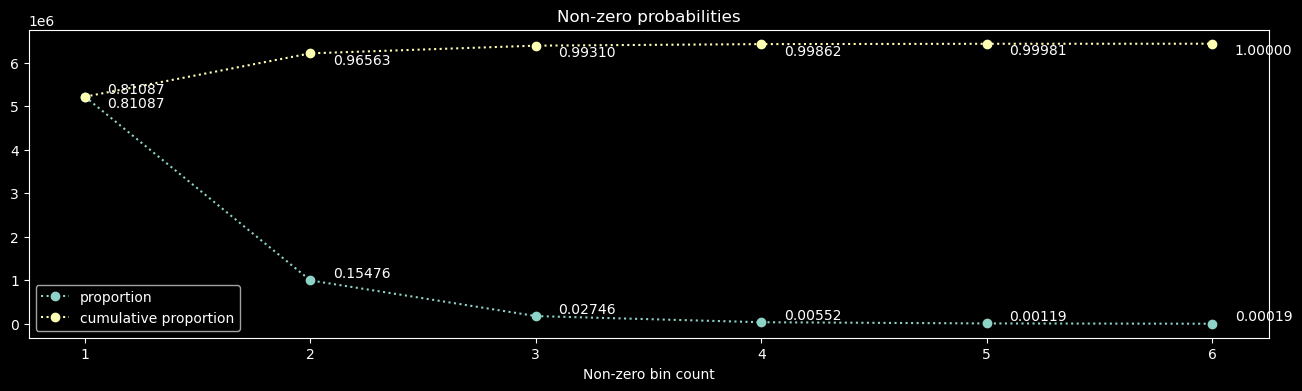

In [ ]:
vec = CountVectorizer(token_pattern=WORD_TOKENIZER_REGEX#, dtype='uint8'
                     ).fit(text_vector)
tdm = vec.transform(text_vector)
display(tdm)
display(pd.DataFrame(tdm.toarray(), columns=vec.get_feature_names_out()))

print('Sparsity                           : {}'.format(1 - tdm.nnz / (tdm.shape[0]*tdm.shape[1])))
print('Max term frequency in a document   : {}'.format(tdm.max()))
print('Max term frequency in all documents: {}'.format(tdm.sum(axis=0).max()))
print('Max words in a document            : {}'.format(tdm.sum(axis=1).max()))
print('Mean words per document            : {:.1f}'.format(tdm.sum(axis=1).mean()))
print('Median words per document          : {}'.format(np.median(np.array(tdm.sum(axis=1)))))
print('Sparse matrix memory usage         :', size((tdm.data.nbytes + tdm.indptr.nbytes + tdm.indices.nbytes)))
print('Dense matrix memory equivalence    :', size(tdm.shape[0]*tdm.shape[1]*tdm.dtype.itemsize))
print('Non-zero probabilities:', end='')
nz_bin_count = [[bc, (tdm == bc).sum(), (tdm == bc).sum()/tdm.nnz] for bc in range(1, tdm.max() + 1)]
display(pd.DataFrame(nz_bin_count, columns=['bin', 'count', 'proportion']))
bc, count, prob = zip(*nz_bin_count)
cumcount = np.cumsum(count).tolist()
cumprob = np.cumsum(prob).tolist()
plt.figure(figsize=(16,4))
plt.plot(bc, count, 'o:', label='proportion')
plt.title('Non-zero probabilities')
for i, _ in enumerate(prob):
    plt.text(bc[i]+.1, count[i], '{:.5f}'.format(prob[i]), va='bottom', ha='left')
plt.plot(bc, cumcount, 'o:', label='cumulative proportion')
for i, _ in enumerate(cumprob):
    plt.text(bc[i]+.1, cumcount[i], '{:.5f}'.format(cumprob[i]), va='top', ha='left')
plt.xlabel('Non-zero bin count')
plt.legend()
plt.show()

* **`81%` of the words appear only `1`  time in the rows.**
* **`99%` of the words appear from `1` to `3` times in the rows.**
* **`19%` of the words appear `2` or more times, in fact up to `6` times in the rows.**

Observations with 6 duplicate words:

In [ ]:
df.loc[((tdm==6).sum(axis=1)==1), TEXT_FEATURES]\
    .set_axis([x.replace('_',' ') for x in TEXT_FEATURES], axis=1)

,Object Description,Sub Object Description,Function Description,Fund Description,SubFund Description,Program Description,Location Description,Facility or Department,Job Title Description,Position Extra,Text 1,Text 2,Text 3,Text 4
386472,Equipment and Furniture,"Supplies And Materials For Operation, Maintenance And Repair *",Care and Upkeep of Equipment and Furniture Services,Title I - Disadvantaged Children/Targeted Assistance,Operation and Maintenance of Plant Services,NaN,NaN,NaN,NaN,NaN,ESEA TITLE I,NaN,NaN,NaN
280099,SALARIES OF REGULAR EMPLOYEES,NaN,NON-PROJECT,NaN,FOOD SERVICE FUND,FOOD PREPARATION/SERVING,FOOD AND NUTRITION SERVICES,NaN,"Supv, Area Food Services",PROFESSIONAL-OTHER,FOOD SERVICES OPERATIONS,FOOD SERVICES,NaN,NaN
22532,EMPLOYEE BENEFITS,NaN,NON-PROJECT,NaN,FOOD SERVICE FUND,FOOD PREPARATION/SERVING,FOOD AND NUTRITION SERVICES,NaN,Food Service Worker I,"CRAFTS, TRADES, AND SERVICES",FOOD SERVICES OPERATIONS,FOOD SERVICES,NaN,NaN
92031,SALARIES OF PART TIME EMPLOYEE,NaN,NON-PROJECT,NaN,FOOD SERVICE FUND,FOOD PREPARATION/SERVING,FOOD AND NUTRITION SERVICES,NaN,Food Service Worker II,"CRAFTS, TRADES, AND SERVICES",FOOD SERVICES OPERATIONS,FOOD SERVICES,NaN,NaN
203829,SALARIES OF PART TIME EMPLOYEE,NaN,NON-PROJECT,NaN,FOOD SERVICE FUND,FOOD PREPARATION/SERVING,FOOD AND NUTRITION SERVICES,NaN,Food Service Worker I,"CRAFTS, TRADES, AND SERVICES",FOOD SERVICES OPERATIONS,FOOD SERVICES,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192807,EMPLOYEE BENEFITS,NaN,NON-PROJECT,NaN,FOOD SERVICE FUND,FOOD PREPARATION/SERVING,FOOD AND NUTRITION SERVICES,NaN,Food Service Worker I,"CRAFTS, TRADES, AND SERVICES",FOOD SERVICES OPERATIONS,FOOD SERVICES,NaN,NaN
448821,EMPLOYEE BENEFITS,NaN,NON-PROJECT,NaN,FOOD SERVICE FUND,FOOD PREPARATION/SERVING,FOOD AND NUTRITION SERVICES,NaN,Food Service Worker I,"CRAFTS, TRADES, AND SERVICES",FOOD SERVICES OPERATIONS,FOOD SERVICES,NaN,NaN
306007,SALARIES OF PART TIME EMPLOYEE,NaN,NON-PROJECT,NaN,FOOD SERVICE FUND,FOOD PREPARATION/SERVING,FOOD AND NUTRITION SERVICES,NaN,Food Service Worker I,"CRAFTS, TRADES, AND SERVICES",FOOD SERVICES OPERATIONS,FOOD SERVICES,NaN,NaN
108809,Salaries And Wages For Teachers And Other Professi,Salaries And Wages For Teachers And Other Professi,Instruction,General Operating Fund,Operations,Gifted And Talented,School,All Campus Payroll,GIFTED AND TALENTED TEACHERS,TEACHER BACHELOR,REGULAR PAY,NaN,NaN,NaN


Vocabulary

In [ ]:
vec.vocabulary_

{'extra': 1297,
 'duty': 1099,
 'pay': 2534,
 'overtime': 2480,
 'for': 1395,
 'support': 3339,
 'personnel': 2569,
 'transportation': 3530,
 'general': 1478,
 'operating': 2435,
 'fund': 1438,
 'operations': 2437,
 'undistributed': 3577,
 'unallocated': 3573,
 'department': 954,
 'bus': 475,
 'drivers': 1085,
 'reg': 2850,
 'driver': 1084,
 'run': 2996,
 'second': 3064,
 'runs': 2997,
 'salaries': 3009,
 'of': 2399,
 'regular': 2857,
 'employees': 1170,
 'class': 631,
 'size': 3147,
 'relief': 2876,
 'high': 1601,
 'school': 3037,
 'education': 1127,
 'teacher': 3405,
 'secondary': 3065,
 'middle': 2234,
 'professional': 2716,
 'instructional': 1768,
 'instruction': 1767,
 'services': 3093,
 'and': 198,
 'technical': 3418,
 'curriculum': 899,
 'development': 986,
 'special': 3192,
 'trust': 3547,
 'staff': 3222,
 'itemaa': 1864,
 'charity': 588,
 'fdn': 1329,
 'part': 2508,
 'time': 3476,
 'employee': 1169,
 'state': 3237,
 'gifted': 1493,
 'talented': 3381,
 'local': 2086,
 'gdpg': 1

Single char vocabulary

In [ ]:
({k:v for k, v in vec.vocabulary_.items() if len(k)==1})

{'k': 1953,
 '8': 21,
 'i': 1655,
 '9': 26,
 's': 3000,
 'a': 28,
 'e': 1105,
 'l': 1983,
 'd': 911,
 '6': 10,
 'g': 1454,
 't': 3374,
 'm': 2117,
 'j': 1927,
 'b': 336,
 'p': 2483,
 'c': 484,
 'o': 2383,
 'h': 1553,
 'n': 2306,
 'f': 1301,
 'w': 3661,
 'x': 3733,
 'v': 3609,
 'u': 3570,
 'z': 3751,
 '7': 14,
 'r': 2796,
 '5': 7,
 '4': 5}

## Vocabulary size as function of ngram_range

Vocabulary size for each ngram_range

In [ ]:
# Pre-fetch unigram max unique tokens in a document
# max_unigrams = CountVectorizer(token_pattern=WORD_TOKENIZER_REGEX, dtype='uint8', binary=True).fit_transform(text_vector).sum(axis=1).max().astype(int)
max_unigrams = 39
print(f'Max unique unigram tokens: {max_unigrams}')

Max unique unigram tokens: 39


In [ ]:
from mcr.nlp import ngram_vocabulary_size
# Pre-fetch vocabulary sizes
# vocabulary_sizes = Parallel(n_jobs=14)(delayed(ngram_vocabulary_size)(text_vector, ngram_range=(1, ngram)) for ngram in range(1, max_unigrams+1)) # 3m 59.97s
vocabulary_sizes = [3758, 32011, 86424, 165642, 267225, 390038, 531563, 689377, 860680, 1042527, 1231386, 1422522, 1612185, 1796647, 1972122, 2135623,
                    2284785, 2418729, 2536972, 2639838, 2728430, 2804263, 2869149, 2924946, 2973322, 3015715, 3053344, 3086975, 3117272, 3144635,
                    3169278, 3191394, 3211161, 3228702, 3244177, 3257666, 3269245, 3279027, 3287190]

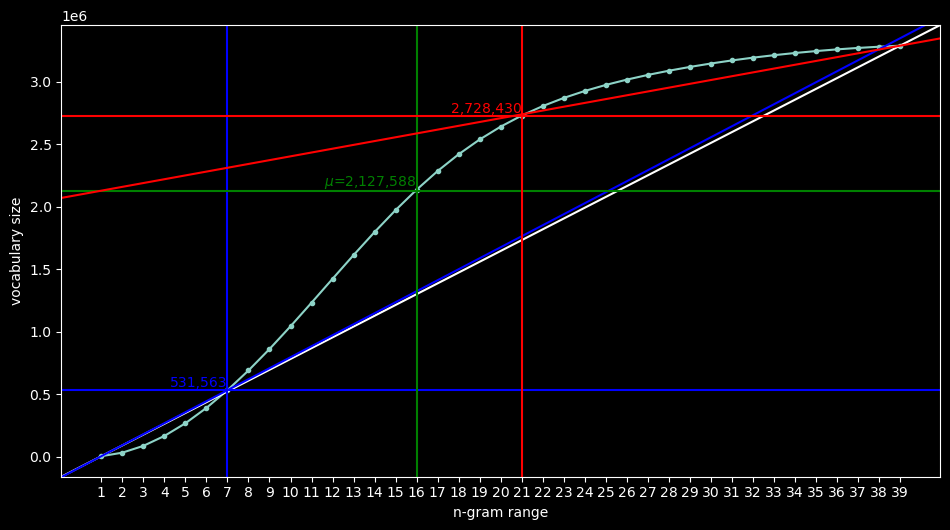

In [ ]:
mu = np.mean(vocabulary_sizes)
x=range(1, max_unigrams+1)

plt.figure(figsize=(9.6, 5.4))
plt.plot(x, vocabulary_sizes, '.-')
plt.xlabel('n-gram range'); plt.ylabel('vocabulary size')
plt.xticks(range(1, max_unigrams+1))
# plt.yticks(vocabulary_sizes)
# for i,j in zip(range(1, len(vocabulary_sizes)), vocabulary_sizes):
#     plt.text(i,j,f'{j:,.0f}', horizontalalignment='right', verticalalignment='bottom', size=8)
#     plt.text(i,j,i, horizontalalignment='left', verticalalignment='top')

# plot to endpoints
plt.axline(xy1=(1,vocabulary_sizes[0]), xy2=(len(vocabulary_sizes), vocabulary_sizes[-1]))
# plot first break
plt.axline(xy1=(1,vocabulary_sizes[0]), xy2=(7, vocabulary_sizes[6]), color='b')
plt.axvline(7, color='b')
plt.axhline(vocabulary_sizes[6], color='b')
plt.text(x=7, y=vocabulary_sizes[6], s=f'{vocabulary_sizes[6]:,.0f}', horizontalalignment='right', verticalalignment='bottom', color='b')
# plot mean
plt.axhline(np.mean(vocabulary_sizes), color='g')
plt.text(x=16, y=mu, s=f'$\mu$={mu:,.0f}', horizontalalignment='right', verticalalignment='bottom', color='g')
plt.axvline(16, color='g')
# plot from mean to max
plt.axline(xy1=(1,mu), xy2=(len(vocabulary_sizes), vocabulary_sizes[-1]), color='r')
plt.axvline(21, color='r')
plt.axhline(vocabulary_sizes[20], color='r')
plt.text(x=21, y=vocabulary_sizes[20], s=f'{vocabulary_sizes[20]:,.0f}', horizontalalignment='right', verticalalignment='bottom', color='r')
plt.tight_layout()
plt.show()

The `ngram_range` afffects the number of non zeros (nnz) thus, the memory usage.
It'll be assumed the limit of 7 which is more than hundred times bigger than unigram's:

In [ ]:
vocabulary_sizes[6] / vocabulary_sizes[0]

141.44837679616816

## Tokenizing n-gram ranges

The `CountVectorizer` default `dtype` is `int64`.

As the maximum frequency of any token in a single observation is 6, the 8-bits unsigned integer `uint8` (0 to 255) could be enough to store counts of any ngram range.

In [ ]:
# def func(ngram_range, text_vector):
#     tracemalloc.start()
#     tracemalloc.reset_peak()
#     t=time()
#     tdm = CountVectorizer(token_pattern=WORD_TOKENIZER_REGEX, ngram_range = ngram_range, dtype='uint8').fit_transform(text_vector)
#     t=time()-t
#     current, peak = tracemalloc.get_traced_memory()
#     tracemalloc.stop()
#     tdm_nbytes = (tdm.data.nbytes + tdm.indptr.nbytes + tdm.indices.nbytes)
#     msg = 'ngram:{},{} cols:{} maxtf:{} maxtfall:{} nnz:{} sparse:{:.2f}% size:{} cur:{} peak:{} {:.0f}s'
#     msg = msg.format(ngram_range[0], ngram_range[1], tdm.shape[1], tdm.max(), tdm.sum(axis=0).max(), tdm.nnz,
#                      (1 - tdm.nnz / (tdm.shape[0] * tdm.shape[1])) * 100, size(tdm_nbytes), size(current), size(peak), t)
#     return msg

# messages = Parallel(n_jobs=14)(delayed(func)(ngram_range, text_vector) for ngram_range in [(1,x) for x in range(1, 8)]) # 46.78s

# for message in messages:
#     print(message)

```
Last executed at 2022-11-10 15:49:47 in 46.78s

ngram:1,1 cols:3758 maxtf:6 maxtfall:331001 nnz:6441095 sparse:99.57% size:32.2 MiB cur:32.3 MiB peak:119.7 MiB 7s
ngram:1,2 cols:32011 maxtf:6 maxtfall:331001 nnz:13478633 sparse:99.89% size:65.8 MiB cur:65.9 MiB peak:234.7 MiB 14s
ngram:1,3 cols:86424 maxtf:6 maxtfall:331001 nnz:20372670 sparse:99.94% size:98.7 MiB cur:98.8 MiB peak:354.3 MiB 20s
ngram:1,4 cols:165642 maxtf:6 maxtfall:331001 nnz:26957695 sparse:99.96% size:130.1 MiB cur:130.2 MiB peak:474.2 MiB 26s
ngram:1,5 cols:267225 maxtf:6 maxtfall:331001 nnz:33195723 sparse:99.97% size:159.8 MiB cur:159.9 MiB peak:600.4 MiB 32s
ngram:1,6 cols:390038 maxtf:6 maxtfall:331001 nnz:39080590 sparse:99.97% size:187.9 MiB cur:188.0 MiB peak:731.0 MiB 38s
ngram:1,7 cols:531563 maxtf:6 maxtfall:331001 nnz:44603334 sparse:99.98% size:214.2 MiB cur:214.3 MiB peak:850.7 MiB 44s
```

## n-gram range frequency plot

In [ ]:
# stop_words = CountVectorizer(stop_words='english').get_stop_words()
# def func(ngram_range, text_vector):
#     vec = CountVectorizer(token_pattern=WORD_TOKENIZER_REGEX, ngram_range=ngram_range, dtype='uint8')
#     tdm = vec.fit_transform(text_vector)
#     return ngram_range, pd.DataFrame({'term': vec.get_feature_names_out(), 'proportion': tdm.mean(axis=0).tolist()[0],
#                                       'frequency': tdm.sum(axis=0).tolist()[0],
#                                       # whether the term contains a stop word
#                                       'stop_word': [True if any([True if word in stop_words else False for word in str.split(words)])
#                                                     else False
#                                                     for words in vec.get_feature_names_out()]}).sort_values(['frequency','term'],
#                                                                                                             ascending=(False, True)).head(100)


# for ngram_range, plot_df in Parallel(n_jobs=14)(delayed(func)(ngram_range, text_vector) for ngram_range in [(1,x) for x in range(1, 8)]):
#     plt.figure(figsize=(15,12))
#     plt.grid()
#     ax = sns.barplot(x='frequency', y='term', data=plot_df, hue='stop_word', dodge=False)
#     patches = ax.patches
#     for i in range(len(patches)):
#         y = patches[i].get_y() + patches[i].get_height()
#         x = patches[i].get_x() + patches[i].get_width()
#         ax.annotate('{:.2f}%'.format(plot_df['proportion'].iloc[i%plot_df.shape[0]]*100), (x, y))#, ha='center')
#     plt.title('n-gram range {} frequency'.format(ngram_range))
#     plt.tight_layout()
#     plt.show()    

## Hashing Trick

* Adding new features (e.g. 3-grams, 4-grams) may cause enormous increase in array size
* Hashing is a way of increasing memory efficiency
* Want to make array of features as small as possible: dimensionality Reduction
* Hash functions limits possible outputs, fixing array size
* Particularly useful on large datasets: e.g. lots of text data!

In [ ]:
from sklearn.feature_extraction.text import HashingVectorizer

The parameters `norm=None`, `alternate_sign=False` and `binary=False` let us drop in the `HashingVectorizer()` as a replacement for `CounterVectorizer()`

[From sklearn docs](https://scikit-learn.org/stable/modules/feature_extraction.html#feature-hashing):
> Since the hash function might cause collisions between (unrelated) features, a signed hash function is used and the sign of the hash value determines the sign of the value stored in the output matrix for a feature. This way, collisions are likely to cancel out rather than accumulate error, and the expected mean of any output feature’s value is zero. This mechanism is enabled by default with `alternate_sign=True` and is particularly useful for small hash table sizes (`n_features < 10000`). For large hash table sizes, it can be disabled, to allow the output to be passed to estimators like `sklearn.naive_bayes.MultinomialNB` or `sklearn.feature_selection.chi2` feature selectors that expect non-negative inputs.

Why is hashing a useful trick?

A hash function takes an input, in your case a token, and outputs a hash value. For example, the input may be a string and the hash value may be an integer.

A familiar python datatype, a dictionary, makes this mapping concept a bit more explicit. In fact, python dictionaries ARE hash tables!

`{'petro': 354, 'vend': 785, 'fuel': 895, 'and': 780, 'fluids': 354}`

By explicitly stating how many possible outputs the hashing function may have, we limit the size of the objects that need to be processed. With these limits known, computation can be made more efficient and we can get results faster, even on large datasets.

The default limit is `n_features=1048576` $(2^{20})$.  The number of features (columns) in the output matrices. Small numbers of features are likely to cause hash collisions, but large numbers will cause larger coefficient dimensions in linear learners.

Some problems are memory-bound and not easily parallelizable, and hashing enforces a fixed length computation instead of using a mutable datatype (like a dictionary).  Enforcing a fixed length can speed up calculations drastically, especially on large datasets!

Tokenizing unigram (words)

<400277x1048576 sparse matrix of type '<class 'numpy.float64'>'
	with 6441095 stored elements in Compressed Sparse Row format>

Sparsity                                    : 0.9984653860024352
Max count of a hashed token in a document   : 6.0
Max count of a hashed token in all documents: 331001.0
Max unique hashed tokens per document       : 53.0
Mean unique hashed tokens per document      : 19.8
Median unique tokens per document           : 19.0
Sparse matrix memory usage                  : 75.2 MiB
Dense matrix memory equivalence             : 3.1 TiB
Non-zero probabilities:

,bin,count,proportion
0,1,5222873,0.810867
1,2,996854,0.154765
2,3,176893,0.027463
3,4,35572,0.005523
4,5,7678,0.001192
5,6,1225,0.000190


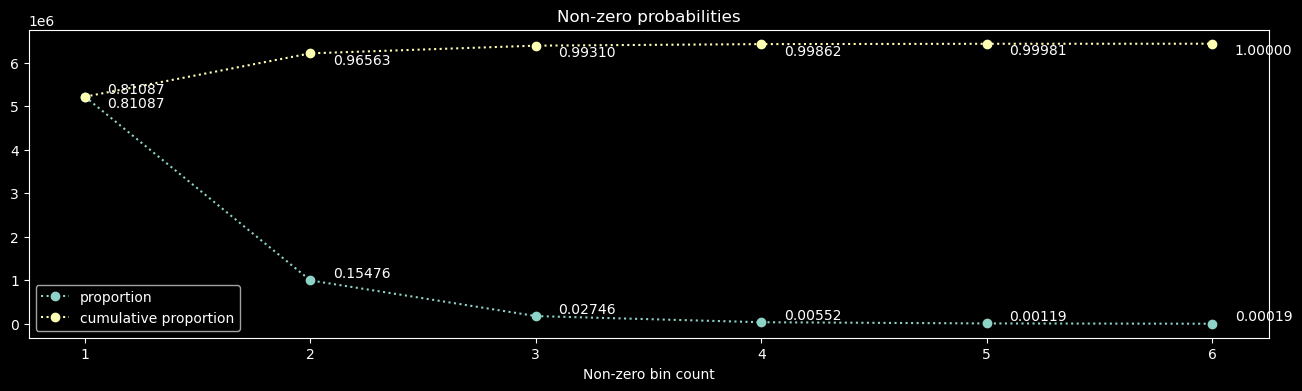

In [ ]:
vec = HashingVectorizer(norm=None, alternate_sign=False, binary=False, n_features=2**20, token_pattern=WORD_TOKENIZER_REGEX#, dtype='uint8'
                       )
tdm = vec.fit_transform(text_vector)
display(tdm)
print('Sparsity                                    : {}'.format(1 - tdm.nnz / (tdm.shape[0]*tdm.shape[1]) * 100))
print('Max count of a hashed token in a document   : {}'.format(tdm.max()))
print('Max count of a hashed token in all documents: {}'.format(tdm.sum(axis=0).max()))
print('Max unique hashed tokens per document       : {}'.format(tdm.sum(axis=1).max()))
print('Mean unique hashed tokens per document      : {:.1f}'.format(tdm.sum(axis=1).mean()))
print('Median unique tokens per document           : {}'.format(np.median(np.array(tdm.sum(axis=1)).reshape(-1))))
print('Sparse matrix memory usage                  :', size((tdm.data.nbytes + tdm.indptr.nbytes + tdm.indices.nbytes)))
print('Dense matrix memory equivalence             :', size(tdm.shape[0]*tdm.shape[1]*tdm.dtype.itemsize))
print('Non-zero probabilities:', end='')
nz_bin_count = [[bc, (tdm == bc).sum(), (tdm == bc).sum()/tdm.nnz] for bc in range(1, int(tdm.max()) + 1)]
display(pd.DataFrame(nz_bin_count, columns=['bin', 'count', 'proportion']))
bc, count, prob = zip(*nz_bin_count)
cumcount = np.cumsum(count).tolist()
cumprob = np.cumsum(prob).tolist()
plt.figure(figsize=(16,4))
plt.plot(bc, count, 'o:', label='proportion')
plt.title('Non-zero probabilities')
for i, _ in enumerate(prob):
    plt.text(bc[i]+.1, count[i], '{:.5f}'.format(prob[i]), va='bottom', ha='left')
plt.plot(bc, cumcount, 'o:', label='cumulative proportion')
for i, _ in enumerate(cumprob):
    plt.text(bc[i]+.1, cumcount[i], '{:.5f}'.format(cumprob[i]), va='top', ha='left')
plt.xlabel('Non-zero bin count')
plt.legend()
plt.show()

The maximum frequency of any hashed 1-gram token in a single observation is also 6 so the 8-bits unsigned integer `uint8` (0 to 255) also could be enough to store counts of any ngram range as long as there are sufficient `n_features`.

## Tokenizing hashed n-gram ranges

Iterating over `n_features` from the default $2^{20}$ to the maximum $2^{30}$ ([Murmurhash3 32-bit](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html)) and n-gram range from 1 to 7 in order to understand hashing collisions and memory usage.

In [ ]:
# def func(ngram_range, i, text_vector):
#     tracemalloc.start()
#     tracemalloc.reset_peak()
#     t=time()
#     tdm = HashingVectorizer(norm=None, alternate_sign=False, binary=False, token_pattern=WORD_TOKENIZER_REGEX,
#                                 ngram_range=ngram_range, n_features=2**i-(i//31), dtype='uint8').fit_transform(text_vector)
#     t=time()-t
#     current, peak = tracemalloc.get_traced_memory()
#     tracemalloc.stop()
#     _, hash_counts = np.unique(tdm.data, return_counts=True)
#     tdm_nbytes = (tdm.data.nbytes + tdm.indptr.nbytes + tdm.indices.nbytes)

#     msg = 'features:2^{}-{}={} ngram:{},{} cols:{} maxtf:{:.0f} maxtfall:{:.0f} hashcount:{} nnz:{} sparse:{:.4f}% size:{} cur:{} peak:{} {:.0f}s'
#     msg = msg.format(i, (i//31), 2**i-(i//31), ngram_range[0], ngram_range[1], tdm.shape[1], tdm.max(),
#                      tdm.sum(axis=0).max(), len(hash_counts), tdm.nnz, (1 - tdm.nnz / (tdm.shape[0] * tdm.shape[1])) * 100,
#                      size(tdm_nbytes), size(current), size(peak), t)
#     return msg

# messages = Parallel(n_jobs=14)(delayed(func)(ngram_range, i, text_vector)
#                                for ngram_range in [(1,x) for x in range(1, 8)]
#                                for i in range(18, 32) # from 18 (recommended large enough) to 2^31-1 (Mumuhash3 32-bit)
#                               )
# for message in messages:
#     print(message)

```
Last executed at 2022-09-16 17:49:50 in 6m 46.99s

features:2^18-0=262144 ngram:1,1 cols:262144 maxtf:6 maxtfall:331001 hashcount:6 nnz:6441089 sparse:99.9939% size:32.2 MiB cur:9.6 MiB peak:12.0 MiB 16s
features:2^19-0=524288 ngram:1,1 cols:524288 maxtf:6 maxtfall:331001 hashcount:6 nnz:6441094 sparse:99.9969% size:32.2 MiB cur:9.6 MiB peak:12.0 MiB 17s
features:2^20-0=1048576 ngram:1,1 cols:1048576 maxtf:6 maxtfall:331001 hashcount:6 nnz:6441095 sparse:99.9985% size:32.2 MiB cur:9.6 MiB peak:12.0 MiB 16s
features:2^21-0=2097152 ngram:1,1 cols:2097152 maxtf:6 maxtfall:331001 hashcount:6 nnz:6441095 sparse:99.9992% size:32.2 MiB cur:9.6 MiB peak:12.0 MiB 17s
features:2^22-0=4194304 ngram:1,1 cols:4194304 maxtf:6 maxtfall:331001 hashcount:6 nnz:6441095 sparse:99.9996% size:32.2 MiB cur:9.6 MiB peak:12.0 MiB 16s
features:2^23-0=8388608 ngram:1,1 cols:8388608 maxtf:6 maxtfall:331001 hashcount:6 nnz:6441095 sparse:99.9998% size:32.2 MiB cur:9.6 MiB peak:12.0 MiB 16s
features:2^24-0=16777216 ngram:1,1 cols:16777216 maxtf:6 maxtfall:331001 hashcount:6 nnz:6441095 sparse:99.9999% size:32.2 MiB cur:9.6 MiB peak:12.0 MiB 17s
features:2^25-0=33554432 ngram:1,1 cols:33554432 maxtf:6 maxtfall:331001 hashcount:6 nnz:6441095 sparse:100.0000% size:32.2 MiB cur:9.6 MiB peak:12.0 MiB 17s
features:2^26-0=67108864 ngram:1,1 cols:67108864 maxtf:6 maxtfall:331001 hashcount:6 nnz:6441095 sparse:100.0000% size:32.2 MiB cur:9.6 MiB peak:12.0 MiB 17s
features:2^27-0=134217728 ngram:1,1 cols:134217728 maxtf:6 maxtfall:331001 hashcount:6 nnz:6441095 sparse:100.0000% size:32.2 MiB cur:9.5 MiB peak:12.0 MiB 17s
features:2^28-0=268435456 ngram:1,1 cols:268435456 maxtf:6 maxtfall:331001 hashcount:6 nnz:6441095 sparse:100.0000% size:32.2 MiB cur:9.5 MiB peak:12.0 MiB 17s
features:2^29-0=536870912 ngram:1,1 cols:536870912 maxtf:6 maxtfall:331001 hashcount:6 nnz:6441095 sparse:100.0000% size:32.2 MiB cur:9.5 MiB peak:12.0 MiB 17s
features:2^30-0=1073741824 ngram:1,1 cols:1073741824 maxtf:6 maxtfall:331001 hashcount:6 nnz:6441095 sparse:100.0000% size:32.2 MiB cur:9.5 MiB peak:12.0 MiB 17s
features:2^31-1=2147483647 ngram:1,1 cols:2147483647 maxtf:6 maxtfall:331001 hashcount:6 nnz:6441095 sparse:100.0000% size:32.2 MiB cur:9.5 MiB peak:12.0 MiB 17s
features:2^18-0=262144 ngram:1,2 cols:262144 maxtf:6 maxtfall:331001 hashcount:6 nnz:13478586 sparse:99.9872% size:65.8 MiB cur:17.6 MiB peak:24.0 MiB 35s
features:2^19-0=524288 ngram:1,2 cols:524288 maxtf:6 maxtfall:331001 hashcount:6 nnz:13478607 sparse:99.9936% size:65.8 MiB cur:17.6 MiB peak:24.0 MiB 35s
features:2^20-0=1048576 ngram:1,2 cols:1048576 maxtf:6 maxtfall:331001 hashcount:6 nnz:13478633 sparse:99.9968% size:65.8 MiB cur:17.5 MiB peak:24.0 MiB 35s
features:2^21-0=2097152 ngram:1,2 cols:2097152 maxtf:6 maxtfall:331001 hashcount:6 nnz:13478633 sparse:99.9984% size:65.8 MiB cur:17.5 MiB peak:24.0 MiB 34s
features:2^22-0=4194304 ngram:1,2 cols:4194304 maxtf:6 maxtfall:331001 hashcount:6 nnz:13478633 sparse:99.9992% size:65.8 MiB cur:17.5 MiB peak:24.0 MiB 35s
features:2^23-0=8388608 ngram:1,2 cols:8388608 maxtf:6 maxtfall:331001 hashcount:6 nnz:13478633 sparse:99.9996% size:65.8 MiB cur:17.5 MiB peak:24.0 MiB 35s
features:2^24-0=16777216 ngram:1,2 cols:16777216 maxtf:6 maxtfall:331001 hashcount:6 nnz:13478633 sparse:99.9998% size:65.8 MiB cur:17.5 MiB peak:24.0 MiB 34s
features:2^25-0=33554432 ngram:1,2 cols:33554432 maxtf:6 maxtfall:331001 hashcount:6 nnz:13478633 sparse:99.9999% size:65.8 MiB cur:17.5 MiB peak:24.0 MiB 34s
features:2^26-0=67108864 ngram:1,2 cols:67108864 maxtf:6 maxtfall:331001 hashcount:6 nnz:13478633 sparse:99.9999% size:65.8 MiB cur:17.5 MiB peak:24.0 MiB 35s
features:2^27-0=134217728 ngram:1,2 cols:134217728 maxtf:6 maxtfall:331001 hashcount:6 nnz:13478633 sparse:100.0000% size:65.8 MiB cur:17.5 MiB peak:24.0 MiB 34s
features:2^28-0=268435456 ngram:1,2 cols:268435456 maxtf:6 maxtfall:331001 hashcount:6 nnz:13478633 sparse:100.0000% size:65.8 MiB cur:17.5 MiB peak:24.0 MiB 35s
features:2^29-0=536870912 ngram:1,2 cols:536870912 maxtf:6 maxtfall:331001 hashcount:6 nnz:13478633 sparse:100.0000% size:65.8 MiB cur:17.5 MiB peak:24.0 MiB 36s
features:2^30-0=1073741824 ngram:1,2 cols:1073741824 maxtf:6 maxtfall:331001 hashcount:6 nnz:13478633 sparse:100.0000% size:65.8 MiB cur:17.5 MiB peak:24.0 MiB 35s
features:2^31-1=2147483647 ngram:1,2 cols:2147483647 maxtf:6 maxtfall:331001 hashcount:6 nnz:13478633 sparse:100.0000% size:65.8 MiB cur:17.5 MiB peak:24.0 MiB 34s
features:2^18-0=262144 ngram:1,3 cols:262144 maxtf:6 maxtfall:331001 hashcount:6 nnz:20371267 sparse:99.9806% size:98.7 MiB cur:33.5 MiB peak:48.0 MiB 49s
features:2^19-0=524288 ngram:1,3 cols:524288 maxtf:6 maxtfall:331001 hashcount:6 nnz:20372027 sparse:99.9903% size:98.7 MiB cur:33.5 MiB peak:48.0 MiB 50s
features:2^20-0=1048576 ngram:1,3 cols:1048576 maxtf:6 maxtfall:331001 hashcount:6 nnz:20372345 sparse:99.9951% size:98.7 MiB cur:33.5 MiB peak:48.0 MiB 49s
features:2^21-0=2097152 ngram:1,3 cols:2097152 maxtf:6 maxtfall:331001 hashcount:6 nnz:20372662 sparse:99.9976% size:98.7 MiB cur:33.5 MiB peak:48.0 MiB 50s
features:2^22-0=4194304 ngram:1,3 cols:4194304 maxtf:6 maxtfall:331001 hashcount:6 nnz:20372668 sparse:99.9988% size:98.7 MiB cur:33.5 MiB peak:48.0 MiB 50s
features:2^23-0=8388608 ngram:1,3 cols:8388608 maxtf:6 maxtfall:331001 hashcount:6 nnz:20372669 sparse:99.9994% size:98.7 MiB cur:33.5 MiB peak:48.0 MiB 50s
features:2^24-0=16777216 ngram:1,3 cols:16777216 maxtf:6 maxtfall:331001 hashcount:6 nnz:20372670 sparse:99.9997% size:98.7 MiB cur:33.5 MiB peak:48.0 MiB 50s
features:2^25-0=33554432 ngram:1,3 cols:33554432 maxtf:6 maxtfall:331001 hashcount:6 nnz:20372670 sparse:99.9998% size:98.7 MiB cur:33.5 MiB peak:48.0 MiB 49s
features:2^26-0=67108864 ngram:1,3 cols:67108864 maxtf:6 maxtfall:331001 hashcount:6 nnz:20372670 sparse:99.9999% size:98.7 MiB cur:33.5 MiB peak:48.0 MiB 49s
features:2^27-0=134217728 ngram:1,3 cols:134217728 maxtf:6 maxtfall:331001 hashcount:6 nnz:20372670 sparse:100.0000% size:98.7 MiB cur:33.5 MiB peak:48.0 MiB 49s
features:2^28-0=268435456 ngram:1,3 cols:268435456 maxtf:6 maxtfall:331001 hashcount:6 nnz:20372670 sparse:100.0000% size:98.7 MiB cur:33.5 MiB peak:48.0 MiB 50s
features:2^29-0=536870912 ngram:1,3 cols:536870912 maxtf:6 maxtfall:331001 hashcount:6 nnz:20372670 sparse:100.0000% size:98.7 MiB cur:33.5 MiB peak:48.0 MiB 50s
features:2^30-0=1073741824 ngram:1,3 cols:1073741824 maxtf:6 maxtfall:331001 hashcount:6 nnz:20372670 sparse:100.0000% size:98.7 MiB cur:33.5 MiB peak:48.0 MiB 50s
features:2^31-1=2147483647 ngram:1,3 cols:2147483647 maxtf:6 maxtfall:331001 hashcount:6 nnz:20372670 sparse:100.0000% size:98.7 MiB cur:33.5 MiB peak:48.0 MiB 50s
features:2^18-0=262144 ngram:1,4 cols:262144 maxtf:6 maxtfall:331001 hashcount:6 nnz:26955689 sparse:99.9743% size:130.1 MiB cur:33.5 MiB peak:48.0 MiB 64s
features:2^19-0=524288 ngram:1,4 cols:524288 maxtf:6 maxtfall:331001 hashcount:6 nnz:26956768 sparse:99.9872% size:130.1 MiB cur:33.5 MiB peak:48.0 MiB 63s
features:2^20-0=1048576 ngram:1,4 cols:1048576 maxtf:6 maxtfall:331001 hashcount:6 nnz:26957325 sparse:99.9936% size:130.1 MiB cur:33.5 MiB peak:48.0 MiB 63s
features:2^21-0=2097152 ngram:1,4 cols:2097152 maxtf:6 maxtfall:331001 hashcount:6 nnz:26957645 sparse:99.9968% size:130.1 MiB cur:33.5 MiB peak:48.0 MiB 64s
features:2^22-0=4194304 ngram:1,4 cols:4194304 maxtf:6 maxtfall:331001 hashcount:6 nnz:26957651 sparse:99.9984% size:130.1 MiB cur:33.5 MiB peak:48.0 MiB 64s
features:2^23-0=8388608 ngram:1,4 cols:8388608 maxtf:6 maxtfall:331001 hashcount:6 nnz:26957652 sparse:99.9992% size:130.1 MiB cur:33.5 MiB peak:48.0 MiB 66s
features:2^24-0=16777216 ngram:1,4 cols:16777216 maxtf:6 maxtfall:331001 hashcount:6 nnz:26957695 sparse:99.9996% size:130.1 MiB cur:33.5 MiB peak:48.0 MiB 64s
features:2^25-0=33554432 ngram:1,4 cols:33554432 maxtf:6 maxtfall:331001 hashcount:6 nnz:26957695 sparse:99.9998% size:130.1 MiB cur:33.5 MiB peak:48.0 MiB 64s
features:2^26-0=67108864 ngram:1,4 cols:67108864 maxtf:6 maxtfall:331001 hashcount:6 nnz:26957695 sparse:99.9999% size:130.1 MiB cur:33.5 MiB peak:48.0 MiB 63s
features:2^27-0=134217728 ngram:1,4 cols:134217728 maxtf:6 maxtfall:331001 hashcount:6 nnz:26957695 sparse:99.9999% size:130.1 MiB cur:33.5 MiB peak:48.0 MiB 64s
features:2^28-0=268435456 ngram:1,4 cols:268435456 maxtf:6 maxtfall:331001 hashcount:6 nnz:26957695 sparse:100.0000% size:130.1 MiB cur:33.5 MiB peak:48.0 MiB 64s
features:2^29-0=536870912 ngram:1,4 cols:536870912 maxtf:6 maxtfall:331001 hashcount:6 nnz:26957695 sparse:100.0000% size:130.1 MiB cur:33.5 MiB peak:48.0 MiB 64s
features:2^30-0=1073741824 ngram:1,4 cols:1073741824 maxtf:6 maxtfall:331001 hashcount:6 nnz:26957695 sparse:100.0000% size:130.1 MiB cur:33.5 MiB peak:48.0 MiB 64s
features:2^31-1=2147483647 ngram:1,4 cols:2147483647 maxtf:6 maxtfall:331001 hashcount:6 nnz:26957695 sparse:100.0000% size:130.1 MiB cur:33.5 MiB peak:48.0 MiB 65s
features:2^18-0=262144 ngram:1,5 cols:262144 maxtf:6 maxtfall:331001 hashcount:6 nnz:33192778 sparse:99.9684% size:159.8 MiB cur:33.2 MiB peak:97.2 MiB 78s
features:2^19-0=524288 ngram:1,5 cols:524288 maxtf:6 maxtfall:331001 hashcount:6 nnz:33194134 sparse:99.9842% size:159.8 MiB cur:33.2 MiB peak:97.2 MiB 78s
features:2^20-0=1048576 ngram:1,5 cols:1048576 maxtf:6 maxtfall:331001 hashcount:6 nnz:33195262 sparse:99.9921% size:159.8 MiB cur:33.2 MiB peak:97.2 MiB 78s
features:2^21-0=2097152 ngram:1,5 cols:2097152 maxtf:6 maxtfall:331001 hashcount:6 nnz:33195621 sparse:99.9960% size:159.8 MiB cur:33.2 MiB peak:97.2 MiB 77s
features:2^22-0=4194304 ngram:1,5 cols:4194304 maxtf:6 maxtfall:331001 hashcount:6 nnz:33195630 sparse:99.9980% size:159.8 MiB cur:33.2 MiB peak:97.2 MiB 77s
features:2^23-0=8388608 ngram:1,5 cols:8388608 maxtf:6 maxtfall:331001 hashcount:6 nnz:33195677 sparse:99.9990% size:159.8 MiB cur:33.2 MiB peak:97.2 MiB 78s
features:2^24-0=16777216 ngram:1,5 cols:16777216 maxtf:6 maxtfall:331001 hashcount:6 nnz:33195720 sparse:99.9995% size:159.8 MiB cur:33.2 MiB peak:97.2 MiB 77s
features:2^25-0=33554432 ngram:1,5 cols:33554432 maxtf:6 maxtfall:331001 hashcount:6 nnz:33195720 sparse:99.9998% size:159.8 MiB cur:33.2 MiB peak:97.2 MiB 79s
features:2^26-0=67108864 ngram:1,5 cols:67108864 maxtf:6 maxtfall:331001 hashcount:6 nnz:33195720 sparse:99.9999% size:159.8 MiB cur:33.2 MiB peak:97.2 MiB 77s
features:2^27-0=134217728 ngram:1,5 cols:134217728 maxtf:6 maxtfall:331001 hashcount:6 nnz:33195723 sparse:99.9999% size:159.8 MiB cur:33.2 MiB peak:97.2 MiB 79s
features:2^28-0=268435456 ngram:1,5 cols:268435456 maxtf:6 maxtfall:331001 hashcount:6 nnz:33195723 sparse:100.0000% size:159.8 MiB cur:33.2 MiB peak:97.2 MiB 77s
features:2^29-0=536870912 ngram:1,5 cols:536870912 maxtf:6 maxtfall:331001 hashcount:6 nnz:33195723 sparse:100.0000% size:159.8 MiB cur:33.2 MiB peak:97.2 MiB 77s
features:2^30-0=1073741824 ngram:1,5 cols:1073741824 maxtf:6 maxtfall:331001 hashcount:6 nnz:33195723 sparse:100.0000% size:159.8 MiB cur:33.2 MiB peak:97.2 MiB 77s
features:2^31-1=2147483647 ngram:1,5 cols:2147483647 maxtf:6 maxtfall:331001 hashcount:6 nnz:33195723 sparse:100.0000% size:159.8 MiB cur:33.2 MiB peak:97.2 MiB 77s
features:2^18-0=262144 ngram:1,6 cols:262144 maxtf:6 maxtfall:331001 hashcount:6 nnz:39076758 sparse:99.9628% size:187.9 MiB cur:65.5 MiB peak:96.0 MiB 90s
features:2^19-0=524288 ngram:1,6 cols:524288 maxtf:6 maxtfall:331001 hashcount:6 nnz:39078725 sparse:99.9814% size:187.9 MiB cur:65.5 MiB peak:96.0 MiB 92s
features:2^20-0=1048576 ngram:1,6 cols:1048576 maxtf:6 maxtfall:331001 hashcount:6 nnz:39080009 sparse:99.9907% size:187.9 MiB cur:65.5 MiB peak:96.0 MiB 91s
features:2^21-0=2097152 ngram:1,6 cols:2097152 maxtf:6 maxtfall:331001 hashcount:6 nnz:39080451 sparse:99.9953% size:187.9 MiB cur:65.5 MiB peak:96.0 MiB 90s
features:2^22-0=4194304 ngram:1,6 cols:4194304 maxtf:6 maxtfall:331001 hashcount:6 nnz:39080488 sparse:99.9977% size:187.9 MiB cur:65.5 MiB peak:96.0 MiB 91s
features:2^23-0=8388608 ngram:1,6 cols:8388608 maxtf:6 maxtfall:331001 hashcount:6 nnz:39080542 sparse:99.9988% size:187.9 MiB cur:65.5 MiB peak:96.0 MiB 90s
features:2^24-0=16777216 ngram:1,6 cols:16777216 maxtf:6 maxtfall:331001 hashcount:6 nnz:39080587 sparse:99.9994% size:187.9 MiB cur:65.5 MiB peak:96.0 MiB 90s
features:2^25-0=33554432 ngram:1,6 cols:33554432 maxtf:6 maxtfall:331001 hashcount:6 nnz:39080587 sparse:99.9997% size:187.9 MiB cur:65.5 MiB peak:96.0 MiB 90s
features:2^26-0=67108864 ngram:1,6 cols:67108864 maxtf:6 maxtfall:331001 hashcount:6 nnz:39080587 sparse:99.9999% size:187.9 MiB cur:65.5 MiB peak:96.0 MiB 90s
features:2^27-0=134217728 ngram:1,6 cols:134217728 maxtf:6 maxtfall:331001 hashcount:6 nnz:39080590 sparse:99.9999% size:187.9 MiB cur:65.5 MiB peak:96.0 MiB 91s
features:2^28-0=268435456 ngram:1,6 cols:268435456 maxtf:6 maxtfall:331001 hashcount:6 nnz:39080590 sparse:100.0000% size:187.9 MiB cur:65.5 MiB peak:96.0 MiB 91s
features:2^29-0=536870912 ngram:1,6 cols:536870912 maxtf:6 maxtfall:331001 hashcount:6 nnz:39080590 sparse:100.0000% size:187.9 MiB cur:65.5 MiB peak:96.0 MiB 91s
features:2^30-0=1073741824 ngram:1,6 cols:1073741824 maxtf:6 maxtfall:331001 hashcount:6 nnz:39080590 sparse:100.0000% size:187.9 MiB cur:65.5 MiB peak:96.0 MiB 89s
features:2^31-1=2147483647 ngram:1,6 cols:2147483647 maxtf:6 maxtfall:331001 hashcount:6 nnz:39080590 sparse:100.0000% size:187.9 MiB cur:65.5 MiB peak:96.0 MiB 91s
features:2^18-0=262144 ngram:1,7 cols:262144 maxtf:6 maxtfall:331072 hashcount:6 nnz:44596942 sparse:99.9575% size:214.2 MiB cur:65.5 MiB peak:96.0 MiB 103s
features:2^19-0=524288 ngram:1,7 cols:524288 maxtf:6 maxtfall:331072 hashcount:6 nnz:44600006 sparse:99.9787% size:214.2 MiB cur:65.5 MiB peak:96.0 MiB 101s
features:2^20-0=1048576 ngram:1,7 cols:1048576 maxtf:6 maxtfall:331072 hashcount:6 nnz:44602296 sparse:99.9894% size:214.2 MiB cur:65.5 MiB peak:96.0 MiB 102s
features:2^21-0=2097152 ngram:1,7 cols:2097152 maxtf:6 maxtfall:331001 hashcount:6 nnz:44603017 sparse:99.9947% size:214.2 MiB cur:65.5 MiB peak:96.0 MiB 103s
features:2^22-0=4194304 ngram:1,7 cols:4194304 maxtf:6 maxtfall:331001 hashcount:6 nnz:44603226 sparse:99.9973% size:214.2 MiB cur:65.5 MiB peak:96.0 MiB 100s
features:2^23-0=8388608 ngram:1,7 cols:8388608 maxtf:6 maxtfall:331001 hashcount:6 nnz:44603283 sparse:99.9987% size:214.2 MiB cur:65.5 MiB peak:96.0 MiB 87s
features:2^24-0=16777216 ngram:1,7 cols:16777216 maxtf:6 maxtfall:331001 hashcount:6 nnz:44603328 sparse:99.9993% size:214.2 MiB cur:65.5 MiB peak:96.0 MiB 80s
features:2^25-0=33554432 ngram:1,7 cols:33554432 maxtf:6 maxtfall:331001 hashcount:6 nnz:44603328 sparse:99.9997% size:214.2 MiB cur:65.5 MiB peak:96.0 MiB 92s
features:2^26-0=67108864 ngram:1,7 cols:67108864 maxtf:6 maxtfall:331001 hashcount:6 nnz:44603331 sparse:99.9998% size:214.2 MiB cur:65.5 MiB peak:96.0 MiB 84s
features:2^27-0=134217728 ngram:1,7 cols:134217728 maxtf:6 maxtfall:331001 hashcount:6 nnz:44603334 sparse:99.9999% size:214.2 MiB cur:65.5 MiB peak:96.0 MiB 81s
features:2^28-0=268435456 ngram:1,7 cols:268435456 maxtf:6 maxtfall:331001 hashcount:6 nnz:44603334 sparse:100.0000% size:214.2 MiB cur:65.5 MiB peak:96.0 MiB 78s
features:2^29-0=536870912 ngram:1,7 cols:536870912 maxtf:6 maxtfall:331001 hashcount:6 nnz:44603334 sparse:100.0000% size:214.2 MiB cur:65.5 MiB peak:96.0 MiB 62s
features:2^30-0=1073741824 ngram:1,7 cols:1073741824 maxtf:6 maxtfall:331001 hashcount:6 nnz:44603334 sparse:100.0000% size:214.2 MiB cur:65.5 MiB peak:96.0 MiB 65s
features:2^31-1=2147483647 ngram:1,7 cols:2147483647 maxtf:6 maxtfall:331001 hashcount:6 nnz:44603334 sparse:100.0000% size:214.2 MiB cur:65.5 MiB peak:96.0 MiB 54s
```

As stated in [HashVectorizer documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html):
> there can be collisions: distinct tokens can be mapped to the same feature index. However in practice this is rarely an issue if n_features is large enough (e.g. 2 ** 18 for text classification problems).

The previous experiment shows that:
* For any n-gram from 1 to 3, the max feature count in any cell as well as the hash count stabilizes from `n_features=2**12` on: `6`
* For any n-gram from 1 to 3, the max feature count in a column stabilizes from `n_features=2**18` on: `331001`.  If considering only `1-gram`, it stablizes from `2**11` on.
* The max hash value of 6 allows to downcast the hash `dtype` from the default `float64` to `uint8` (0 to 255).
* The NNZ for `HashingVectorizer(n_features=2**20, ngram_range=(1,1))` is the same of `CountVectorizer(ngram_range=(1,1))`
* The NNZ for `HashingVectorizer(n_features=2**20, ngram_range=(1,2))` is the same of `CountVectorizer(ngram_range=(1,2))`
* The NNZ for `HashingVectorizer(n_features=2**24, ngram_range=(1,3))` is the same of `CountVectorizer(ngram_range=(1,3))`
* The NNZ for `HashingVectorizer(n_features=2**24, ngram_range=(1,4))` is the same of `CountVectorizer(ngram_range=(1,4))`
* The NNZ for `HashingVectorizer(n_features=2**27, ngram_range=(1,5))` is the same of `CountVectorizer(ngram_range=(1,5))`
* The NNZ for `HashingVectorizer(n_features=2**27, ngram_range=(1,6))` is the same of `CountVectorizer(ngram_range=(1,6))`
* The NNZ for `HashingVectorizer(n_features=2**27, ngram_range=(1,7))` is the same of `CountVectorizer(ngram_range=(1,7))`

In order to preserve the same number of non-zero elements as the  1-gram's `CountVectorizer`, a final hashing could be the default `HashingVectorizer`(`n_features=2**20`). 

In [ ]:
tdm = HashingVectorizer(norm=None, alternate_sign=False, binary=False, token_pattern=WORD_TOKENIZER_REGEX, n_features=2**20#, dtype='uint8'
                       ).fit_transform(text_vector)

display(tdm)

print('Sparsity                                            : {}'.format(1 - tdm.nnz / (tdm.shape[0]*tdm.shape[1])))
print('Max count of a unigram hashed token in a document   : {}'.format(tdm.max()))
print('Max count of a unigram hashed token in all documents: {}'.format(tdm.sum(axis=0).max()))
print('Max unique hashed tokens per document               : {}'.format(tdm.sum(axis=1).max()))
print('Mean unique hashed tokens per document              : {:.1f}'.format(tdm.sum(axis=1).mean()))
print('Median unique tokens per document                   : {}'.format(np.median(np.array(tdm.sum(axis=1)).reshape(-1))))
print('Sparse matrix memory usage                          :', size((tdm.data.nbytes + tdm.indptr.nbytes + tdm.indices.nbytes)))
print('Dense matrix memory equivalence                     :', size(tdm.shape[0]*tdm.shape[1]*tdm.dtype.itemsize))

<400277x1048576 sparse matrix of type '<class 'numpy.float64'>'
	with 6441095 stored elements in Compressed Sparse Row format>

Sparsity                                            : 0.9999846538600243
Max count of a unigram hashed token in a document   : 6.0
Max count of a unigram hashed token in all documents: 331001.0
Max unique hashed tokens per document               : 53.0
Mean unique hashed tokens per document              : 19.8
Median unique tokens per document                   : 19.0
Sparse matrix memory usage                          : 75.2 MiB
Dense matrix memory equivalence                     : 3.1 TiB


## Dimension reduction

### About linear models

To train a linear model, the predictors $p$ should not be greater than the observations $n$.

Number of features resulting from 2nd degree interactions: $$i = \frac{x (x + 1)}{2} \implies x^2 + x - 2i = 0$$

Applying Baskara formula $$x=\frac{-b\pm\sqrt{b^2-4ac}}{2a} \implies x=\frac{-1\pm\sqrt{1+8i}}{2} \implies x=\frac{\pm\sqrt{8i+1}-1}{2}$$

$$max\ features\ for\ 2^{nd} degree\ interactions =  {\Bigg\lfloor{\frac{\sqrt{8 \times observations + 1} -1 }{2}}\Bigg\rceil}$$

Considering the existing 6 (six) numeric features, the $k$ parameter of `SelectKBest` should be decreased in 6 units:

In [ ]:
from mcr.util import max_interactions

In [ ]:
max_k = max_interactions(df.shape[0], minus=17)
max_k

877

### `chi2` stress test

In [ ]:
from sklearn.feature_selection import chi2, SelectKBest

`chi2(X, y)`: Compute chi-squared stats between each non-negative feature and class.  
During its execution it allocates 2 arrays of `n_classes` times `n_features` times `float64` size of 8 bytes.

Simulating `chi2` peak memory usage for Murmuhash feature space:

In [ ]:
[f'2^{i} => 2 X {2**i-(i//31):,} features X {dummy_labels.shape[1]} labels X {np.float64().itemsize} => '
 f'{size(2 * dummy_labels.shape[1] * (2**i-(i//31)) * np.float64().itemsize)}' for i in range(18,32)]

['2^18 => 2 X 262,144 features X 104 labels X 8 => 416.0 MiB',
 '2^19 => 2 X 524,288 features X 104 labels X 8 => 832.0 MiB',
 '2^20 => 2 X 1,048,576 features X 104 labels X 8 => 1.6 GiB',
 '2^21 => 2 X 2,097,152 features X 104 labels X 8 => 3.2 GiB',
 '2^22 => 2 X 4,194,304 features X 104 labels X 8 => 6.5 GiB',
 '2^23 => 2 X 8,388,608 features X 104 labels X 8 => 13.0 GiB',
 '2^24 => 2 X 16,777,216 features X 104 labels X 8 => 26.0 GiB',
 '2^25 => 2 X 33,554,432 features X 104 labels X 8 => 52.0 GiB',
 '2^26 => 2 X 67,108,864 features X 104 labels X 8 => 104.0 GiB',
 '2^27 => 2 X 134,217,728 features X 104 labels X 8 => 208.0 GiB',
 '2^28 => 2 X 268,435,456 features X 104 labels X 8 => 416.0 GiB',
 '2^29 => 2 X 536,870,912 features X 104 labels X 8 => 832.0 GiB',
 '2^30 => 2 X 1,073,741,824 features X 104 labels X 8 => 1.6 TiB',
 '2^31 => 2 X 2,147,483,647 features X 104 labels X 8 => 3.2 TiB']

We must limit `n_features` to $2^{25}$ to fit `chi2` runtime in current physical 64GB RAM, avoiding memory swapping.

However, from `ngram_range` (1,5) on, only `n_features` $2^{27}$ will avoid hashing collisions.

In [ ]:
# i=25
# tracemalloc.start()
# tracemalloc.reset_peak()
# tdm = HashingVectorizer(norm=None, alternate_sign=False, binary=False, token_pattern=WORD_TOKENIZER_REGEX,
#                         ngram_range=(1,1), n_features=2**i-(i//31), dtype='uint8').fit_transform(text_vector)
# current, peak = tracemalloc.get_traced_memory()
# print(f'current memory {size(current)} peak {size(peak)}')

Last executed at 2022-09-21 15:42:07 in 9.58s

current memory 9.5 MiB peak 12.0 MiB

`chi2()` stress

In [ ]:
# tracemalloc.reset_peak()
# # chi2_stats, chi2_p_values = chi2(tdm, dummy_labels)
# chi2(tdm, dummy_labels)
# current, peak = tracemalloc.get_traced_memory()
# print(f'current memory {size(current)} peak {size(peak)}')

Last executed at 2022-09-21 15:45:02 in 2m 55.29s

current memory 9.6 MiB peak 52.9 GiB

`SelectKBest(chi2)` stress

In [ ]:
# k='all'
# tracemalloc.reset_peak()
# red = SelectKBest(chi2, k=k).fit_transform(tdm, dummy_labels)
# current, peak = tracemalloc.get_traced_memory()
# print(f'current memory {size(current)} peak {size(peak)}')
# tracemalloc.stop()

Last executed at 2022-09-21 15:47:59 in 2m 56.65s

current memory 41.8 MiB peak 52.9 GiB

**The next simulation:**

* Performs `HashingVectorizer` on different `n_features` up to $2^{31}-1$ and `ngram_range` from (1,1) to (1,7).
* Each iteration above will result a crescent number of features.
* For each interation, run parallelized `SelectKBest(chi2)` using a 16-point logspace $k$ of respective vocabulary size.

Max `num_jobs` as function of `n_features`

In [ ]:
max_jobs = [min(15, int(psutil.virtual_memory().available / (2.5 * dummy_labels.shape[1] * (2**i-(i//31)) * np.float64().itemsize))) + 1
            for i in range(18, 26)]
max_jobs

[16, 16, 16, 13, 7, 4, 2, 1]

In [ ]:
# print(f'Available virtual memory: {size(psutil.virtual_memory().available)}')
# for i in range(20, 26): # stress up to the limit of n_features: 2^25 => 2 X 33,554,432 features X 104 labels X 8 => 52.0 GiB
#     for n in range(1, 8): # ngram_range (1,7) has 140X bigger vocabulary than ngram_range (1,1)
        
#         t1=time()
#         tdm = HashingVectorizer(norm=None, alternate_sign=False, binary=False, token_pattern=WORD_TOKENIZER_REGEX,
#                                 ngram_range=(1, n), n_features=2**i-(i//31), dtype='uint8').fit_transform(text_vector)
#         print(f'HashingVectorizer(ngram_range=(1,{n}), n_features=2**{i}): {time()-t1:.2f}s')
#         _, hash_counts = np.unique(tdm.data, return_counts=True)
#         tdm_nbytes = (tdm.data.nbytes + tdm.indptr.nbytes + tdm.indices.nbytes)
       
#         def func(k, text_vector):
#             if k > 2**i-(i//31): # avoid selecting more k features than in n_features
#                 return f'k={k} exceeded n_feature=2**{i}-{(i//31)}={2**i-(i//31)}', 0
#             tracemalloc.start()
#             tracemalloc.reset_peak()
#             t2 = time()
#             red = SelectKBest(chi2, k=k).fit_transform(tdm, dummy_labels)
#             t2 = time() - t2
#             current, peak = tracemalloc.get_traced_memory()
#             tracemalloc.stop()
#             red_nbytes = (red.data.nbytes + red.indptr.nbytes + red.indices.nbytes)
#             _, hash_counts2 = np.unique(red.data, return_counts=True)
#             msg = ' 2^{} ng:{},{} col:{} maxtf:{} hashes:{} nnz:{} sparse:{:.4f}% size:{} k:{} maxtf:{} hashes:{} nnz:{} sparse:{:.4f}% size:{} cur:{} peak:{} {:.0f}s'
#             msg = msg.format(i, 1, n, tdm.shape[1], tdm.max(), len(hash_counts), tdm.nnz,
#                              (1 - tdm.nnz / (tdm.shape[0] * tdm.shape[1])) * 100, size(tdm_nbytes), k, red.max(),
#                              len(hash_counts2), red.nnz, (1 - red.nnz / (red.shape[0] * red.shape[1])) * 100,
#                              size(red_nbytes), size(current), size(peak), t2)
#             return msg, peak

#         # k feature logspace from 2 to vocabulary size of the n_feature and ngram_range combination
#         # 16 points according to number of jobs
#         k_space = np.logspace(np.log10(2), np.log10(vocabulary_sizes[n-1]), 16).round().astype(int).tolist()
#         # max number of 16 cores for available memory
#         max_jobs = min(15, int(psutil.virtual_memory().available /
#                                (2.5 * dummy_labels.shape[1] * (2**i-(i//31)) * np.float64().itemsize)) ) + 1
      
#         print(f'Start Parallel(n_jobs={max_jobs})')
#         tp=time()
#         messages = Parallel(n_jobs = max_jobs)(delayed(func)(k, text_vector) for k in k_space)
#         tp=time()-tp

#         max_peak = 0
#         for message, peak in messages:
#             max_peak = max(max_peak, peak)
#             # if (peak >= psutil.virtual_memory().available * threshold):
#             #     max_peak = peak
#             print(message)

#         print(f'Finish Parallel(n_jobs={max_jobs}) time {tp:.0f}s')
            
#         if max_peak * max_jobs > psutil.virtual_memory().available * threshold:
#             print(f'Threshold {size(psutil.virtual_memory().available * threshold)} reached: {size(max_peak)} * {max_jobs} = {size(max_peak*max_jobs)}', )
#             break
      
#     else:
#         continue
#     # break # catches inner break


```
Last executed at 2022-09-21 08:06:26 in 8h 12m 55s

Available virtual memory: 59.3 GiB
HashingVectorizer(ngram_range=(1,1), n_features=2**20): 2.46s
Start Parallel(n_jobs=16)
 2^20 ng:1,1 col:1048576 maxtf:6 hashes:6 nnz:6441095 sparse:99.9985% size:32.2 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.8 MiB peak:1.8 GiB 19s
 2^20 ng:1,1 col:1048576 maxtf:6 hashes:6 nnz:6441095 sparse:99.9985% size:32.2 MiB k:3 maxtf:6 hashes:6 nnz:36101 sparse:96.9937% size:1.7 MiB cur:1.8 MiB peak:1.8 GiB 23s
 2^20 ng:1,1 col:1048576 maxtf:6 hashes:6 nnz:6441095 sparse:99.9985% size:32.2 MiB k:5 maxtf:6 hashes:6 nnz:76621 sparse:96.1716% size:1.9 MiB cur:2.0 MiB peak:1.8 GiB 20s
 2^20 ng:1,1 col:1048576 maxtf:6 hashes:6 nnz:6441095 sparse:99.9985% size:32.2 MiB k:9 maxtf:6 hashes:6 nnz:169864 sparse:95.2848% size:2.3 MiB cur:2.5 MiB peak:1.8 GiB 23s
 2^20 ng:1,1 col:1048576 maxtf:6 hashes:6 nnz:6441095 sparse:99.9985% size:32.2 MiB k:15 maxtf:6 hashes:6 nnz:405500 sparse:93.2463% size:3.5 MiB cur:3.6 MiB peak:1.8 GiB 24s
 2^20 ng:1,1 col:1048576 maxtf:6 hashes:6 nnz:6441095 sparse:99.9985% size:32.2 MiB k:25 maxtf:6 hashes:6 nnz:782861 sparse:92.1768% size:5.3 MiB cur:5.4 MiB peak:1.8 GiB 25s
 2^20 ng:1,1 col:1048576 maxtf:6 hashes:6 nnz:6441095 sparse:99.9985% size:32.2 MiB k:41 maxtf:6 hashes:6 nnz:1239049 sparse:92.4501% size:7.4 MiB cur:7.6 MiB peak:1.8 GiB 26s
 2^20 ng:1,1 col:1048576 maxtf:6 hashes:6 nnz:6441095 sparse:99.9985% size:32.2 MiB k:67 maxtf:6 hashes:6 nnz:1952630 sparse:92.7191% size:10.8 MiB cur:11.0 MiB peak:1.8 GiB 27s
 2^20 ng:1,1 col:1048576 maxtf:6 hashes:6 nnz:6441095 sparse:99.9985% size:32.2 MiB k:111 maxtf:6 hashes:6 nnz:3058704 sparse:93.1158% size:16.1 MiB cur:16.2 MiB peak:1.8 GiB 28s
 2^20 ng:1,1 col:1048576 maxtf:6 hashes:6 nnz:6441095 sparse:99.9985% size:32.2 MiB k:184 maxtf:6 hashes:6 nnz:4276489 sparse:94.1936% size:21.9 MiB cur:22.1 MiB peak:1.8 GiB 26s
 2^20 ng:1,1 col:1048576 maxtf:6 hashes:6 nnz:6441095 sparse:99.9985% size:32.2 MiB k:305 maxtf:6 hashes:6 nnz:5364640 sparse:95.6058% size:27.1 MiB cur:27.2 MiB peak:1.8 GiB 25s
 2^20 ng:1,1 col:1048576 maxtf:6 hashes:6 nnz:6441095 sparse:99.9985% size:32.2 MiB k:503 maxtf:6 hashes:6 nnz:5959353 sparse:97.0401% size:29.9 MiB cur:30.1 MiB peak:1.8 GiB 26s
 2^20 ng:1,1 col:1048576 maxtf:6 hashes:6 nnz:6441095 sparse:99.9985% size:32.2 MiB k:832 maxtf:6 hashes:6 nnz:6257998 sparse:98.1209% size:31.4 MiB cur:31.5 MiB peak:1.8 GiB 27s
 2^20 ng:1,1 col:1048576 maxtf:6 hashes:6 nnz:6441095 sparse:99.9985% size:32.2 MiB k:1375 maxtf:6 hashes:6 nnz:6382777 sparse:98.8403% size:32.0 MiB cur:32.1 MiB peak:1.8 GiB 27s
 2^20 ng:1,1 col:1048576 maxtf:6 hashes:6 nnz:6441095 sparse:99.9985% size:32.2 MiB k:2274 maxtf:6 hashes:6 nnz:6432421 sparse:99.2933% size:32.2 MiB cur:32.3 MiB peak:1.8 GiB 25s
 2^20 ng:1,1 col:1048576 maxtf:6 hashes:6 nnz:6441095 sparse:99.9985% size:32.2 MiB k:3758 maxtf:6 hashes:6 nnz:6441095 sparse:99.5718% size:32.2 MiB cur:32.4 MiB peak:1.8 GiB 25s
Finish Parallel(n_jobs=16) time 31s
HashingVectorizer(ngram_range=(1,2), n_features=2**20): 4.35s
Start Parallel(n_jobs=16)
 2^20 ng:1,2 col:1048576 maxtf:6 hashes:6 nnz:13478633 sparse:99.9968% size:65.8 MiB k:2 maxtf:5 hashes:5 nnz:19398 sparse:97.5769% size:1.6 MiB cur:1.6 MiB peak:1.8 GiB 20s
 2^20 ng:1,2 col:1048576 maxtf:6 hashes:6 nnz:13478633 sparse:99.9968% size:65.8 MiB k:4 maxtf:6 hashes:6 nnz:54832 sparse:96.5754% size:1.8 MiB cur:1.8 MiB peak:1.8 GiB 22s
 2^20 ng:1,2 col:1048576 maxtf:6 hashes:6 nnz:13478633 sparse:99.9968% size:65.8 MiB k:7 maxtf:6 hashes:6 nnz:133306 sparse:95.2424% size:2.2 MiB cur:2.2 MiB peak:1.8 GiB 23s
 2^20 ng:1,2 col:1048576 maxtf:6 hashes:6 nnz:13478633 sparse:99.9968% size:65.8 MiB k:14 maxtf:6 hashes:6 nnz:256446 sparse:95.4238% size:2.7 MiB cur:2.8 MiB peak:1.8 GiB 22s
 2^20 ng:1,2 col:1048576 maxtf:6 hashes:6 nnz:13478633 sparse:99.9968% size:65.8 MiB k:26 maxtf:6 hashes:6 nnz:591086 sparse:94.3204% size:4.3 MiB cur:4.4 MiB peak:1.8 GiB 22s
 2^20 ng:1,2 col:1048576 maxtf:6 hashes:6 nnz:13478633 sparse:99.9968% size:65.8 MiB k:50 maxtf:6 hashes:6 nnz:1338539 sparse:93.3119% size:7.9 MiB cur:7.9 MiB peak:1.8 GiB 27s
 2^20 ng:1,2 col:1048576 maxtf:6 hashes:6 nnz:13478633 sparse:99.9968% size:65.8 MiB k:96 maxtf:6 hashes:6 nnz:2181838 sparse:94.3221% size:11.9 MiB cur:11.9 MiB peak:1.8 GiB 28s
 2^20 ng:1,2 col:1048576 maxtf:6 hashes:6 nnz:13478633 sparse:99.9968% size:65.8 MiB k:183 maxtf:6 hashes:6 nnz:3704962 sparse:94.9421% size:19.2 MiB cur:19.2 MiB peak:1.8 GiB 24s
 2^20 ng:1,2 col:1048576 maxtf:6 hashes:6 nnz:13478633 sparse:99.9968% size:65.8 MiB k:349 maxtf:6 hashes:6 nnz:6162995 sparse:95.5883% size:30.9 MiB cur:30.9 MiB peak:1.8 GiB 30s
 2^20 ng:1,2 col:1048576 maxtf:6 hashes:6 nnz:13478633 sparse:99.9968% size:65.8 MiB k:666 maxtf:6 hashes:6 nnz:8799646 sparse:96.6991% size:43.5 MiB cur:43.5 MiB peak:1.8 GiB 30s
 2^20 ng:1,2 col:1048576 maxtf:6 hashes:6 nnz:13478633 sparse:99.9968% size:65.8 MiB k:1270 maxtf:6 hashes:6 nnz:10542456 sparse:97.9261% size:51.8 MiB cur:51.8 MiB peak:1.8 GiB 27s
 2^20 ng:1,2 col:1048576 maxtf:6 hashes:6 nnz:13478633 sparse:99.9968% size:65.8 MiB k:2422 maxtf:6 hashes:6 nnz:11995240 sparse:98.7627% size:58.7 MiB cur:58.7 MiB peak:1.8 GiB 29s
 2^20 ng:1,2 col:1048576 maxtf:6 hashes:6 nnz:13478633 sparse:99.9968% size:65.8 MiB k:4618 maxtf:6 hashes:6 nnz:12749129 sparse:99.3103% size:62.3 MiB cur:62.3 MiB peak:1.8 GiB 27s
 2^20 ng:1,2 col:1048576 maxtf:6 hashes:6 nnz:13478633 sparse:99.9968% size:65.8 MiB k:8805 maxtf:6 hashes:6 nnz:13221689 sparse:99.6249% size:64.6 MiB cur:64.6 MiB peak:1.8 GiB 29s
 2^20 ng:1,2 col:1048576 maxtf:6 hashes:6 nnz:13478633 sparse:99.9968% size:65.8 MiB k:16789 maxtf:6 hashes:6 nnz:13423449 sparse:99.8003% size:65.5 MiB cur:65.5 MiB peak:1.8 GiB 27s
 2^20 ng:1,2 col:1048576 maxtf:6 hashes:6 nnz:13478633 sparse:99.9968% size:65.8 MiB k:32011 maxtf:6 hashes:6 nnz:13478633 sparse:99.8948% size:65.8 MiB cur:65.8 MiB peak:1.8 GiB 27s
Finish Parallel(n_jobs=16) time 32s
HashingVectorizer(ngram_range=(1,3), n_features=2**20): 5.99s
Start Parallel(n_jobs=16)
 2^20 ng:1,3 col:1048576 maxtf:6 hashes:6 nnz:20372345 sparse:99.9951% size:98.7 MiB k:2 maxtf:5 hashes:5 nnz:19398 sparse:97.5769% size:1.6 MiB cur:1.6 MiB peak:1.9 GiB 25s
 2^20 ng:1,3 col:1048576 maxtf:6 hashes:6 nnz:20372345 sparse:99.9951% size:98.7 MiB k:4 maxtf:6 hashes:6 nnz:54832 sparse:96.5754% size:1.8 MiB cur:1.8 MiB peak:1.9 GiB 29s
 2^20 ng:1,3 col:1048576 maxtf:6 hashes:6 nnz:20372345 sparse:99.9951% size:98.7 MiB k:8 maxtf:6 hashes:6 nnz:190707 sparse:94.0445% size:2.4 MiB cur:2.4 MiB peak:1.9 GiB 26s
 2^20 ng:1,3 col:1048576 maxtf:6 hashes:6 nnz:20372345 sparse:99.9951% size:98.7 MiB k:17 maxtf:6 hashes:6 nnz:297056 sparse:95.6346% size:2.9 MiB cur:3.0 MiB peak:1.9 GiB 25s
 2^20 ng:1,3 col:1048576 maxtf:6 hashes:6 nnz:20372345 sparse:99.9951% size:98.7 MiB k:34 maxtf:6 hashes:6 nnz:770168 sparse:94.3409% size:5.2 MiB cur:5.2 MiB peak:1.9 GiB 28s
 2^20 ng:1,3 col:1048576 maxtf:6 hashes:6 nnz:20372345 sparse:99.9951% size:98.7 MiB k:70 maxtf:6 hashes:6 nnz:1671744 sparse:94.0336% size:9.5 MiB cur:9.5 MiB peak:1.9 GiB 29s
 2^20 ng:1,3 col:1048576 maxtf:6 hashes:6 nnz:20372345 sparse:99.9951% size:98.7 MiB k:143 maxtf:6 hashes:6 nnz:2909547 sparse:94.9169% size:15.4 MiB cur:15.4 MiB peak:1.9 GiB 29s
 2^20 ng:1,3 col:1048576 maxtf:6 hashes:6 nnz:20372345 sparse:99.9951% size:98.7 MiB k:291 maxtf:6 hashes:6 nnz:4684140 sparse:95.9786% size:23.9 MiB cur:23.9 MiB peak:1.9 GiB 28s
 2^20 ng:1,3 col:1048576 maxtf:6 hashes:6 nnz:20372345 sparse:99.9951% size:98.7 MiB k:593 maxtf:6 hashes:6 nnz:8248242 sparse:96.5251% size:40.9 MiB cur:40.9 MiB peak:1.9 GiB 31s
 2^20 ng:1,3 col:1048576 maxtf:6 hashes:6 nnz:20372345 sparse:99.9951% size:98.7 MiB k:1209 maxtf:6 hashes:6 nnz:11983158 sparse:97.5238% size:58.7 MiB cur:58.7 MiB peak:1.9 GiB 32s
 2^20 ng:1,3 col:1048576 maxtf:6 hashes:6 nnz:20372345 sparse:99.9951% size:98.7 MiB k:2463 maxtf:6 hashes:6 nnz:14918131 sparse:98.4868% size:72.7 MiB cur:72.7 MiB peak:1.9 GiB 31s
 2^20 ng:1,3 col:1048576 maxtf:6 hashes:6 nnz:20372345 sparse:99.9951% size:98.7 MiB k:5017 maxtf:6 hashes:6 nnz:17418547 sparse:99.1326% size:84.6 MiB cur:84.6 MiB peak:1.9 GiB 32s
 2^20 ng:1,3 col:1048576 maxtf:6 hashes:6 nnz:20372345 sparse:99.9951% size:98.7 MiB k:10221 maxtf:6 hashes:6 nnz:18814813 sparse:99.5401% size:91.2 MiB cur:91.3 MiB peak:1.9 GiB 31s
 2^20 ng:1,3 col:1048576 maxtf:6 hashes:6 nnz:20372345 sparse:99.9951% size:98.7 MiB k:20824 maxtf:6 hashes:6 nnz:19801480 sparse:99.7624% size:95.9 MiB cur:96.0 MiB peak:1.9 GiB 31s
 2^20 ng:1,3 col:1048576 maxtf:6 hashes:6 nnz:20372345 sparse:99.9951% size:98.7 MiB k:42422 maxtf:6 hashes:6 nnz:20238142 sparse:99.8808% size:98.0 MiB cur:98.0 MiB peak:1.9 GiB 31s
 2^20 ng:1,3 col:1048576 maxtf:6 hashes:6 nnz:20372345 sparse:99.9951% size:98.7 MiB k:86424 maxtf:6 hashes:6 nnz:20372345 sparse:99.9411% size:98.7 MiB cur:98.7 MiB peak:1.9 GiB 30s
Finish Parallel(n_jobs=16) time 35s
HashingVectorizer(ngram_range=(1,4), n_features=2**20): 7.67s
Start Parallel(n_jobs=16)
 2^20 ng:1,4 col:1048576 maxtf:6 hashes:6 nnz:26957325 sparse:99.9936% size:130.1 MiB k:2 maxtf:5 hashes:5 nnz:19398 sparse:97.5769% size:1.6 MiB cur:1.6 MiB peak:2.0 GiB 27s
 2^20 ng:1,4 col:1048576 maxtf:6 hashes:6 nnz:26957325 sparse:99.9936% size:130.1 MiB k:4 maxtf:6 hashes:6 nnz:54857 sparse:96.5738% size:1.8 MiB cur:1.8 MiB peak:2.0 GiB 28s
 2^20 ng:1,4 col:1048576 maxtf:6 hashes:6 nnz:26957325 sparse:99.9936% size:130.1 MiB k:9 maxtf:6 hashes:6 nnz:192257 sparse:94.6632% size:2.4 MiB cur:2.5 MiB peak:2.0 GiB 29s
 2^20 ng:1,4 col:1048576 maxtf:6 hashes:6 nnz:26957325 sparse:99.9936% size:130.1 MiB k:19 maxtf:6 hashes:6 nnz:355484 sparse:95.3258% size:3.2 MiB cur:3.2 MiB peak:2.0 GiB 29s
 2^20 ng:1,4 col:1048576 maxtf:6 hashes:6 nnz:26957325 sparse:99.9936% size:130.1 MiB k:41 maxtf:6 hashes:6 nnz:1059902 sparse:93.5417% size:6.6 MiB cur:6.6 MiB peak:2.0 GiB 27s
 2^20 ng:1,4 col:1048576 maxtf:6 hashes:6 nnz:26957325 sparse:99.9936% size:130.1 MiB k:87 maxtf:6 hashes:6 nnz:1868898 sparse:94.6333% size:10.4 MiB cur:10.4 MiB peak:2.0 GiB 30s
 2^20 ng:1,4 col:1048576 maxtf:6 hashes:6 nnz:26957325 sparse:99.9936% size:130.1 MiB k:185 maxtf:6 hashes:6 nnz:3408540 sparse:95.3971% size:17.8 MiB cur:17.8 MiB peak:2.0 GiB 35s
 2^20 ng:1,4 col:1048576 maxtf:6 hashes:6 nnz:26957325 sparse:99.9936% size:130.1 MiB k:395 maxtf:6 hashes:6 nnz:5641493 sparse:96.4319% size:28.4 MiB cur:28.4 MiB peak:2.0 GiB 35s
 2^20 ng:1,4 col:1048576 maxtf:6 hashes:6 nnz:26957325 sparse:99.9936% size:130.1 MiB k:840 maxtf:6 hashes:6 nnz:9927090 sparse:97.0476% size:48.9 MiB cur:48.9 MiB peak:2.0 GiB 37s
 2^20 ng:1,4 col:1048576 maxtf:6 hashes:6 nnz:26957325 sparse:99.9936% size:130.1 MiB k:1786 maxtf:6 hashes:6 nnz:14692915 sparse:97.9447% size:71.6 MiB cur:71.6 MiB peak:2.0 GiB 33s
 2^20 ng:1,4 col:1048576 maxtf:6 hashes:6 nnz:26957325 sparse:99.9936% size:130.1 MiB k:3800 maxtf:6 hashes:6 nnz:18841357 sparse:98.7613% size:91.4 MiB cur:91.4 MiB peak:2.0 GiB 36s
 2^20 ng:1,4 col:1048576 maxtf:6 hashes:6 nnz:26957325 sparse:99.9936% size:130.1 MiB k:8085 maxtf:6 hashes:6 nnz:22279813 sparse:99.3116% size:107.8 MiB cur:107.8 MiB peak:2.0 GiB 33s
 2^20 ng:1,4 col:1048576 maxtf:6 hashes:6 nnz:26957325 sparse:99.9936% size:130.1 MiB k:17201 maxtf:6 hashes:6 nnz:24416326 sparse:99.6454% size:118.0 MiB cur:118.0 MiB peak:2.0 GiB 33s
 2^20 ng:1,4 col:1048576 maxtf:6 hashes:6 nnz:26957325 sparse:99.9936% size:130.1 MiB k:36595 maxtf:6 hashes:6 nnz:25993300 sparse:99.8225% size:125.5 MiB cur:125.5 MiB peak:2.0 GiB 33s
 2^20 ng:1,4 col:1048576 maxtf:6 hashes:6 nnz:26957325 sparse:99.9936% size:130.1 MiB k:77856 maxtf:6 hashes:6 nnz:26726791 sparse:99.9142% size:129.0 MiB cur:129.0 MiB peak:2.0 GiB 33s
 2^20 ng:1,4 col:1048576 maxtf:6 hashes:6 nnz:26957325 sparse:99.9936% size:130.1 MiB k:165642 maxtf:6 hashes:6 nnz:26957325 sparse:99.9593% size:130.1 MiB cur:130.1 MiB peak:2.0 GiB 33s
Finish Parallel(n_jobs=16) time 38s
HashingVectorizer(ngram_range=(1,5), n_features=2**20): 9.37s
Start Parallel(n_jobs=16)
 2^20 ng:1,5 col:1048576 maxtf:6 hashes:6 nnz:33195262 sparse:99.9921% size:159.8 MiB k:2 maxtf:5 hashes:5 nnz:19398 sparse:97.5769% size:1.6 MiB cur:1.6 MiB peak:2.1 GiB 30s
 2^20 ng:1,5 col:1048576 maxtf:6 hashes:6 nnz:33195262 sparse:99.9921% size:159.8 MiB k:4 maxtf:6 hashes:6 nnz:54857 sparse:96.5738% size:1.8 MiB cur:1.8 MiB peak:2.1 GiB 32s
 2^20 ng:1,5 col:1048576 maxtf:6 hashes:6 nnz:33195262 sparse:99.9921% size:159.8 MiB k:10 maxtf:6 hashes:6 nnz:212224 sparse:94.6981% size:2.5 MiB cur:2.5 MiB peak:2.1 GiB 30s
 2^20 ng:1,5 col:1048576 maxtf:6 hashes:6 nnz:33195262 sparse:99.9921% size:159.8 MiB k:21 maxtf:6 hashes:6 nnz:395422 sparse:95.2959% size:3.4 MiB cur:3.4 MiB peak:2.1 GiB 36s
 2^20 ng:1,5 col:1048576 maxtf:6 hashes:6 nnz:33195262 sparse:99.9921% size:159.8 MiB k:47 maxtf:6 hashes:6 nnz:1177525 sparse:93.7409% size:7.1 MiB cur:7.2 MiB peak:2.1 GiB 35s
 2^20 ng:1,5 col:1048576 maxtf:6 hashes:6 nnz:33195262 sparse:99.9921% size:159.8 MiB k:102 maxtf:6 hashes:6 nnz:2081968 sparse:94.9007% size:11.5 MiB cur:11.5 MiB peak:2.1 GiB 34s
 2^20 ng:1,5 col:1048576 maxtf:6 hashes:6 nnz:33195262 sparse:99.9921% size:159.8 MiB k:225 maxtf:6 hashes:6 nnz:4061707 sparse:95.4901% size:20.9 MiB cur:20.9 MiB peak:2.1 GiB 35s
 2^20 ng:1,5 col:1048576 maxtf:6 hashes:6 nnz:33195262 sparse:99.9921% size:159.8 MiB k:493 maxtf:6 hashes:6 nnz:6509185 sparse:96.7015% size:32.6 MiB cur:32.6 MiB peak:2.1 GiB 35s
 2^20 ng:1,5 col:1048576 maxtf:6 hashes:6 nnz:33195262 sparse:99.9921% size:159.8 MiB k:1083 maxtf:6 hashes:6 nnz:11313047 sparse:97.3903% size:55.5 MiB cur:55.5 MiB peak:2.1 GiB 37s
 2^20 ng:1,5 col:1048576 maxtf:6 hashes:6 nnz:33195262 sparse:99.9921% size:159.8 MiB k:2380 maxtf:6 hashes:6 nnz:16854634 sparse:98.2308% size:81.9 MiB cur:81.9 MiB peak:2.1 GiB 37s
 2^20 ng:1,5 col:1048576 maxtf:6 hashes:6 nnz:33195262 sparse:99.9921% size:159.8 MiB k:5227 maxtf:6 hashes:6 nnz:22231920 sparse:98.9374% size:107.5 MiB cur:107.5 MiB peak:2.1 GiB 35s
 2^20 ng:1,5 col:1048576 maxtf:6 hashes:6 nnz:33195262 sparse:99.9921% size:159.8 MiB k:11481 maxtf:6 hashes:6 nnz:26633668 sparse:99.4205% size:128.5 MiB cur:128.5 MiB peak:2.1 GiB 37s
 2^20 ng:1,5 col:1048576 maxtf:6 hashes:6 nnz:33195262 sparse:99.9921% size:159.8 MiB k:25218 maxtf:6 hashes:6 nnz:29562309 sparse:99.7071% size:142.5 MiB cur:142.5 MiB peak:2.1 GiB 37s
 2^20 ng:1,5 col:1048576 maxtf:6 hashes:6 nnz:33195262 sparse:99.9921% size:159.8 MiB k:55390 maxtf:6 hashes:6 nnz:31781570 sparse:99.8567% size:153.1 MiB cur:153.1 MiB peak:2.1 GiB 35s
 2^20 ng:1,5 col:1048576 maxtf:6 hashes:6 nnz:33195262 sparse:99.9921% size:159.8 MiB k:121662 maxtf:6 hashes:6 nnz:32857440 sparse:99.9325% size:158.2 MiB cur:158.2 MiB peak:2.1 GiB 36s
 2^20 ng:1,5 col:1048576 maxtf:6 hashes:6 nnz:33195262 sparse:99.9921% size:159.8 MiB k:267225 maxtf:6 hashes:6 nnz:33195262 sparse:99.9690% size:159.8 MiB cur:159.8 MiB peak:2.1 GiB 34s
Finish Parallel(n_jobs=16) time 41s
HashingVectorizer(ngram_range=(1,6), n_features=2**20): 11.09s
Start Parallel(n_jobs=16)
 2^20 ng:1,6 col:1048576 maxtf:6 hashes:6 nnz:39080009 sparse:99.9907% size:187.9 MiB k:2 maxtf:5 hashes:5 nnz:19398 sparse:97.5769% size:1.6 MiB cur:1.6 MiB peak:2.1 GiB 32s
 2^20 ng:1,6 col:1048576 maxtf:6 hashes:6 nnz:39080009 sparse:99.9907% size:187.9 MiB k:5 maxtf:6 hashes:6 nnz:76721 sparse:96.1666% size:1.9 MiB cur:1.9 MiB peak:2.1 GiB 32s
 2^20 ng:1,6 col:1048576 maxtf:6 hashes:6 nnz:39080009 sparse:99.9907% size:187.9 MiB k:10 maxtf:6 hashes:6 nnz:212224 sparse:94.6981% size:2.5 MiB cur:2.5 MiB peak:2.1 GiB 36s
 2^20 ng:1,6 col:1048576 maxtf:6 hashes:6 nnz:39080009 sparse:99.9907% size:187.9 MiB k:23 maxtf:6 hashes:6 nnz:416887 sparse:95.4718% size:3.5 MiB cur:3.5 MiB peak:2.1 GiB 36s
 2^20 ng:1,6 col:1048576 maxtf:6 hashes:6 nnz:39080009 sparse:99.9907% size:187.9 MiB k:51 maxtf:6 hashes:6 nnz:1219619 sparse:94.0256% size:7.3 MiB cur:7.4 MiB peak:2.1 GiB 37s
 2^20 ng:1,6 col:1048576 maxtf:6 hashes:6 nnz:39080009 sparse:99.9907% size:187.9 MiB k:116 maxtf:6 hashes:6 nnz:2492413 sparse:94.6321% size:13.4 MiB cur:13.4 MiB peak:2.1 GiB 38s
 2^20 ng:1,6 col:1048576 maxtf:6 hashes:6 nnz:39080009 sparse:99.9907% size:187.9 MiB k:261 maxtf:6 hashes:6 nnz:4192717 sparse:95.9868% size:21.5 MiB cur:21.5 MiB peak:2.1 GiB 36s
 2^20 ng:1,6 col:1048576 maxtf:6 hashes:6 nnz:39080009 sparse:99.9907% size:187.9 MiB k:588 maxtf:6 hashes:6 nnz:7294206 sparse:96.9009% size:36.3 MiB cur:36.3 MiB peak:2.1 GiB 38s
 2^20 ng:1,6 col:1048576 maxtf:6 hashes:6 nnz:39080009 sparse:99.9907% size:187.9 MiB k:1326 maxtf:6 hashes:6 nnz:12723082 sparse:97.6029% size:62.2 MiB cur:62.2 MiB peak:2.1 GiB 39s
 2^20 ng:1,6 col:1048576 maxtf:6 hashes:6 nnz:39080009 sparse:99.9907% size:187.9 MiB k:2986 maxtf:6 hashes:6 nnz:19067661 sparse:98.4047% size:92.4 MiB cur:92.5 MiB peak:2.1 GiB 39s
 2^20 ng:1,6 col:1048576 maxtf:6 hashes:6 nnz:39080009 sparse:99.9907% size:187.9 MiB k:6726 maxtf:6 hashes:6 nnz:25223763 sparse:99.0631% size:121.8 MiB cur:121.8 MiB peak:2.1 GiB 39s
 2^20 ng:1,6 col:1048576 maxtf:6 hashes:6 nnz:39080009 sparse:99.9907% size:187.9 MiB k:15150 maxtf:6 hashes:6 nnz:30481188 sparse:99.4974% size:146.9 MiB cur:146.9 MiB peak:2.1 GiB 40s
 2^20 ng:1,6 col:1048576 maxtf:6 hashes:6 nnz:39080009 sparse:99.9907% size:187.9 MiB k:34126 maxtf:6 hashes:6 nnz:34322379 sparse:99.7487% size:165.2 MiB cur:165.2 MiB peak:2.1 GiB 38s
 2^20 ng:1,6 col:1048576 maxtf:6 hashes:6 nnz:39080009 sparse:99.9907% size:187.9 MiB k:76871 maxtf:6 hashes:6 nnz:37201654 sparse:99.8791% size:178.9 MiB cur:178.9 MiB peak:2.1 GiB 38s
 2^20 ng:1,6 col:1048576 maxtf:6 hashes:6 nnz:39080009 sparse:99.9907% size:187.9 MiB k:173155 maxtf:6 hashes:6 nnz:38641298 sparse:99.9442% size:185.8 MiB cur:185.8 MiB peak:2.1 GiB 38s
 2^20 ng:1,6 col:1048576 maxtf:6 hashes:6 nnz:39080009 sparse:99.9907% size:187.9 MiB k:390038 maxtf:6 hashes:6 nnz:39080009 sparse:99.9750% size:187.9 MiB cur:187.9 MiB peak:2.1 GiB 38s
Finish Parallel(n_jobs=16) time 44s
HashingVectorizer(ngram_range=(1,7), n_features=2**20): 12.64s
Start Parallel(n_jobs=16)
 2^20 ng:1,7 col:1048576 maxtf:6 hashes:6 nnz:44602296 sparse:99.9894% size:214.2 MiB k:2 maxtf:5 hashes:5 nnz:19405 sparse:97.5761% size:1.6 MiB cur:1.6 MiB peak:2.2 GiB 39s
 2^20 ng:1,7 col:1048576 maxtf:6 hashes:6 nnz:44602296 sparse:99.9894% size:214.2 MiB k:5 maxtf:6 hashes:6 nnz:76728 sparse:96.1663% size:1.9 MiB cur:1.9 MiB peak:2.2 GiB 41s
 2^20 ng:1,7 col:1048576 maxtf:6 hashes:6 nnz:44602296 sparse:99.9894% size:214.2 MiB k:11 maxtf:6 hashes:6 nnz:250640 sparse:94.3076% size:2.7 MiB cur:2.7 MiB peak:2.2 GiB 41s
 2^20 ng:1,7 col:1048576 maxtf:6 hashes:6 nnz:44602296 sparse:99.9894% size:214.2 MiB k:24 maxtf:6 hashes:6 nnz:437729 sparse:95.4435% size:3.6 MiB cur:3.6 MiB peak:2.2 GiB 37s
 2^20 ng:1,7 col:1048576 maxtf:6 hashes:6 nnz:44602296 sparse:99.9894% size:214.2 MiB k:56 maxtf:6 hashes:6 nnz:1449083 sparse:93.5354% size:8.4 MiB cur:8.4 MiB peak:2.2 GiB 41s
 2^20 ng:1,7 col:1048576 maxtf:6 hashes:6 nnz:44602296 sparse:99.9894% size:214.2 MiB k:129 maxtf:6 hashes:6 nnz:2674190 sparse:94.8210% size:14.3 MiB cur:14.3 MiB peak:2.2 GiB 41s
 2^20 ng:1,7 col:1048576 maxtf:6 hashes:6 nnz:44602296 sparse:99.9894% size:214.2 MiB k:296 maxtf:6 hashes:6 nnz:4285158 sparse:96.3833% size:22.0 MiB cur:22.0 MiB peak:2.2 GiB 43s
 2^20 ng:1,7 col:1048576 maxtf:6 hashes:6 nnz:44602296 sparse:99.9894% size:214.2 MiB k:680 maxtf:6 hashes:6 nnz:7866371 sparse:97.1100% size:39.0 MiB cur:39.0 MiB peak:2.2 GiB 40s
 2^20 ng:1,7 col:1048576 maxtf:6 hashes:6 nnz:44602296 sparse:99.9894% size:214.2 MiB k:1564 maxtf:6 hashes:6 nnz:14049916 sparse:97.7557% size:68.5 MiB cur:68.5 MiB peak:2.2 GiB 43s
 2^20 ng:1,7 col:1048576 maxtf:6 hashes:6 nnz:44602296 sparse:99.9894% size:214.2 MiB k:3595 maxtf:6 hashes:6 nnz:20889866 sparse:98.5483% size:101.1 MiB cur:101.1 MiB peak:2.2 GiB 42s
 2^20 ng:1,7 col:1048576 maxtf:6 hashes:6 nnz:44602296 sparse:99.9894% size:214.2 MiB k:8268 maxtf:6 hashes:6 nnz:27848641 sparse:99.1585% size:134.3 MiB cur:134.3 MiB peak:2.2 GiB 42s
 2^20 ng:1,7 col:1048576 maxtf:6 hashes:6 nnz:44602296 sparse:99.9894% size:214.2 MiB k:19011 maxtf:6 hashes:6 nnz:34035492 sparse:99.5527% size:163.8 MiB cur:163.8 MiB peak:2.2 GiB 42s
 2^20 ng:1,7 col:1048576 maxtf:6 hashes:6 nnz:44602296 sparse:99.9894% size:214.2 MiB k:43717 maxtf:6 hashes:6 nnz:38690042 sparse:99.7789% size:186.0 MiB cur:186.0 MiB peak:2.2 GiB 43s
 2^20 ng:1,7 col:1048576 maxtf:6 hashes:6 nnz:44602296 sparse:99.9894% size:214.2 MiB k:100527 maxtf:6 hashes:6 nnz:42270664 sparse:99.8950% size:203.1 MiB cur:203.1 MiB peak:2.2 GiB 41s
 2^20 ng:1,7 col:1048576 maxtf:6 hashes:6 nnz:44602296 sparse:99.9894% size:214.2 MiB k:231164 maxtf:6 hashes:6 nnz:44073971 sparse:99.9524% size:211.7 MiB cur:211.7 MiB peak:2.2 GiB 41s
 2^20 ng:1,7 col:1048576 maxtf:6 hashes:6 nnz:44602296 sparse:99.9894% size:214.2 MiB k:531563 maxtf:6 hashes:6 nnz:44602296 sparse:99.9790% size:214.2 MiB cur:214.2 MiB peak:2.2 GiB 41s
Finish Parallel(n_jobs=16) time 47s
HashingVectorizer(ngram_range=(1,1), n_features=2**21): 2.53s
Start Parallel(n_jobs=15)
 2^21 ng:1,1 col:2097152 maxtf:6 hashes:6 nnz:6441095 sparse:99.9992% size:32.2 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.6 MiB peak:3.4 GiB 40s
 2^21 ng:1,1 col:2097152 maxtf:6 hashes:6 nnz:6441095 sparse:99.9992% size:32.2 MiB k:3 maxtf:6 hashes:6 nnz:36101 sparse:96.9937% size:1.7 MiB cur:1.7 MiB peak:3.4 GiB 44s
 2^21 ng:1,1 col:2097152 maxtf:6 hashes:6 nnz:6441095 sparse:99.9992% size:32.2 MiB k:5 maxtf:6 hashes:6 nnz:76621 sparse:96.1716% size:1.9 MiB cur:1.9 MiB peak:3.4 GiB 48s
 2^21 ng:1,1 col:2097152 maxtf:6 hashes:6 nnz:6441095 sparse:99.9992% size:32.2 MiB k:9 maxtf:6 hashes:6 nnz:169864 sparse:95.2848% size:2.3 MiB cur:2.3 MiB peak:3.4 GiB 47s
 2^21 ng:1,1 col:2097152 maxtf:6 hashes:6 nnz:6441095 sparse:99.9992% size:32.2 MiB k:15 maxtf:6 hashes:6 nnz:405500 sparse:93.2463% size:3.5 MiB cur:3.5 MiB peak:3.4 GiB 47s
 2^21 ng:1,1 col:2097152 maxtf:6 hashes:6 nnz:6441095 sparse:99.9992% size:32.2 MiB k:25 maxtf:6 hashes:6 nnz:782861 sparse:92.1768% size:5.3 MiB cur:5.3 MiB peak:3.4 GiB 44s
 2^21 ng:1,1 col:2097152 maxtf:6 hashes:6 nnz:6441095 sparse:99.9992% size:32.2 MiB k:41 maxtf:6 hashes:6 nnz:1239049 sparse:92.4501% size:7.4 MiB cur:7.4 MiB peak:3.4 GiB 48s
 2^21 ng:1,1 col:2097152 maxtf:6 hashes:6 nnz:6441095 sparse:99.9992% size:32.2 MiB k:67 maxtf:6 hashes:6 nnz:1952630 sparse:92.7191% size:10.8 MiB cur:10.8 MiB peak:3.4 GiB 44s
 2^21 ng:1,1 col:2097152 maxtf:6 hashes:6 nnz:6441095 sparse:99.9992% size:32.2 MiB k:111 maxtf:6 hashes:6 nnz:3058704 sparse:93.1158% size:16.1 MiB cur:16.1 MiB peak:3.4 GiB 50s
 2^21 ng:1,1 col:2097152 maxtf:6 hashes:6 nnz:6441095 sparse:99.9992% size:32.2 MiB k:184 maxtf:6 hashes:6 nnz:4276489 sparse:94.1936% size:21.9 MiB cur:21.9 MiB peak:3.4 GiB 46s
 2^21 ng:1,1 col:2097152 maxtf:6 hashes:6 nnz:6441095 sparse:99.9992% size:32.2 MiB k:305 maxtf:6 hashes:6 nnz:5364640 sparse:95.6058% size:27.1 MiB cur:27.1 MiB peak:3.4 GiB 49s
 2^21 ng:1,1 col:2097152 maxtf:6 hashes:6 nnz:6441095 sparse:99.9992% size:32.2 MiB k:503 maxtf:6 hashes:6 nnz:5959353 sparse:97.0401% size:29.9 MiB cur:30.0 MiB peak:3.4 GiB 49s
 2^21 ng:1,1 col:2097152 maxtf:6 hashes:6 nnz:6441095 sparse:99.9992% size:32.2 MiB k:832 maxtf:6 hashes:6 nnz:6258382 sparse:98.1208% size:31.4 MiB cur:31.4 MiB peak:3.4 GiB 49s
 2^21 ng:1,1 col:2097152 maxtf:6 hashes:6 nnz:6441095 sparse:99.9992% size:32.2 MiB k:1375 maxtf:6 hashes:6 nnz:6382466 sparse:98.8404% size:32.0 MiB cur:32.0 MiB peak:3.4 GiB 47s
 2^21 ng:1,1 col:2097152 maxtf:6 hashes:6 nnz:6441095 sparse:99.9992% size:32.2 MiB k:2274 maxtf:6 hashes:6 nnz:6432350 sparse:99.2933% size:32.2 MiB cur:32.2 MiB peak:3.4 GiB 48s
 2^21 ng:1,1 col:2097152 maxtf:6 hashes:6 nnz:6441095 sparse:99.9992% size:32.2 MiB k:3758 maxtf:6 hashes:6 nnz:6441095 sparse:99.5718% size:32.2 MiB cur:32.2 MiB peak:3.4 GiB 15s
Finish Parallel(n_jobs=15) time 56s
HashingVectorizer(ngram_range=(1,2), n_features=2**21): 4.60s
Start Parallel(n_jobs=15)
 2^21 ng:1,2 col:2097152 maxtf:6 hashes:6 nnz:13478633 sparse:99.9984% size:65.8 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.6 MiB peak:3.5 GiB 46s
 2^21 ng:1,2 col:2097152 maxtf:6 hashes:6 nnz:13478633 sparse:99.9984% size:65.8 MiB k:4 maxtf:6 hashes:6 nnz:54757 sparse:96.5801% size:1.8 MiB cur:1.8 MiB peak:3.5 GiB 44s
 2^21 ng:1,2 col:2097152 maxtf:6 hashes:6 nnz:13478633 sparse:99.9984% size:65.8 MiB k:7 maxtf:6 hashes:6 nnz:133231 sparse:95.2450% size:2.2 MiB cur:2.2 MiB peak:3.5 GiB 50s
 2^21 ng:1,2 col:2097152 maxtf:6 hashes:6 nnz:13478633 sparse:99.9984% size:65.8 MiB k:14 maxtf:6 hashes:6 nnz:256371 sparse:95.4251% size:2.7 MiB cur:2.8 MiB peak:3.5 GiB 47s
 2^21 ng:1,2 col:2097152 maxtf:6 hashes:6 nnz:13478633 sparse:99.9984% size:65.8 MiB k:26 maxtf:6 hashes:6 nnz:591011 sparse:94.3211% size:4.3 MiB cur:4.4 MiB peak:3.5 GiB 40s
 2^21 ng:1,2 col:2097152 maxtf:6 hashes:6 nnz:13478633 sparse:99.9984% size:65.8 MiB k:50 maxtf:6 hashes:6 nnz:1338464 sparse:93.3123% size:7.9 MiB cur:7.9 MiB peak:3.5 GiB 48s
 2^21 ng:1,2 col:2097152 maxtf:6 hashes:6 nnz:13478633 sparse:99.9984% size:65.8 MiB k:96 maxtf:6 hashes:6 nnz:2181757 sparse:94.3223% size:11.9 MiB cur:11.9 MiB peak:3.5 GiB 50s
 2^21 ng:1,2 col:2097152 maxtf:6 hashes:6 nnz:13478633 sparse:99.9984% size:65.8 MiB k:183 maxtf:6 hashes:6 nnz:3704881 sparse:94.9422% size:19.2 MiB cur:19.2 MiB peak:3.5 GiB 51s
 2^21 ng:1,2 col:2097152 maxtf:6 hashes:6 nnz:13478633 sparse:99.9984% size:65.8 MiB k:349 maxtf:6 hashes:6 nnz:6162907 sparse:95.5884% size:30.9 MiB cur:30.9 MiB peak:3.5 GiB 52s
 2^21 ng:1,2 col:2097152 maxtf:6 hashes:6 nnz:13478633 sparse:99.9984% size:65.8 MiB k:666 maxtf:6 hashes:6 nnz:8799522 sparse:96.6992% size:43.5 MiB cur:43.5 MiB peak:3.5 GiB 44s
 2^21 ng:1,2 col:2097152 maxtf:6 hashes:6 nnz:13478633 sparse:99.9984% size:65.8 MiB k:1270 maxtf:6 hashes:6 nnz:10541588 sparse:97.9263% size:51.8 MiB cur:51.8 MiB peak:3.5 GiB 49s
 2^21 ng:1,2 col:2097152 maxtf:6 hashes:6 nnz:13478633 sparse:99.9984% size:65.8 MiB k:2422 maxtf:6 hashes:6 nnz:11993197 sparse:98.7629% size:58.7 MiB cur:58.7 MiB peak:3.5 GiB 52s
 2^21 ng:1,2 col:2097152 maxtf:6 hashes:6 nnz:13478633 sparse:99.9984% size:65.8 MiB k:4618 maxtf:6 hashes:6 nnz:12745653 sparse:99.3105% size:62.3 MiB cur:62.3 MiB peak:3.5 GiB 49s
 2^21 ng:1,2 col:2097152 maxtf:6 hashes:6 nnz:13478633 sparse:99.9984% size:65.8 MiB k:8805 maxtf:6 hashes:6 nnz:13219292 sparse:99.6249% size:64.6 MiB cur:64.6 MiB peak:3.5 GiB 49s
 2^21 ng:1,2 col:2097152 maxtf:6 hashes:6 nnz:13478633 sparse:99.9984% size:65.8 MiB k:16789 maxtf:6 hashes:6 nnz:13422263 sparse:99.8003% size:65.5 MiB cur:65.5 MiB peak:3.5 GiB 51s
 2^21 ng:1,2 col:2097152 maxtf:6 hashes:6 nnz:13478633 sparse:99.9984% size:65.8 MiB k:32011 maxtf:6 hashes:6 nnz:13478633 sparse:99.8948% size:65.8 MiB cur:65.8 MiB peak:3.5 GiB 16s
Finish Parallel(n_jobs=15) time 58s
HashingVectorizer(ngram_range=(1,3), n_features=2**21): 6.10s
Start Parallel(n_jobs=15)
 2^21 ng:1,3 col:2097152 maxtf:6 hashes:6 nnz:20372662 sparse:99.9976% size:98.7 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.6 MiB peak:3.6 GiB 38s
 2^21 ng:1,3 col:2097152 maxtf:6 hashes:6 nnz:20372662 sparse:99.9976% size:98.7 MiB k:4 maxtf:6 hashes:6 nnz:54757 sparse:96.5801% size:1.8 MiB cur:1.8 MiB peak:3.6 GiB 46s
 2^21 ng:1,3 col:2097152 maxtf:6 hashes:6 nnz:20372662 sparse:99.9976% size:98.7 MiB k:8 maxtf:6 hashes:6 nnz:190632 sparse:94.0469% size:2.4 MiB cur:2.4 MiB peak:3.6 GiB 48s
 2^21 ng:1,3 col:2097152 maxtf:6 hashes:6 nnz:20372662 sparse:99.9976% size:98.7 MiB k:17 maxtf:6 hashes:6 nnz:296981 sparse:95.6357% size:2.9 MiB cur:3.0 MiB peak:3.6 GiB 48s
 2^21 ng:1,3 col:2097152 maxtf:6 hashes:6 nnz:20372662 sparse:99.9976% size:98.7 MiB k:34 maxtf:6 hashes:6 nnz:770093 sparse:94.3415% size:5.2 MiB cur:5.2 MiB peak:3.6 GiB 47s
 2^21 ng:1,3 col:2097152 maxtf:6 hashes:6 nnz:20372662 sparse:99.9976% size:98.7 MiB k:70 maxtf:6 hashes:6 nnz:1671661 sparse:94.0339% size:9.5 MiB cur:9.5 MiB peak:3.6 GiB 44s
 2^21 ng:1,3 col:2097152 maxtf:6 hashes:6 nnz:20372662 sparse:99.9976% size:98.7 MiB k:143 maxtf:6 hashes:6 nnz:2908964 sparse:94.9179% size:15.4 MiB cur:15.4 MiB peak:3.6 GiB 51s
 2^21 ng:1,3 col:2097152 maxtf:6 hashes:6 nnz:20372662 sparse:99.9976% size:98.7 MiB k:291 maxtf:6 hashes:6 nnz:4683538 sparse:95.9791% size:23.9 MiB cur:23.9 MiB peak:3.6 GiB 48s
 2^21 ng:1,3 col:2097152 maxtf:6 hashes:6 nnz:20372662 sparse:99.9976% size:98.7 MiB k:593 maxtf:6 hashes:6 nnz:8270704 sparse:96.5156% size:41.0 MiB cur:41.0 MiB peak:3.6 GiB 55s
 2^21 ng:1,3 col:2097152 maxtf:6 hashes:6 nnz:20372662 sparse:99.9976% size:98.7 MiB k:1209 maxtf:6 hashes:6 nnz:11977717 sparse:97.5249% size:58.6 MiB cur:58.7 MiB peak:3.6 GiB 55s
 2^21 ng:1,3 col:2097152 maxtf:6 hashes:6 nnz:20372662 sparse:99.9976% size:98.7 MiB k:2463 maxtf:6 hashes:6 nnz:14914169 sparse:98.4872% size:72.6 MiB cur:72.7 MiB peak:3.6 GiB 51s
 2^21 ng:1,3 col:2097152 maxtf:6 hashes:6 nnz:20372662 sparse:99.9976% size:98.7 MiB k:5017 maxtf:6 hashes:6 nnz:17411803 sparse:99.1330% size:84.6 MiB cur:84.6 MiB peak:3.6 GiB 52s
 2^21 ng:1,3 col:2097152 maxtf:6 hashes:6 nnz:20372662 sparse:99.9976% size:98.7 MiB k:10221 maxtf:6 hashes:6 nnz:18807060 sparse:99.5403% size:91.2 MiB cur:91.2 MiB peak:3.6 GiB 52s
 2^21 ng:1,3 col:2097152 maxtf:6 hashes:6 nnz:20372662 sparse:99.9976% size:98.7 MiB k:20824 maxtf:6 hashes:6 nnz:19790397 sparse:99.7626% size:95.9 MiB cur:95.9 MiB peak:3.6 GiB 51s
 2^21 ng:1,3 col:2097152 maxtf:6 hashes:6 nnz:20372662 sparse:99.9976% size:98.7 MiB k:42422 maxtf:6 hashes:6 nnz:20232014 sparse:99.8809% size:98.0 MiB cur:98.0 MiB peak:3.6 GiB 52s
 2^21 ng:1,3 col:2097152 maxtf:6 hashes:6 nnz:20372662 sparse:99.9976% size:98.7 MiB k:86424 maxtf:6 hashes:6 nnz:20372662 sparse:99.9411% size:98.7 MiB cur:98.7 MiB peak:3.6 GiB 20s
Finish Parallel(n_jobs=15) time 59s
HashingVectorizer(ngram_range=(1,4), n_features=2**21): 7.90s
Start Parallel(n_jobs=15)
 2^21 ng:1,4 col:2097152 maxtf:6 hashes:6 nnz:26957645 sparse:99.9968% size:130.1 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.6 MiB peak:3.6 GiB 50s
 2^21 ng:1,4 col:2097152 maxtf:6 hashes:6 nnz:26957645 sparse:99.9968% size:130.1 MiB k:4 maxtf:6 hashes:6 nnz:54782 sparse:96.5785% size:1.8 MiB cur:1.8 MiB peak:3.6 GiB 54s
 2^21 ng:1,4 col:2097152 maxtf:6 hashes:6 nnz:26957645 sparse:99.9968% size:130.1 MiB k:9 maxtf:6 hashes:6 nnz:192182 sparse:94.6653% size:2.4 MiB cur:2.5 MiB peak:3.6 GiB 47s
 2^21 ng:1,4 col:2097152 maxtf:6 hashes:6 nnz:26957645 sparse:99.9968% size:130.1 MiB k:19 maxtf:6 hashes:6 nnz:355409 sparse:95.3268% size:3.2 MiB cur:3.2 MiB peak:3.6 GiB 42s
 2^21 ng:1,4 col:2097152 maxtf:6 hashes:6 nnz:26957645 sparse:99.9968% size:130.1 MiB k:41 maxtf:6 hashes:6 nnz:1059827 sparse:93.5421% size:6.6 MiB cur:6.6 MiB peak:3.6 GiB 55s
 2^21 ng:1,4 col:2097152 maxtf:6 hashes:6 nnz:26957645 sparse:99.9968% size:130.1 MiB k:87 maxtf:6 hashes:6 nnz:1868807 sparse:94.6336% size:10.4 MiB cur:10.4 MiB peak:3.6 GiB 49s
 2^21 ng:1,4 col:2097152 maxtf:6 hashes:6 nnz:26957645 sparse:99.9968% size:130.1 MiB k:185 maxtf:6 hashes:6 nnz:3407946 sparse:95.3979% size:17.8 MiB cur:17.8 MiB peak:3.6 GiB 58s
 2^21 ng:1,4 col:2097152 maxtf:6 hashes:6 nnz:26957645 sparse:99.9968% size:130.1 MiB k:395 maxtf:6 hashes:6 nnz:5633645 sparse:96.4369% size:28.4 MiB cur:28.4 MiB peak:3.6 GiB 59s
 2^21 ng:1,4 col:2097152 maxtf:6 hashes:6 nnz:26957645 sparse:99.9968% size:130.1 MiB k:840 maxtf:6 hashes:6 nnz:9929153 sparse:97.0469% size:48.9 MiB cur:48.9 MiB peak:3.6 GiB 55s
 2^21 ng:1,4 col:2097152 maxtf:6 hashes:6 nnz:26957645 sparse:99.9968% size:130.1 MiB k:1786 maxtf:6 hashes:6 nnz:14677000 sparse:97.9470% size:71.5 MiB cur:71.5 MiB peak:3.6 GiB 57s
 2^21 ng:1,4 col:2097152 maxtf:6 hashes:6 nnz:26957645 sparse:99.9968% size:130.1 MiB k:3800 maxtf:6 hashes:6 nnz:18786726 sparse:98.7649% size:91.1 MiB cur:91.1 MiB peak:3.6 GiB 58s
 2^21 ng:1,4 col:2097152 maxtf:6 hashes:6 nnz:26957645 sparse:99.9968% size:130.1 MiB k:8085 maxtf:6 hashes:6 nnz:22257216 sparse:99.3123% size:107.7 MiB cur:107.7 MiB peak:3.6 GiB 57s
 2^21 ng:1,4 col:2097152 maxtf:6 hashes:6 nnz:26957645 sparse:99.9968% size:130.1 MiB k:17201 maxtf:6 hashes:6 nnz:24384559 sparse:99.6458% size:117.8 MiB cur:117.8 MiB peak:3.6 GiB 56s
 2^21 ng:1,4 col:2097152 maxtf:6 hashes:6 nnz:26957645 sparse:99.9968% size:130.1 MiB k:36595 maxtf:6 hashes:6 nnz:25963475 sparse:99.8228% size:125.3 MiB cur:125.3 MiB peak:3.6 GiB 54s
 2^21 ng:1,4 col:2097152 maxtf:6 hashes:6 nnz:26957645 sparse:99.9968% size:130.1 MiB k:77856 maxtf:6 hashes:6 nnz:26705308 sparse:99.9143% size:128.9 MiB cur:128.9 MiB peak:3.6 GiB 51s
 2^21 ng:1,4 col:2097152 maxtf:6 hashes:6 nnz:26957645 sparse:99.9968% size:130.1 MiB k:165642 maxtf:6 hashes:6 nnz:26957645 sparse:99.9593% size:130.1 MiB cur:130.1 MiB peak:3.6 GiB 19s
Finish Parallel(n_jobs=15) time 63s
HashingVectorizer(ngram_range=(1,5), n_features=2**21): 9.68s
Start Parallel(n_jobs=15)
 2^21 ng:1,5 col:2097152 maxtf:6 hashes:6 nnz:33195621 sparse:99.9960% size:159.8 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.6 MiB peak:3.7 GiB 49s
 2^21 ng:1,5 col:2097152 maxtf:6 hashes:6 nnz:33195621 sparse:99.9960% size:159.8 MiB k:4 maxtf:6 hashes:6 nnz:54782 sparse:96.5785% size:1.8 MiB cur:1.8 MiB peak:3.7 GiB 37s
 2^21 ng:1,5 col:2097152 maxtf:6 hashes:6 nnz:33195621 sparse:99.9960% size:159.8 MiB k:10 maxtf:6 hashes:6 nnz:212149 sparse:94.6999% size:2.5 MiB cur:2.5 MiB peak:3.7 GiB 58s
 2^21 ng:1,5 col:2097152 maxtf:6 hashes:6 nnz:33195621 sparse:99.9960% size:159.8 MiB k:21 maxtf:6 hashes:6 nnz:395344 sparse:95.2968% size:3.4 MiB cur:3.4 MiB peak:3.7 GiB 60s
 2^21 ng:1,5 col:2097152 maxtf:6 hashes:6 nnz:33195621 sparse:99.9960% size:159.8 MiB k:47 maxtf:6 hashes:6 nnz:1164517 sparse:93.8100% size:7.1 MiB cur:7.1 MiB peak:3.7 GiB 60s
 2^21 ng:1,5 col:2097152 maxtf:6 hashes:6 nnz:33195621 sparse:99.9960% size:159.8 MiB k:102 maxtf:6 hashes:6 nnz:2077964 sparse:94.9105% size:11.4 MiB cur:11.4 MiB peak:3.7 GiB 60s
 2^21 ng:1,5 col:2097152 maxtf:6 hashes:6 nnz:33195621 sparse:99.9960% size:159.8 MiB k:225 maxtf:6 hashes:6 nnz:4038197 sparse:95.5162% size:20.8 MiB cur:20.8 MiB peak:3.7 GiB 54s
 2^21 ng:1,5 col:2097152 maxtf:6 hashes:6 nnz:33195621 sparse:99.9960% size:159.8 MiB k:493 maxtf:6 hashes:6 nnz:6508275 sparse:96.7019% size:32.6 MiB cur:32.6 MiB peak:3.7 GiB 60s
 2^21 ng:1,5 col:2097152 maxtf:6 hashes:6 nnz:33195621 sparse:99.9960% size:159.8 MiB k:1083 maxtf:6 hashes:6 nnz:11339876 sparse:97.3841% size:55.6 MiB cur:55.6 MiB peak:3.7 GiB 60s
 2^21 ng:1,5 col:2097152 maxtf:6 hashes:6 nnz:33195621 sparse:99.9960% size:159.8 MiB k:2380 maxtf:6 hashes:6 nnz:16832618 sparse:98.2331% size:81.8 MiB cur:81.8 MiB peak:3.7 GiB 61s
 2^21 ng:1,5 col:2097152 maxtf:6 hashes:6 nnz:33195621 sparse:99.9960% size:159.8 MiB k:5227 maxtf:6 hashes:6 nnz:22206936 sparse:98.9386% size:107.4 MiB cur:107.4 MiB peak:3.7 GiB 60s
 2^21 ng:1,5 col:2097152 maxtf:6 hashes:6 nnz:33195621 sparse:99.9960% size:159.8 MiB k:11481 maxtf:6 hashes:6 nnz:26569231 sparse:99.4219% size:128.2 MiB cur:128.2 MiB peak:3.7 GiB 61s
 2^21 ng:1,5 col:2097152 maxtf:6 hashes:6 nnz:33195621 sparse:99.9960% size:159.8 MiB k:25218 maxtf:6 hashes:6 nnz:29486552 sparse:99.7079% size:142.1 MiB cur:142.1 MiB peak:3.7 GiB 60s
 2^21 ng:1,5 col:2097152 maxtf:6 hashes:6 nnz:33195621 sparse:99.9960% size:159.8 MiB k:55390 maxtf:6 hashes:6 nnz:31720498 sparse:99.8569% size:152.8 MiB cur:152.8 MiB peak:3.7 GiB 56s
 2^21 ng:1,5 col:2097152 maxtf:6 hashes:6 nnz:33195621 sparse:99.9960% size:159.8 MiB k:121662 maxtf:6 hashes:6 nnz:32813526 sparse:99.9326% size:158.0 MiB cur:158.0 MiB peak:3.7 GiB 56s
 2^21 ng:1,5 col:2097152 maxtf:6 hashes:6 nnz:33195621 sparse:99.9960% size:159.8 MiB k:267225 maxtf:6 hashes:6 nnz:33195621 sparse:99.9690% size:159.8 MiB cur:159.8 MiB peak:3.7 GiB 28s
Finish Parallel(n_jobs=15) time 66s
HashingVectorizer(ngram_range=(1,6), n_features=2**21): 11.41s
Start Parallel(n_jobs=15)
 2^21 ng:1,6 col:2097152 maxtf:6 hashes:6 nnz:39080451 sparse:99.9953% size:187.9 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.6 MiB peak:3.8 GiB 58s
 2^21 ng:1,6 col:2097152 maxtf:6 hashes:6 nnz:39080451 sparse:99.9953% size:187.9 MiB k:5 maxtf:6 hashes:6 nnz:76646 sparse:96.1704% size:1.9 MiB cur:1.9 MiB peak:3.8 GiB 55s
 2^21 ng:1,6 col:2097152 maxtf:6 hashes:6 nnz:39080451 sparse:99.9953% size:187.9 MiB k:10 maxtf:6 hashes:6 nnz:212149 sparse:94.6999% size:2.5 MiB cur:2.5 MiB peak:3.8 GiB 62s
 2^21 ng:1,6 col:2097152 maxtf:6 hashes:6 nnz:39080451 sparse:99.9953% size:187.9 MiB k:23 maxtf:6 hashes:6 nnz:416809 sparse:95.4726% size:3.5 MiB cur:3.5 MiB peak:3.8 GiB 33s
 2^21 ng:1,6 col:2097152 maxtf:6 hashes:6 nnz:39080451 sparse:99.9953% size:187.9 MiB k:51 maxtf:6 hashes:6 nnz:1206683 sparse:94.0890% size:7.3 MiB cur:7.3 MiB peak:3.8 GiB 59s
 2^21 ng:1,6 col:2097152 maxtf:6 hashes:6 nnz:39080451 sparse:99.9953% size:187.9 MiB k:116 maxtf:6 hashes:6 nnz:2461209 sparse:94.6993% size:13.3 MiB cur:13.3 MiB peak:3.8 GiB 57s
 2^21 ng:1,6 col:2097152 maxtf:6 hashes:6 nnz:39080451 sparse:99.9953% size:187.9 MiB k:261 maxtf:6 hashes:6 nnz:4190067 sparse:95.9893% size:21.5 MiB cur:21.5 MiB peak:3.8 GiB 62s
 2^21 ng:1,6 col:2097152 maxtf:6 hashes:6 nnz:39080451 sparse:99.9953% size:187.9 MiB k:588 maxtf:6 hashes:6 nnz:7286557 sparse:96.9041% size:36.3 MiB cur:36.3 MiB peak:3.8 GiB 61s
 2^21 ng:1,6 col:2097152 maxtf:6 hashes:6 nnz:39080451 sparse:99.9953% size:187.9 MiB k:1326 maxtf:6 hashes:6 nnz:12648852 sparse:97.6169% size:61.8 MiB cur:61.9 MiB peak:3.8 GiB 60s
 2^21 ng:1,6 col:2097152 maxtf:6 hashes:6 nnz:39080451 sparse:99.9953% size:187.9 MiB k:2986 maxtf:6 hashes:6 nnz:19007601 sparse:98.4097% size:92.2 MiB cur:92.2 MiB peak:3.8 GiB 63s
 2^21 ng:1,6 col:2097152 maxtf:6 hashes:6 nnz:39080451 sparse:99.9953% size:187.9 MiB k:6726 maxtf:6 hashes:6 nnz:25147169 sparse:99.0659% size:121.4 MiB cur:121.4 MiB peak:3.8 GiB 60s
 2^21 ng:1,6 col:2097152 maxtf:6 hashes:6 nnz:39080451 sparse:99.9953% size:187.9 MiB k:15150 maxtf:6 hashes:6 nnz:30391390 sparse:99.4988% size:146.4 MiB cur:146.5 MiB peak:3.8 GiB 61s
 2^21 ng:1,6 col:2097152 maxtf:6 hashes:6 nnz:39080451 sparse:99.9953% size:187.9 MiB k:34126 maxtf:6 hashes:6 nnz:34196639 sparse:99.7497% size:164.6 MiB cur:164.6 MiB peak:3.8 GiB 62s
 2^21 ng:1,6 col:2097152 maxtf:6 hashes:6 nnz:39080451 sparse:99.9953% size:187.9 MiB k:76871 maxtf:6 hashes:6 nnz:37075154 sparse:99.8795% size:178.3 MiB cur:178.3 MiB peak:3.8 GiB 61s
 2^21 ng:1,6 col:2097152 maxtf:6 hashes:6 nnz:39080451 sparse:99.9953% size:187.9 MiB k:173155 maxtf:6 hashes:6 nnz:38553060 sparse:99.9444% size:185.4 MiB cur:185.4 MiB peak:3.8 GiB 59s
 2^21 ng:1,6 col:2097152 maxtf:6 hashes:6 nnz:39080451 sparse:99.9953% size:187.9 MiB k:390038 maxtf:6 hashes:6 nnz:39080451 sparse:99.9750% size:187.9 MiB cur:187.9 MiB peak:3.8 GiB 35s
Finish Parallel(n_jobs=15) time 71s
HashingVectorizer(ngram_range=(1,7), n_features=2**21): 12.94s
Start Parallel(n_jobs=15)
 2^21 ng:1,7 col:2097152 maxtf:6 hashes:6 nnz:44603017 sparse:99.9947% size:214.2 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.6 MiB peak:3.8 GiB 54s
 2^21 ng:1,7 col:2097152 maxtf:6 hashes:6 nnz:44603017 sparse:99.9947% size:214.2 MiB k:5 maxtf:6 hashes:6 nnz:76646 sparse:96.1704% size:1.9 MiB cur:1.9 MiB peak:3.8 GiB 64s
 2^21 ng:1,7 col:2097152 maxtf:6 hashes:6 nnz:44603017 sparse:99.9947% size:214.2 MiB k:11 maxtf:6 hashes:6 nnz:250558 sparse:94.3094% size:2.7 MiB cur:2.7 MiB peak:3.8 GiB 61s
 2^21 ng:1,7 col:2097152 maxtf:6 hashes:6 nnz:44603017 sparse:99.9947% size:214.2 MiB k:24 maxtf:6 hashes:6 nnz:437644 sparse:95.4444% size:3.6 MiB cur:3.6 MiB peak:3.8 GiB 38s
 2^21 ng:1,7 col:2097152 maxtf:6 hashes:6 nnz:44603017 sparse:99.9947% size:214.2 MiB k:56 maxtf:6 hashes:6 nnz:1299860 sparse:94.2011% size:7.7 MiB cur:7.7 MiB peak:3.8 GiB 66s
 2^21 ng:1,7 col:2097152 maxtf:6 hashes:6 nnz:44603017 sparse:99.9947% size:214.2 MiB k:129 maxtf:6 hashes:6 nnz:2666474 sparse:94.8360% size:14.2 MiB cur:14.3 MiB peak:3.8 GiB 66s
 2^21 ng:1,7 col:2097152 maxtf:6 hashes:6 nnz:44603017 sparse:99.9947% size:214.2 MiB k:296 maxtf:6 hashes:6 nnz:4283753 sparse:96.3845% size:22.0 MiB cur:22.0 MiB peak:3.8 GiB 63s
 2^21 ng:1,7 col:2097152 maxtf:6 hashes:6 nnz:44603017 sparse:99.9947% size:214.2 MiB k:680 maxtf:6 hashes:6 nnz:7687651 sparse:97.1756% size:38.2 MiB cur:38.2 MiB peak:3.8 GiB 64s
 2^21 ng:1,7 col:2097152 maxtf:6 hashes:6 nnz:44603017 sparse:99.9947% size:214.2 MiB k:1564 maxtf:6 hashes:6 nnz:13927117 sparse:97.7753% size:67.9 MiB cur:67.9 MiB peak:3.8 GiB 64s
 2^21 ng:1,7 col:2097152 maxtf:6 hashes:6 nnz:44603017 sparse:99.9947% size:214.2 MiB k:3595 maxtf:6 hashes:6 nnz:20775141 sparse:98.5563% size:100.6 MiB cur:100.6 MiB peak:3.8 GiB 67s
 2^21 ng:1,7 col:2097152 maxtf:6 hashes:6 nnz:44603017 sparse:99.9947% size:214.2 MiB k:8268 maxtf:6 hashes:6 nnz:27748866 sparse:99.1615% size:133.8 MiB cur:133.9 MiB peak:3.8 GiB 66s
 2^21 ng:1,7 col:2097152 maxtf:6 hashes:6 nnz:44603017 sparse:99.9947% size:214.2 MiB k:19011 maxtf:6 hashes:6 nnz:33871271 sparse:99.5549% size:163.0 MiB cur:163.0 MiB peak:3.8 GiB 67s
 2^21 ng:1,7 col:2097152 maxtf:6 hashes:6 nnz:44603017 sparse:99.9947% size:214.2 MiB k:43717 maxtf:6 hashes:6 nnz:38513638 sparse:99.7799% size:185.2 MiB cur:185.2 MiB peak:3.8 GiB 65s
 2^21 ng:1,7 col:2097152 maxtf:6 hashes:6 nnz:44603017 sparse:99.9947% size:214.2 MiB k:100527 maxtf:6 hashes:6 nnz:42050921 sparse:99.8955% size:202.0 MiB cur:202.1 MiB peak:3.8 GiB 66s
 2^21 ng:1,7 col:2097152 maxtf:6 hashes:6 nnz:44603017 sparse:99.9947% size:214.2 MiB k:231164 maxtf:6 hashes:6 nnz:43929751 sparse:99.9525% size:211.0 MiB cur:211.0 MiB peak:3.8 GiB 62s
 2^21 ng:1,7 col:2097152 maxtf:6 hashes:6 nnz:44603017 sparse:99.9947% size:214.2 MiB k:531563 maxtf:6 hashes:6 nnz:44603017 sparse:99.9790% size:214.2 MiB cur:214.2 MiB peak:3.8 GiB 34s
Finish Parallel(n_jobs=15) time 75s
Threshold 57.3 GiB reached: 3.8 GiB * 15 = 57.6 GiB
HashingVectorizer(ngram_range=(1,1), n_features=2**22): 2.68s
Start Parallel(n_jobs=8)
 2^22 ng:1,1 col:4194304 maxtf:6 hashes:6 nnz:6441095 sparse:99.9996% size:32.2 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.8 MiB peak:6.7 GiB 52s
 2^22 ng:1,1 col:4194304 maxtf:6 hashes:6 nnz:6441095 sparse:99.9996% size:32.2 MiB k:3 maxtf:6 hashes:6 nnz:36101 sparse:96.9937% size:1.7 MiB cur:1.8 MiB peak:6.7 GiB 53s
 2^22 ng:1,1 col:4194304 maxtf:6 hashes:6 nnz:6441095 sparse:99.9996% size:32.2 MiB k:5 maxtf:6 hashes:6 nnz:76621 sparse:96.1716% size:1.9 MiB cur:2.0 MiB peak:6.7 GiB 53s
 2^22 ng:1,1 col:4194304 maxtf:6 hashes:6 nnz:6441095 sparse:99.9996% size:32.2 MiB k:9 maxtf:6 hashes:6 nnz:169864 sparse:95.2848% size:2.3 MiB cur:2.5 MiB peak:6.7 GiB 54s
 2^22 ng:1,1 col:4194304 maxtf:6 hashes:6 nnz:6441095 sparse:99.9996% size:32.2 MiB k:15 maxtf:6 hashes:6 nnz:405500 sparse:93.2463% size:3.5 MiB cur:3.6 MiB peak:6.7 GiB 54s
 2^22 ng:1,1 col:4194304 maxtf:6 hashes:6 nnz:6441095 sparse:99.9996% size:32.2 MiB k:25 maxtf:6 hashes:6 nnz:782861 sparse:92.1768% size:5.3 MiB cur:5.4 MiB peak:6.7 GiB 54s
 2^22 ng:1,1 col:4194304 maxtf:6 hashes:6 nnz:6441095 sparse:99.9996% size:32.2 MiB k:41 maxtf:6 hashes:6 nnz:1239049 sparse:92.4501% size:7.4 MiB cur:7.6 MiB peak:6.7 GiB 54s
 2^22 ng:1,1 col:4194304 maxtf:6 hashes:6 nnz:6441095 sparse:99.9996% size:32.2 MiB k:67 maxtf:6 hashes:6 nnz:1952630 sparse:92.7191% size:10.8 MiB cur:11.0 MiB peak:6.7 GiB 54s
 2^22 ng:1,1 col:4194304 maxtf:6 hashes:6 nnz:6441095 sparse:99.9996% size:32.2 MiB k:111 maxtf:6 hashes:6 nnz:3058704 sparse:93.1158% size:16.1 MiB cur:16.1 MiB peak:6.7 GiB 49s
 2^22 ng:1,1 col:4194304 maxtf:6 hashes:6 nnz:6441095 sparse:99.9996% size:32.2 MiB k:184 maxtf:6 hashes:6 nnz:4276489 sparse:94.1936% size:21.9 MiB cur:21.9 MiB peak:6.7 GiB 52s
 2^22 ng:1,1 col:4194304 maxtf:6 hashes:6 nnz:6441095 sparse:99.9996% size:32.2 MiB k:305 maxtf:6 hashes:6 nnz:5364640 sparse:95.6058% size:27.1 MiB cur:27.1 MiB peak:6.7 GiB 52s
 2^22 ng:1,1 col:4194304 maxtf:6 hashes:6 nnz:6441095 sparse:99.9996% size:32.2 MiB k:503 maxtf:6 hashes:6 nnz:5959353 sparse:97.0401% size:29.9 MiB cur:30.0 MiB peak:6.7 GiB 52s
 2^22 ng:1,1 col:4194304 maxtf:6 hashes:6 nnz:6441095 sparse:99.9996% size:32.2 MiB k:832 maxtf:6 hashes:6 nnz:6258382 sparse:98.1208% size:31.4 MiB cur:31.4 MiB peak:6.7 GiB 53s
 2^22 ng:1,1 col:4194304 maxtf:6 hashes:6 nnz:6441095 sparse:99.9996% size:32.2 MiB k:1375 maxtf:6 hashes:6 nnz:6382466 sparse:98.8404% size:32.0 MiB cur:32.0 MiB peak:6.7 GiB 53s
 2^22 ng:1,1 col:4194304 maxtf:6 hashes:6 nnz:6441095 sparse:99.9996% size:32.2 MiB k:2274 maxtf:6 hashes:6 nnz:6432346 sparse:99.2933% size:32.2 MiB cur:32.2 MiB peak:6.7 GiB 53s
 2^22 ng:1,1 col:4194304 maxtf:6 hashes:6 nnz:6441095 sparse:99.9996% size:32.2 MiB k:3758 maxtf:6 hashes:6 nnz:6441095 sparse:99.5718% size:32.2 MiB cur:32.3 MiB peak:6.7 GiB 52s
Finish Parallel(n_jobs=8) time 109s
HashingVectorizer(ngram_range=(1,2), n_features=2**22): 4.53s
Start Parallel(n_jobs=8)
 2^22 ng:1,2 col:4194304 maxtf:6 hashes:6 nnz:13478633 sparse:99.9992% size:65.8 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.6 MiB peak:6.8 GiB 54s
 2^22 ng:1,2 col:4194304 maxtf:6 hashes:6 nnz:13478633 sparse:99.9992% size:65.8 MiB k:4 maxtf:6 hashes:6 nnz:54757 sparse:96.5801% size:1.8 MiB cur:1.8 MiB peak:6.8 GiB 55s
 2^22 ng:1,2 col:4194304 maxtf:6 hashes:6 nnz:13478633 sparse:99.9992% size:65.8 MiB k:7 maxtf:6 hashes:6 nnz:133231 sparse:95.2450% size:2.2 MiB cur:2.2 MiB peak:6.8 GiB 55s
 2^22 ng:1,2 col:4194304 maxtf:6 hashes:6 nnz:13478633 sparse:99.9992% size:65.8 MiB k:14 maxtf:6 hashes:6 nnz:256371 sparse:95.4251% size:2.7 MiB cur:2.8 MiB peak:6.8 GiB 56s
 2^22 ng:1,2 col:4194304 maxtf:6 hashes:6 nnz:13478633 sparse:99.9992% size:65.8 MiB k:26 maxtf:6 hashes:6 nnz:591011 sparse:94.3211% size:4.3 MiB cur:4.4 MiB peak:6.8 GiB 56s
 2^22 ng:1,2 col:4194304 maxtf:6 hashes:6 nnz:13478633 sparse:99.9992% size:65.8 MiB k:50 maxtf:6 hashes:6 nnz:1338464 sparse:93.3123% size:7.9 MiB cur:7.9 MiB peak:6.8 GiB 56s
 2^22 ng:1,2 col:4194304 maxtf:6 hashes:6 nnz:13478633 sparse:99.9992% size:65.8 MiB k:96 maxtf:6 hashes:6 nnz:2181757 sparse:94.3223% size:11.9 MiB cur:11.9 MiB peak:6.8 GiB 56s
 2^22 ng:1,2 col:4194304 maxtf:6 hashes:6 nnz:13478633 sparse:99.9992% size:65.8 MiB k:183 maxtf:6 hashes:6 nnz:3704880 sparse:94.9422% size:19.2 MiB cur:19.2 MiB peak:6.8 GiB 55s
 2^22 ng:1,2 col:4194304 maxtf:6 hashes:6 nnz:13478633 sparse:99.9992% size:65.8 MiB k:349 maxtf:6 hashes:6 nnz:6162903 sparse:95.5884% size:30.9 MiB cur:30.9 MiB peak:6.8 GiB 49s
 2^22 ng:1,2 col:4194304 maxtf:6 hashes:6 nnz:13478633 sparse:99.9992% size:65.8 MiB k:666 maxtf:6 hashes:6 nnz:8801140 sparse:96.6986% size:43.5 MiB cur:43.5 MiB peak:6.8 GiB 51s
 2^22 ng:1,2 col:4194304 maxtf:6 hashes:6 nnz:13478633 sparse:99.9992% size:65.8 MiB k:1270 maxtf:6 hashes:6 nnz:10539588 sparse:97.9267% size:51.8 MiB cur:51.8 MiB peak:6.8 GiB 53s
 2^22 ng:1,2 col:4194304 maxtf:6 hashes:6 nnz:13478633 sparse:99.9992% size:65.8 MiB k:2422 maxtf:6 hashes:6 nnz:11990854 sparse:98.7632% size:58.7 MiB cur:58.7 MiB peak:6.8 GiB 54s
 2^22 ng:1,2 col:4194304 maxtf:6 hashes:6 nnz:13478633 sparse:99.9992% size:65.8 MiB k:4618 maxtf:6 hashes:6 nnz:12743288 sparse:99.3106% size:62.3 MiB cur:62.3 MiB peak:6.8 GiB 55s
 2^22 ng:1,2 col:4194304 maxtf:6 hashes:6 nnz:13478633 sparse:99.9992% size:65.8 MiB k:8805 maxtf:6 hashes:6 nnz:13218305 sparse:99.6250% size:64.6 MiB cur:64.6 MiB peak:6.8 GiB 55s
 2^22 ng:1,2 col:4194304 maxtf:6 hashes:6 nnz:13478633 sparse:99.9992% size:65.8 MiB k:16789 maxtf:6 hashes:6 nnz:13421612 sparse:99.8003% size:65.5 MiB cur:65.5 MiB peak:6.8 GiB 54s
 2^22 ng:1,2 col:4194304 maxtf:6 hashes:6 nnz:13478633 sparse:99.9992% size:65.8 MiB k:32011 maxtf:6 hashes:6 nnz:13478633 sparse:99.8948% size:65.8 MiB cur:65.8 MiB peak:6.8 GiB 54s
Finish Parallel(n_jobs=8) time 112s
HashingVectorizer(ngram_range=(1,3), n_features=2**22): 6.13s
Start Parallel(n_jobs=8)
 2^22 ng:1,3 col:4194304 maxtf:6 hashes:6 nnz:20372668 sparse:99.9988% size:98.7 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.6 MiB peak:6.9 GiB 57s
 2^22 ng:1,3 col:4194304 maxtf:6 hashes:6 nnz:20372668 sparse:99.9988% size:98.7 MiB k:4 maxtf:6 hashes:6 nnz:54757 sparse:96.5801% size:1.8 MiB cur:1.8 MiB peak:6.9 GiB 57s
 2^22 ng:1,3 col:4194304 maxtf:6 hashes:6 nnz:20372668 sparse:99.9988% size:98.7 MiB k:8 maxtf:6 hashes:6 nnz:190632 sparse:94.0469% size:2.4 MiB cur:2.4 MiB peak:6.9 GiB 57s
 2^22 ng:1,3 col:4194304 maxtf:6 hashes:6 nnz:20372668 sparse:99.9988% size:98.7 MiB k:17 maxtf:6 hashes:6 nnz:296981 sparse:95.6357% size:2.9 MiB cur:3.0 MiB peak:6.9 GiB 58s
 2^22 ng:1,3 col:4194304 maxtf:6 hashes:6 nnz:20372668 sparse:99.9988% size:98.7 MiB k:34 maxtf:6 hashes:6 nnz:770093 sparse:94.3415% size:5.2 MiB cur:5.2 MiB peak:6.9 GiB 58s
 2^22 ng:1,3 col:4194304 maxtf:6 hashes:6 nnz:20372668 sparse:99.9988% size:98.7 MiB k:70 maxtf:6 hashes:6 nnz:1671661 sparse:94.0339% size:9.5 MiB cur:9.5 MiB peak:6.9 GiB 58s
 2^22 ng:1,3 col:4194304 maxtf:6 hashes:6 nnz:20372668 sparse:99.9988% size:98.7 MiB k:143 maxtf:6 hashes:6 nnz:2908962 sparse:94.9179% size:15.4 MiB cur:15.4 MiB peak:6.9 GiB 57s
 2^22 ng:1,3 col:4194304 maxtf:6 hashes:6 nnz:20372668 sparse:99.9988% size:98.7 MiB k:291 maxtf:6 hashes:6 nnz:4683527 sparse:95.9791% size:23.9 MiB cur:23.9 MiB peak:6.9 GiB 57s
 2^22 ng:1,3 col:4194304 maxtf:6 hashes:6 nnz:20372668 sparse:99.9988% size:98.7 MiB k:593 maxtf:6 hashes:6 nnz:8270526 sparse:96.5157% size:41.0 MiB cur:41.0 MiB peak:6.9 GiB 52s
 2^22 ng:1,3 col:4194304 maxtf:6 hashes:6 nnz:20372668 sparse:99.9988% size:98.7 MiB k:1209 maxtf:6 hashes:6 nnz:11974919 sparse:97.5255% size:58.6 MiB cur:58.6 MiB peak:6.9 GiB 54s
 2^22 ng:1,3 col:4194304 maxtf:6 hashes:6 nnz:20372668 sparse:99.9988% size:98.7 MiB k:2463 maxtf:6 hashes:6 nnz:14909187 sparse:98.4877% size:72.6 MiB cur:72.6 MiB peak:6.9 GiB 56s
 2^22 ng:1,3 col:4194304 maxtf:6 hashes:6 nnz:20372668 sparse:99.9988% size:98.7 MiB k:5017 maxtf:6 hashes:6 nnz:17399733 sparse:99.1336% size:84.5 MiB cur:84.5 MiB peak:6.9 GiB 57s
 2^22 ng:1,3 col:4194304 maxtf:6 hashes:6 nnz:20372668 sparse:99.9988% size:98.7 MiB k:10221 maxtf:6 hashes:6 nnz:18799457 sparse:99.5405% size:91.2 MiB cur:91.2 MiB peak:6.9 GiB 57s
 2^22 ng:1,3 col:4194304 maxtf:6 hashes:6 nnz:20372668 sparse:99.9988% size:98.7 MiB k:20824 maxtf:6 hashes:6 nnz:19782341 sparse:99.7627% size:95.9 MiB cur:95.9 MiB peak:6.9 GiB 57s
 2^22 ng:1,3 col:4194304 maxtf:6 hashes:6 nnz:20372668 sparse:99.9988% size:98.7 MiB k:42422 maxtf:6 hashes:6 nnz:20228841 sparse:99.8809% size:98.0 MiB cur:98.0 MiB peak:6.9 GiB 57s
 2^22 ng:1,3 col:4194304 maxtf:6 hashes:6 nnz:20372668 sparse:99.9988% size:98.7 MiB k:86424 maxtf:6 hashes:6 nnz:20372668 sparse:99.9411% size:98.7 MiB cur:98.7 MiB peak:6.9 GiB 56s
Finish Parallel(n_jobs=8) time 116s
HashingVectorizer(ngram_range=(1,4), n_features=2**22): 7.72s
Start Parallel(n_jobs=8)
 2^22 ng:1,4 col:4194304 maxtf:6 hashes:6 nnz:26957651 sparse:99.9984% size:130.1 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.6 MiB peak:6.9 GiB 58s
 2^22 ng:1,4 col:4194304 maxtf:6 hashes:6 nnz:26957651 sparse:99.9984% size:130.1 MiB k:4 maxtf:6 hashes:6 nnz:54782 sparse:96.5785% size:1.8 MiB cur:1.8 MiB peak:6.9 GiB 59s
 2^22 ng:1,4 col:4194304 maxtf:6 hashes:6 nnz:26957651 sparse:99.9984% size:130.1 MiB k:9 maxtf:6 hashes:6 nnz:192182 sparse:94.6653% size:2.4 MiB cur:2.5 MiB peak:6.9 GiB 59s
 2^22 ng:1,4 col:4194304 maxtf:6 hashes:6 nnz:26957651 sparse:99.9984% size:130.1 MiB k:19 maxtf:6 hashes:6 nnz:355409 sparse:95.3268% size:3.2 MiB cur:3.2 MiB peak:6.9 GiB 59s
 2^22 ng:1,4 col:4194304 maxtf:6 hashes:6 nnz:26957651 sparse:99.9984% size:130.1 MiB k:41 maxtf:6 hashes:6 nnz:1059824 sparse:93.5421% size:6.6 MiB cur:6.6 MiB peak:6.9 GiB 60s
 2^22 ng:1,4 col:4194304 maxtf:6 hashes:6 nnz:26957651 sparse:99.9984% size:130.1 MiB k:87 maxtf:6 hashes:6 nnz:1868803 sparse:94.6336% size:10.4 MiB cur:10.4 MiB peak:6.9 GiB 59s
 2^22 ng:1,4 col:4194304 maxtf:6 hashes:6 nnz:26957651 sparse:99.9984% size:130.1 MiB k:185 maxtf:6 hashes:6 nnz:3407925 sparse:95.3979% size:17.8 MiB cur:17.8 MiB peak:6.9 GiB 59s
 2^22 ng:1,4 col:4194304 maxtf:6 hashes:6 nnz:26957651 sparse:99.9984% size:130.1 MiB k:395 maxtf:6 hashes:6 nnz:5631375 sparse:96.4383% size:28.4 MiB cur:28.4 MiB peak:6.9 GiB 59s
 2^22 ng:1,4 col:4194304 maxtf:6 hashes:6 nnz:26957651 sparse:99.9984% size:130.1 MiB k:840 maxtf:6 hashes:6 nnz:9928443 sparse:97.0472% size:48.9 MiB cur:48.9 MiB peak:6.9 GiB 51s
 2^22 ng:1,4 col:4194304 maxtf:6 hashes:6 nnz:26957651 sparse:99.9984% size:130.1 MiB k:1786 maxtf:6 hashes:6 nnz:14680457 sparse:97.9465% size:71.5 MiB cur:71.5 MiB peak:6.9 GiB 57s
 2^22 ng:1,4 col:4194304 maxtf:6 hashes:6 nnz:26957651 sparse:99.9984% size:130.1 MiB k:3800 maxtf:6 hashes:6 nnz:18777219 sparse:98.7655% size:91.1 MiB cur:91.1 MiB peak:6.9 GiB 58s
 2^22 ng:1,4 col:4194304 maxtf:6 hashes:6 nnz:26957651 sparse:99.9984% size:130.1 MiB k:8085 maxtf:6 hashes:6 nnz:22241149 sparse:99.3127% size:107.6 MiB cur:107.6 MiB peak:6.9 GiB 59s
 2^22 ng:1,4 col:4194304 maxtf:6 hashes:6 nnz:26957651 sparse:99.9984% size:130.1 MiB k:17201 maxtf:6 hashes:6 nnz:24363625 sparse:99.6461% size:117.7 MiB cur:117.7 MiB peak:6.9 GiB 59s
 2^22 ng:1,4 col:4194304 maxtf:6 hashes:6 nnz:26957651 sparse:99.9984% size:130.1 MiB k:36595 maxtf:6 hashes:6 nnz:25947985 sparse:99.8229% size:125.3 MiB cur:125.3 MiB peak:6.9 GiB 59s
 2^22 ng:1,4 col:4194304 maxtf:6 hashes:6 nnz:26957651 sparse:99.9984% size:130.1 MiB k:77856 maxtf:6 hashes:6 nnz:26693221 sparse:99.9143% size:128.8 MiB cur:128.8 MiB peak:6.9 GiB 58s
 2^22 ng:1,4 col:4194304 maxtf:6 hashes:6 nnz:26957651 sparse:99.9984% size:130.1 MiB k:165642 maxtf:6 hashes:6 nnz:26957651 sparse:99.9593% size:130.1 MiB cur:130.1 MiB peak:6.9 GiB 58s
Finish Parallel(n_jobs=8) time 120s
HashingVectorizer(ngram_range=(1,5), n_features=2**22): 9.31s
Start Parallel(n_jobs=8)
 2^22 ng:1,5 col:4194304 maxtf:6 hashes:6 nnz:33195630 sparse:99.9980% size:159.8 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.6 MiB peak:7.0 GiB 59s
 2^22 ng:1,5 col:4194304 maxtf:6 hashes:6 nnz:33195630 sparse:99.9980% size:159.8 MiB k:4 maxtf:6 hashes:6 nnz:54782 sparse:96.5785% size:1.8 MiB cur:1.8 MiB peak:7.0 GiB 61s
 2^22 ng:1,5 col:4194304 maxtf:6 hashes:6 nnz:33195630 sparse:99.9980% size:159.8 MiB k:10 maxtf:6 hashes:6 nnz:212149 sparse:94.6999% size:2.5 MiB cur:2.5 MiB peak:7.0 GiB 61s
 2^22 ng:1,5 col:4194304 maxtf:6 hashes:6 nnz:33195630 sparse:99.9980% size:159.8 MiB k:21 maxtf:6 hashes:6 nnz:395344 sparse:95.2968% size:3.4 MiB cur:3.4 MiB peak:7.0 GiB 62s
 2^22 ng:1,5 col:4194304 maxtf:6 hashes:6 nnz:33195630 sparse:99.9980% size:159.8 MiB k:47 maxtf:6 hashes:6 nnz:1164514 sparse:93.8101% size:7.1 MiB cur:7.1 MiB peak:7.0 GiB 61s
 2^22 ng:1,5 col:4194304 maxtf:6 hashes:6 nnz:33195630 sparse:99.9980% size:159.8 MiB k:102 maxtf:6 hashes:6 nnz:2077960 sparse:94.9105% size:11.4 MiB cur:11.4 MiB peak:7.0 GiB 61s
 2^22 ng:1,5 col:4194304 maxtf:6 hashes:6 nnz:33195630 sparse:99.9980% size:159.8 MiB k:225 maxtf:6 hashes:6 nnz:4037899 sparse:95.5166% size:20.8 MiB cur:20.8 MiB peak:7.0 GiB 61s
 2^22 ng:1,5 col:4194304 maxtf:6 hashes:6 nnz:33195630 sparse:99.9980% size:159.8 MiB k:493 maxtf:6 hashes:6 nnz:6456094 sparse:96.7284% size:32.3 MiB cur:32.3 MiB peak:7.0 GiB 61s
 2^22 ng:1,5 col:4194304 maxtf:6 hashes:6 nnz:33195630 sparse:99.9980% size:159.8 MiB k:1083 maxtf:6 hashes:6 nnz:11314901 sparse:97.3899% size:55.5 MiB cur:55.5 MiB peak:7.0 GiB 50s
 2^22 ng:1,5 col:4194304 maxtf:6 hashes:6 nnz:33195630 sparse:99.9980% size:159.8 MiB k:2380 maxtf:6 hashes:6 nnz:16825911 sparse:98.2338% size:81.8 MiB cur:81.8 MiB peak:7.0 GiB 58s
 2^22 ng:1,5 col:4194304 maxtf:6 hashes:6 nnz:33195630 sparse:99.9980% size:159.8 MiB k:5227 maxtf:6 hashes:6 nnz:22162289 sparse:98.9407% size:107.2 MiB cur:107.2 MiB peak:7.0 GiB 60s
 2^22 ng:1,5 col:4194304 maxtf:6 hashes:6 nnz:33195630 sparse:99.9980% size:159.8 MiB k:11481 maxtf:6 hashes:6 nnz:26540092 sparse:99.4225% size:128.1 MiB cur:128.1 MiB peak:7.0 GiB 60s
 2^22 ng:1,5 col:4194304 maxtf:6 hashes:6 nnz:33195630 sparse:99.9980% size:159.8 MiB k:25218 maxtf:6 hashes:6 nnz:29449004 sparse:99.7083% size:142.0 MiB cur:142.0 MiB peak:7.0 GiB 61s
 2^22 ng:1,5 col:4194304 maxtf:6 hashes:6 nnz:33195630 sparse:99.9980% size:159.8 MiB k:55390 maxtf:6 hashes:6 nnz:31689226 sparse:99.8571% size:152.6 MiB cur:152.6 MiB peak:7.0 GiB 60s
 2^22 ng:1,5 col:4194304 maxtf:6 hashes:6 nnz:33195630 sparse:99.9980% size:159.8 MiB k:121662 maxtf:6 hashes:6 nnz:32786628 sparse:99.9327% size:157.9 MiB cur:157.9 MiB peak:7.0 GiB 60s
 2^22 ng:1,5 col:4194304 maxtf:6 hashes:6 nnz:33195630 sparse:99.9980% size:159.8 MiB k:267225 maxtf:6 hashes:6 nnz:33195630 sparse:99.9690% size:159.8 MiB cur:159.8 MiB peak:7.0 GiB 60s
Finish Parallel(n_jobs=8) time 124s
HashingVectorizer(ngram_range=(1,6), n_features=2**22): 11.02s
Start Parallel(n_jobs=8)
 2^22 ng:1,6 col:4194304 maxtf:6 hashes:6 nnz:39080488 sparse:99.9977% size:187.9 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.6 MiB peak:7.1 GiB 62s
 2^22 ng:1,6 col:4194304 maxtf:6 hashes:6 nnz:39080488 sparse:99.9977% size:187.9 MiB k:5 maxtf:6 hashes:6 nnz:76646 sparse:96.1704% size:1.9 MiB cur:1.9 MiB peak:7.1 GiB 62s
 2^22 ng:1,6 col:4194304 maxtf:6 hashes:6 nnz:39080488 sparse:99.9977% size:187.9 MiB k:10 maxtf:6 hashes:6 nnz:212149 sparse:94.6999% size:2.5 MiB cur:2.5 MiB peak:7.1 GiB 62s
 2^22 ng:1,6 col:4194304 maxtf:6 hashes:6 nnz:39080488 sparse:99.9977% size:187.9 MiB k:23 maxtf:6 hashes:6 nnz:416809 sparse:95.4726% size:3.5 MiB cur:3.5 MiB peak:7.1 GiB 63s
 2^22 ng:1,6 col:4194304 maxtf:6 hashes:6 nnz:39080488 sparse:99.9977% size:187.9 MiB k:51 maxtf:6 hashes:6 nnz:1206679 sparse:94.0890% size:7.3 MiB cur:7.3 MiB peak:7.1 GiB 63s
 2^22 ng:1,6 col:4194304 maxtf:6 hashes:6 nnz:39080488 sparse:99.9977% size:187.9 MiB k:116 maxtf:6 hashes:6 nnz:2461151 sparse:94.6995% size:13.3 MiB cur:13.3 MiB peak:7.1 GiB 63s
 2^22 ng:1,6 col:4194304 maxtf:6 hashes:6 nnz:39080488 sparse:99.9977% size:187.9 MiB k:261 maxtf:6 hashes:6 nnz:4189529 sparse:95.9898% size:21.5 MiB cur:21.5 MiB peak:7.1 GiB 63s
 2^22 ng:1,6 col:4194304 maxtf:6 hashes:6 nnz:39080488 sparse:99.9977% size:187.9 MiB k:588 maxtf:6 hashes:6 nnz:7268263 sparse:96.9119% size:36.2 MiB cur:36.2 MiB peak:7.1 GiB 62s
 2^22 ng:1,6 col:4194304 maxtf:6 hashes:6 nnz:39080488 sparse:99.9977% size:187.9 MiB k:1326 maxtf:6 hashes:6 nnz:12494290 sparse:97.6460% size:61.1 MiB cur:61.1 MiB peak:7.1 GiB 57s
 2^22 ng:1,6 col:4194304 maxtf:6 hashes:6 nnz:39080488 sparse:99.9977% size:187.9 MiB k:2986 maxtf:6 hashes:6 nnz:18953353 sparse:98.4142% size:91.9 MiB cur:91.9 MiB peak:7.1 GiB 60s
 2^22 ng:1,6 col:4194304 maxtf:6 hashes:6 nnz:39080488 sparse:99.9977% size:187.9 MiB k:6726 maxtf:6 hashes:6 nnz:25099140 sparse:99.0677% size:121.2 MiB cur:121.2 MiB peak:7.1 GiB 61s
 2^22 ng:1,6 col:4194304 maxtf:6 hashes:6 nnz:39080488 sparse:99.9977% size:187.9 MiB k:15150 maxtf:6 hashes:6 nnz:30353549 sparse:99.4995% size:146.3 MiB cur:146.3 MiB peak:7.1 GiB 62s
 2^22 ng:1,6 col:4194304 maxtf:6 hashes:6 nnz:39080488 sparse:99.9977% size:187.9 MiB k:34126 maxtf:6 hashes:6 nnz:34127681 sparse:99.7502% size:164.3 MiB cur:164.3 MiB peak:7.1 GiB 62s
 2^22 ng:1,6 col:4194304 maxtf:6 hashes:6 nnz:39080488 sparse:99.9977% size:187.9 MiB k:76871 maxtf:6 hashes:6 nnz:37011678 sparse:99.8797% size:178.0 MiB cur:178.0 MiB peak:7.1 GiB 62s
 2^22 ng:1,6 col:4194304 maxtf:6 hashes:6 nnz:39080488 sparse:99.9977% size:187.9 MiB k:173155 maxtf:6 hashes:6 nnz:38508559 sparse:99.9444% size:185.2 MiB cur:185.2 MiB peak:7.1 GiB 62s
 2^22 ng:1,6 col:4194304 maxtf:6 hashes:6 nnz:39080488 sparse:99.9977% size:187.9 MiB k:390038 maxtf:6 hashes:6 nnz:39080488 sparse:99.9750% size:187.9 MiB cur:187.9 MiB peak:7.1 GiB 62s
Finish Parallel(n_jobs=8) time 127s
HashingVectorizer(ngram_range=(1,7), n_features=2**22): 12.73s
Start Parallel(n_jobs=8)
 2^22 ng:1,7 col:4194304 maxtf:6 hashes:6 nnz:44603226 sparse:99.9973% size:214.2 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.6 MiB peak:7.1 GiB 63s
 2^22 ng:1,7 col:4194304 maxtf:6 hashes:6 nnz:44603226 sparse:99.9973% size:214.2 MiB k:5 maxtf:6 hashes:6 nnz:76646 sparse:96.1704% size:1.9 MiB cur:1.9 MiB peak:7.1 GiB 64s
 2^22 ng:1,7 col:4194304 maxtf:6 hashes:6 nnz:44603226 sparse:99.9973% size:214.2 MiB k:11 maxtf:6 hashes:6 nnz:232116 sparse:94.7283% size:2.6 MiB cur:2.6 MiB peak:7.1 GiB 65s
 2^22 ng:1,7 col:4194304 maxtf:6 hashes:6 nnz:44603226 sparse:99.9973% size:214.2 MiB k:24 maxtf:6 hashes:6 nnz:437598 sparse:95.4448% size:3.6 MiB cur:3.6 MiB peak:7.1 GiB 65s
 2^22 ng:1,7 col:4194304 maxtf:6 hashes:6 nnz:44603226 sparse:99.9973% size:214.2 MiB k:56 maxtf:6 hashes:6 nnz:1299803 sparse:94.2013% size:7.7 MiB cur:7.7 MiB peak:7.1 GiB 65s
 2^22 ng:1,7 col:4194304 maxtf:6 hashes:6 nnz:44603226 sparse:99.9973% size:214.2 MiB k:129 maxtf:6 hashes:6 nnz:2666305 sparse:94.8363% size:14.2 MiB cur:14.2 MiB peak:7.1 GiB 65s
 2^22 ng:1,7 col:4194304 maxtf:6 hashes:6 nnz:44603226 sparse:99.9973% size:214.2 MiB k:296 maxtf:6 hashes:6 nnz:4283781 sparse:96.3844% size:22.0 MiB cur:22.0 MiB peak:7.1 GiB 65s
 2^22 ng:1,7 col:4194304 maxtf:6 hashes:6 nnz:44603226 sparse:99.9973% size:214.2 MiB k:680 maxtf:6 hashes:6 nnz:7682046 sparse:97.1777% size:38.2 MiB cur:38.2 MiB peak:7.1 GiB 64s
 2^22 ng:1,7 col:4194304 maxtf:6 hashes:6 nnz:44603226 sparse:99.9973% size:214.2 MiB k:1564 maxtf:6 hashes:6 nnz:13868469 sparse:97.7847% size:67.7 MiB cur:67.7 MiB peak:7.1 GiB 58s
 2^22 ng:1,7 col:4194304 maxtf:6 hashes:6 nnz:44603226 sparse:99.9973% size:214.2 MiB k:3595 maxtf:6 hashes:6 nnz:20713021 sparse:98.5606% size:100.3 MiB cur:100.3 MiB peak:7.1 GiB 59s
 2^22 ng:1,7 col:4194304 maxtf:6 hashes:6 nnz:44603226 sparse:99.9973% size:214.2 MiB k:8268 maxtf:6 hashes:6 nnz:27668394 sparse:99.1640% size:133.5 MiB cur:133.5 MiB peak:7.1 GiB 64s
 2^22 ng:1,7 col:4194304 maxtf:6 hashes:6 nnz:44603226 sparse:99.9973% size:214.2 MiB k:19011 maxtf:6 hashes:6 nnz:33791454 sparse:99.5559% size:162.7 MiB cur:162.7 MiB peak:7.1 GiB 64s
 2^22 ng:1,7 col:4194304 maxtf:6 hashes:6 nnz:44603226 sparse:99.9973% size:214.2 MiB k:43717 maxtf:6 hashes:6 nnz:38416998 sparse:99.7805% size:184.7 MiB cur:184.7 MiB peak:7.1 GiB 64s
 2^22 ng:1,7 col:4194304 maxtf:6 hashes:6 nnz:44603226 sparse:99.9973% size:214.2 MiB k:100527 maxtf:6 hashes:6 nnz:41942272 sparse:99.8958% size:201.5 MiB cur:201.5 MiB peak:7.1 GiB 64s
 2^22 ng:1,7 col:4194304 maxtf:6 hashes:6 nnz:44603226 sparse:99.9973% size:214.2 MiB k:231164 maxtf:6 hashes:6 nnz:43849748 sparse:99.9526% size:210.6 MiB cur:210.6 MiB peak:7.1 GiB 64s
 2^22 ng:1,7 col:4194304 maxtf:6 hashes:6 nnz:44603226 sparse:99.9973% size:214.2 MiB k:531563 maxtf:6 hashes:6 nnz:44603226 sparse:99.9790% size:214.2 MiB cur:214.2 MiB peak:7.1 GiB 63s
Finish Parallel(n_jobs=8) time 131s
HashingVectorizer(ngram_range=(1,1), n_features=2**23): 2.53s
Start Parallel(n_jobs=4)
 2^23 ng:1,1 col:8388608 maxtf:6 hashes:6 nnz:6441095 sparse:99.9998% size:32.2 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.8 MiB peak:13.3 GiB 67s
 2^23 ng:1,1 col:8388608 maxtf:6 hashes:6 nnz:6441095 sparse:99.9998% size:32.2 MiB k:3 maxtf:6 hashes:6 nnz:36101 sparse:96.9937% size:1.7 MiB cur:1.8 MiB peak:13.3 GiB 67s
 2^23 ng:1,1 col:8388608 maxtf:6 hashes:6 nnz:6441095 sparse:99.9998% size:32.2 MiB k:5 maxtf:6 hashes:6 nnz:76621 sparse:96.1716% size:1.9 MiB cur:2.0 MiB peak:13.3 GiB 67s
 2^23 ng:1,1 col:8388608 maxtf:6 hashes:6 nnz:6441095 sparse:99.9998% size:32.2 MiB k:9 maxtf:6 hashes:6 nnz:169864 sparse:95.2848% size:2.3 MiB cur:2.5 MiB peak:13.3 GiB 67s
 2^23 ng:1,1 col:8388608 maxtf:6 hashes:6 nnz:6441095 sparse:99.9998% size:32.2 MiB k:15 maxtf:6 hashes:6 nnz:405500 sparse:93.2463% size:3.5 MiB cur:3.5 MiB peak:13.3 GiB 66s
 2^23 ng:1,1 col:8388608 maxtf:6 hashes:6 nnz:6441095 sparse:99.9998% size:32.2 MiB k:25 maxtf:6 hashes:6 nnz:782861 sparse:92.1768% size:5.3 MiB cur:5.3 MiB peak:13.3 GiB 67s
 2^23 ng:1,1 col:8388608 maxtf:6 hashes:6 nnz:6441095 sparse:99.9998% size:32.2 MiB k:41 maxtf:6 hashes:6 nnz:1239049 sparse:92.4501% size:7.4 MiB cur:7.4 MiB peak:13.3 GiB 67s
 2^23 ng:1,1 col:8388608 maxtf:6 hashes:6 nnz:6441095 sparse:99.9998% size:32.2 MiB k:67 maxtf:6 hashes:6 nnz:1952630 sparse:92.7191% size:10.8 MiB cur:10.8 MiB peak:13.3 GiB 67s
 2^23 ng:1,1 col:8388608 maxtf:6 hashes:6 nnz:6441095 sparse:99.9998% size:32.2 MiB k:111 maxtf:6 hashes:6 nnz:3058704 sparse:93.1158% size:16.1 MiB cur:16.1 MiB peak:13.3 GiB 65s
 2^23 ng:1,1 col:8388608 maxtf:6 hashes:6 nnz:6441095 sparse:99.9998% size:32.2 MiB k:184 maxtf:6 hashes:6 nnz:4276489 sparse:94.1936% size:21.9 MiB cur:21.9 MiB peak:13.3 GiB 66s
 2^23 ng:1,1 col:8388608 maxtf:6 hashes:6 nnz:6441095 sparse:99.9998% size:32.2 MiB k:305 maxtf:6 hashes:6 nnz:5364640 sparse:95.6058% size:27.1 MiB cur:27.1 MiB peak:13.3 GiB 66s
 2^23 ng:1,1 col:8388608 maxtf:6 hashes:6 nnz:6441095 sparse:99.9998% size:32.2 MiB k:503 maxtf:6 hashes:6 nnz:5959353 sparse:97.0401% size:29.9 MiB cur:30.0 MiB peak:13.3 GiB 66s
 2^23 ng:1,1 col:8388608 maxtf:6 hashes:6 nnz:6441095 sparse:99.9998% size:32.2 MiB k:832 maxtf:6 hashes:6 nnz:6258382 sparse:98.1208% size:31.4 MiB cur:31.4 MiB peak:13.3 GiB 64s
 2^23 ng:1,1 col:8388608 maxtf:6 hashes:6 nnz:6441095 sparse:99.9998% size:32.2 MiB k:1375 maxtf:6 hashes:6 nnz:6382466 sparse:98.8404% size:32.0 MiB cur:32.0 MiB peak:13.3 GiB 65s
 2^23 ng:1,1 col:8388608 maxtf:6 hashes:6 nnz:6441095 sparse:99.9998% size:32.2 MiB k:2274 maxtf:6 hashes:6 nnz:6432346 sparse:99.2933% size:32.2 MiB cur:32.2 MiB peak:13.3 GiB 66s
 2^23 ng:1,1 col:8388608 maxtf:6 hashes:6 nnz:6441095 sparse:99.9998% size:32.2 MiB k:3758 maxtf:6 hashes:6 nnz:6441095 sparse:99.5718% size:32.2 MiB cur:32.2 MiB peak:13.3 GiB 66s
Finish Parallel(n_jobs=4) time 268s
HashingVectorizer(ngram_range=(1,2), n_features=2**23): 4.30s
Start Parallel(n_jobs=4)
 2^23 ng:1,2 col:8388608 maxtf:6 hashes:6 nnz:13478633 sparse:99.9996% size:65.8 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.6 MiB peak:13.4 GiB 68s
 2^23 ng:1,2 col:8388608 maxtf:6 hashes:6 nnz:13478633 sparse:99.9996% size:65.8 MiB k:4 maxtf:6 hashes:6 nnz:54757 sparse:96.5801% size:1.8 MiB cur:1.8 MiB peak:13.4 GiB 68s
 2^23 ng:1,2 col:8388608 maxtf:6 hashes:6 nnz:13478633 sparse:99.9996% size:65.8 MiB k:7 maxtf:6 hashes:6 nnz:133231 sparse:95.2450% size:2.2 MiB cur:2.2 MiB peak:13.4 GiB 68s
 2^23 ng:1,2 col:8388608 maxtf:6 hashes:6 nnz:13478633 sparse:99.9996% size:65.8 MiB k:14 maxtf:6 hashes:6 nnz:256371 sparse:95.4251% size:2.7 MiB cur:2.8 MiB peak:13.4 GiB 68s
 2^23 ng:1,2 col:8388608 maxtf:6 hashes:6 nnz:13478633 sparse:99.9996% size:65.8 MiB k:26 maxtf:6 hashes:6 nnz:591011 sparse:94.3211% size:4.3 MiB cur:4.4 MiB peak:13.4 GiB 67s
 2^23 ng:1,2 col:8388608 maxtf:6 hashes:6 nnz:13478633 sparse:99.9996% size:65.8 MiB k:50 maxtf:6 hashes:6 nnz:1338464 sparse:93.3123% size:7.9 MiB cur:7.9 MiB peak:13.4 GiB 68s
 2^23 ng:1,2 col:8388608 maxtf:6 hashes:6 nnz:13478633 sparse:99.9996% size:65.8 MiB k:96 maxtf:6 hashes:6 nnz:2181756 sparse:94.3223% size:11.9 MiB cur:11.9 MiB peak:13.4 GiB 68s
 2^23 ng:1,2 col:8388608 maxtf:6 hashes:6 nnz:13478633 sparse:99.9996% size:65.8 MiB k:183 maxtf:6 hashes:6 nnz:3704879 sparse:94.9422% size:19.2 MiB cur:19.2 MiB peak:13.4 GiB 68s
 2^23 ng:1,2 col:8388608 maxtf:6 hashes:6 nnz:13478633 sparse:99.9996% size:65.8 MiB k:349 maxtf:6 hashes:6 nnz:6162902 sparse:95.5884% size:30.9 MiB cur:30.9 MiB peak:13.4 GiB 65s
 2^23 ng:1,2 col:8388608 maxtf:6 hashes:6 nnz:13478633 sparse:99.9996% size:65.8 MiB k:666 maxtf:6 hashes:6 nnz:8801139 sparse:96.6986% size:43.5 MiB cur:43.5 MiB peak:13.4 GiB 67s
 2^23 ng:1,2 col:8388608 maxtf:6 hashes:6 nnz:13478633 sparse:99.9996% size:65.8 MiB k:1270 maxtf:6 hashes:6 nnz:10539459 sparse:97.9267% size:51.8 MiB cur:51.8 MiB peak:13.4 GiB 67s
 2^23 ng:1,2 col:8388608 maxtf:6 hashes:6 nnz:13478633 sparse:99.9996% size:65.8 MiB k:2422 maxtf:6 hashes:6 nnz:11989744 sparse:98.7633% size:58.7 MiB cur:58.7 MiB peak:13.4 GiB 67s
 2^23 ng:1,2 col:8388608 maxtf:6 hashes:6 nnz:13478633 sparse:99.9996% size:65.8 MiB k:4618 maxtf:6 hashes:6 nnz:12742912 sparse:99.3106% size:62.3 MiB cur:62.3 MiB peak:13.4 GiB 64s
 2^23 ng:1,2 col:8388608 maxtf:6 hashes:6 nnz:13478633 sparse:99.9996% size:65.8 MiB k:8805 maxtf:6 hashes:6 nnz:13217497 sparse:99.6250% size:64.6 MiB cur:64.6 MiB peak:13.4 GiB 66s
 2^23 ng:1,2 col:8388608 maxtf:6 hashes:6 nnz:13478633 sparse:99.9996% size:65.8 MiB k:16789 maxtf:6 hashes:6 nnz:13421082 sparse:99.8003% size:65.5 MiB cur:65.5 MiB peak:13.4 GiB 67s
 2^23 ng:1,2 col:8388608 maxtf:6 hashes:6 nnz:13478633 sparse:99.9996% size:65.8 MiB k:32011 maxtf:6 hashes:6 nnz:13478633 sparse:99.8948% size:65.8 MiB cur:65.8 MiB peak:13.4 GiB 67s
Finish Parallel(n_jobs=4) time 271s
HashingVectorizer(ngram_range=(1,3), n_features=2**23): 5.98s
Start Parallel(n_jobs=4)
 2^23 ng:1,3 col:8388608 maxtf:6 hashes:6 nnz:20372669 sparse:99.9994% size:98.7 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.6 MiB peak:13.5 GiB 69s
 2^23 ng:1,3 col:8388608 maxtf:6 hashes:6 nnz:20372669 sparse:99.9994% size:98.7 MiB k:4 maxtf:6 hashes:6 nnz:54757 sparse:96.5801% size:1.8 MiB cur:1.8 MiB peak:13.5 GiB 69s
 2^23 ng:1,3 col:8388608 maxtf:6 hashes:6 nnz:20372669 sparse:99.9994% size:98.7 MiB k:8 maxtf:6 hashes:6 nnz:190632 sparse:94.0469% size:2.4 MiB cur:2.4 MiB peak:13.5 GiB 69s
 2^23 ng:1,3 col:8388608 maxtf:6 hashes:6 nnz:20372669 sparse:99.9994% size:98.7 MiB k:17 maxtf:6 hashes:6 nnz:296981 sparse:95.6357% size:2.9 MiB cur:3.0 MiB peak:13.5 GiB 69s
 2^23 ng:1,3 col:8388608 maxtf:6 hashes:6 nnz:20372669 sparse:99.9994% size:98.7 MiB k:34 maxtf:6 hashes:6 nnz:770093 sparse:94.3415% size:5.2 MiB cur:5.2 MiB peak:13.5 GiB 67s
 2^23 ng:1,3 col:8388608 maxtf:6 hashes:6 nnz:20372669 sparse:99.9994% size:98.7 MiB k:70 maxtf:6 hashes:6 nnz:1671659 sparse:94.0339% size:9.5 MiB cur:9.5 MiB peak:13.5 GiB 69s
 2^23 ng:1,3 col:8388608 maxtf:6 hashes:6 nnz:20372669 sparse:99.9994% size:98.7 MiB k:143 maxtf:6 hashes:6 nnz:2908957 sparse:94.9179% size:15.4 MiB cur:15.4 MiB peak:13.5 GiB 69s
 2^23 ng:1,3 col:8388608 maxtf:6 hashes:6 nnz:20372669 sparse:99.9994% size:98.7 MiB k:291 maxtf:6 hashes:6 nnz:4683521 sparse:95.9791% size:23.9 MiB cur:23.9 MiB peak:13.5 GiB 69s
 2^23 ng:1,3 col:8388608 maxtf:6 hashes:6 nnz:20372669 sparse:99.9994% size:98.7 MiB k:593 maxtf:6 hashes:6 nnz:8270520 sparse:96.5157% size:41.0 MiB cur:41.0 MiB peak:13.5 GiB 66s
 2^23 ng:1,3 col:8388608 maxtf:6 hashes:6 nnz:20372669 sparse:99.9994% size:98.7 MiB k:1209 maxtf:6 hashes:6 nnz:11966770 sparse:97.5272% size:58.6 MiB cur:58.6 MiB peak:13.5 GiB 68s
 2^23 ng:1,3 col:8388608 maxtf:6 hashes:6 nnz:20372669 sparse:99.9994% size:98.7 MiB k:2463 maxtf:6 hashes:6 nnz:14908846 sparse:98.4878% size:72.6 MiB cur:72.6 MiB peak:13.5 GiB 68s
 2^23 ng:1,3 col:8388608 maxtf:6 hashes:6 nnz:20372669 sparse:99.9994% size:98.7 MiB k:5017 maxtf:6 hashes:6 nnz:17397216 sparse:99.1337% size:84.5 MiB cur:84.5 MiB peak:13.5 GiB 68s
 2^23 ng:1,3 col:8388608 maxtf:6 hashes:6 nnz:20372669 sparse:99.9994% size:98.7 MiB k:10221 maxtf:6 hashes:6 nnz:18797291 sparse:99.5405% size:91.2 MiB cur:91.2 MiB peak:13.5 GiB 60s
 2^23 ng:1,3 col:8388608 maxtf:6 hashes:6 nnz:20372669 sparse:99.9994% size:98.7 MiB k:20824 maxtf:6 hashes:6 nnz:19779101 sparse:99.7627% size:95.8 MiB cur:95.8 MiB peak:13.5 GiB 68s
 2^23 ng:1,3 col:8388608 maxtf:6 hashes:6 nnz:20372669 sparse:99.9994% size:98.7 MiB k:42422 maxtf:6 hashes:6 nnz:20227335 sparse:99.8809% size:98.0 MiB cur:98.0 MiB peak:13.5 GiB 68s
 2^23 ng:1,3 col:8388608 maxtf:6 hashes:6 nnz:20372669 sparse:99.9994% size:98.7 MiB k:86424 maxtf:6 hashes:6 nnz:20372669 sparse:99.9411% size:98.7 MiB cur:98.7 MiB peak:13.5 GiB 68s
Finish Parallel(n_jobs=4) time 275s
HashingVectorizer(ngram_range=(1,4), n_features=2**23): 7.46s
Start Parallel(n_jobs=4)
 2^23 ng:1,4 col:8388608 maxtf:6 hashes:6 nnz:26957652 sparse:99.9992% size:130.1 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.6 MiB peak:13.5 GiB 70s
 2^23 ng:1,4 col:8388608 maxtf:6 hashes:6 nnz:26957652 sparse:99.9992% size:130.1 MiB k:4 maxtf:6 hashes:6 nnz:54757 sparse:96.5801% size:1.8 MiB cur:1.8 MiB peak:13.5 GiB 70s
 2^23 ng:1,4 col:8388608 maxtf:6 hashes:6 nnz:26957652 sparse:99.9992% size:130.1 MiB k:9 maxtf:6 hashes:6 nnz:192157 sparse:94.6660% size:2.4 MiB cur:2.5 MiB peak:13.5 GiB 70s
 2^23 ng:1,4 col:8388608 maxtf:6 hashes:6 nnz:26957652 sparse:99.9992% size:130.1 MiB k:19 maxtf:6 hashes:6 nnz:355384 sparse:95.3271% size:3.2 MiB cur:3.2 MiB peak:13.5 GiB 70s
 2^23 ng:1,4 col:8388608 maxtf:6 hashes:6 nnz:26957652 sparse:99.9992% size:130.1 MiB k:41 maxtf:6 hashes:6 nnz:1059799 sparse:93.5423% size:6.6 MiB cur:6.6 MiB peak:13.5 GiB 68s
 2^23 ng:1,4 col:8388608 maxtf:6 hashes:6 nnz:26957652 sparse:99.9992% size:130.1 MiB k:87 maxtf:6 hashes:6 nnz:1868776 sparse:94.6337% size:10.4 MiB cur:10.4 MiB peak:13.5 GiB 70s
 2^23 ng:1,4 col:8388608 maxtf:6 hashes:6 nnz:26957652 sparse:99.9992% size:130.1 MiB k:185 maxtf:6 hashes:6 nnz:3384872 sparse:95.4290% size:17.7 MiB cur:17.7 MiB peak:13.5 GiB 70s
 2^23 ng:1,4 col:8388608 maxtf:6 hashes:6 nnz:26957652 sparse:99.9992% size:130.1 MiB k:395 maxtf:6 hashes:6 nnz:5631293 sparse:96.4384% size:28.4 MiB cur:28.4 MiB peak:13.5 GiB 70s
 2^23 ng:1,4 col:8388608 maxtf:6 hashes:6 nnz:26957652 sparse:99.9992% size:130.1 MiB k:840 maxtf:6 hashes:6 nnz:9928238 sparse:97.0472% size:48.9 MiB cur:48.9 MiB peak:13.5 GiB 66s
 2^23 ng:1,4 col:8388608 maxtf:6 hashes:6 nnz:26957652 sparse:99.9992% size:130.1 MiB k:1786 maxtf:6 hashes:6 nnz:14679408 sparse:97.9466% size:71.5 MiB cur:71.5 MiB peak:13.5 GiB 69s
 2^23 ng:1,4 col:8388608 maxtf:6 hashes:6 nnz:26957652 sparse:99.9992% size:130.1 MiB k:3800 maxtf:6 hashes:6 nnz:18769050 sparse:98.7660% size:91.0 MiB cur:91.0 MiB peak:13.5 GiB 70s
 2^23 ng:1,4 col:8388608 maxtf:6 hashes:6 nnz:26957652 sparse:99.9992% size:130.1 MiB k:8085 maxtf:6 hashes:6 nnz:22227245 sparse:99.3132% size:107.5 MiB cur:107.5 MiB peak:13.5 GiB 70s
 2^23 ng:1,4 col:8388608 maxtf:6 hashes:6 nnz:26957652 sparse:99.9992% size:130.1 MiB k:17201 maxtf:6 hashes:6 nnz:24358786 sparse:99.6462% size:117.7 MiB cur:117.7 MiB peak:13.5 GiB 60s
 2^23 ng:1,4 col:8388608 maxtf:6 hashes:6 nnz:26957652 sparse:99.9992% size:130.1 MiB k:36595 maxtf:6 hashes:6 nnz:25939673 sparse:99.8229% size:125.2 MiB cur:125.2 MiB peak:13.5 GiB 68s
 2^23 ng:1,4 col:8388608 maxtf:6 hashes:6 nnz:26957652 sparse:99.9992% size:130.1 MiB k:77856 maxtf:6 hashes:6 nnz:26687665 sparse:99.9144% size:128.8 MiB cur:128.8 MiB peak:13.5 GiB 68s
 2^23 ng:1,4 col:8388608 maxtf:6 hashes:6 nnz:26957652 sparse:99.9992% size:130.1 MiB k:165642 maxtf:6 hashes:6 nnz:26957652 sparse:99.9593% size:130.1 MiB cur:130.1 MiB peak:13.5 GiB 68s
Finish Parallel(n_jobs=4) time 279s
HashingVectorizer(ngram_range=(1,5), n_features=2**23): 9.09s
Start Parallel(n_jobs=4)
 2^23 ng:1,5 col:8388608 maxtf:6 hashes:6 nnz:33195677 sparse:99.9990% size:159.8 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.6 MiB peak:13.6 GiB 71s
 2^23 ng:1,5 col:8388608 maxtf:6 hashes:6 nnz:33195677 sparse:99.9990% size:159.8 MiB k:4 maxtf:6 hashes:6 nnz:54757 sparse:96.5801% size:1.8 MiB cur:1.8 MiB peak:13.6 GiB 71s
 2^23 ng:1,5 col:8388608 maxtf:6 hashes:6 nnz:33195677 sparse:99.9990% size:159.8 MiB k:10 maxtf:6 hashes:6 nnz:212124 sparse:94.7006% size:2.5 MiB cur:2.5 MiB peak:13.6 GiB 71s
 2^23 ng:1,5 col:8388608 maxtf:6 hashes:6 nnz:33195677 sparse:99.9990% size:159.8 MiB k:21 maxtf:6 hashes:6 nnz:395318 sparse:95.2971% size:3.4 MiB cur:3.4 MiB peak:13.6 GiB 71s
 2^23 ng:1,5 col:8388608 maxtf:6 hashes:6 nnz:33195677 sparse:99.9990% size:159.8 MiB k:47 maxtf:6 hashes:6 nnz:1164486 sparse:93.8102% size:7.1 MiB cur:7.1 MiB peak:13.6 GiB 70s
 2^23 ng:1,5 col:8388608 maxtf:6 hashes:6 nnz:33195677 sparse:99.9990% size:159.8 MiB k:102 maxtf:6 hashes:6 nnz:2077932 sparse:94.9106% size:11.4 MiB cur:11.4 MiB peak:13.6 GiB 71s
 2^23 ng:1,5 col:8388608 maxtf:6 hashes:6 nnz:33195677 sparse:99.9990% size:159.8 MiB k:225 maxtf:6 hashes:6 nnz:4037817 sparse:95.5166% size:20.8 MiB cur:20.8 MiB peak:13.6 GiB 71s
 2^23 ng:1,5 col:8388608 maxtf:6 hashes:6 nnz:33195677 sparse:99.9990% size:159.8 MiB k:493 maxtf:6 hashes:6 nnz:6455975 sparse:96.7284% size:32.3 MiB cur:32.3 MiB peak:13.6 GiB 71s
 2^23 ng:1,5 col:8388608 maxtf:6 hashes:6 nnz:33195677 sparse:99.9990% size:159.8 MiB k:1083 maxtf:6 hashes:6 nnz:11314604 sparse:97.3899% size:55.5 MiB cur:55.5 MiB peak:13.6 GiB 67s
 2^23 ng:1,5 col:8388608 maxtf:6 hashes:6 nnz:33195677 sparse:99.9990% size:159.8 MiB k:2380 maxtf:6 hashes:6 nnz:16817957 sparse:98.2346% size:81.7 MiB cur:81.7 MiB peak:13.6 GiB 71s
 2^23 ng:1,5 col:8388608 maxtf:6 hashes:6 nnz:33195677 sparse:99.9990% size:159.8 MiB k:5227 maxtf:6 hashes:6 nnz:22131767 sparse:98.9422% size:107.1 MiB cur:107.1 MiB peak:13.6 GiB 71s
 2^23 ng:1,5 col:8388608 maxtf:6 hashes:6 nnz:33195677 sparse:99.9990% size:159.8 MiB k:11481 maxtf:6 hashes:6 nnz:26526920 sparse:99.4228% size:128.0 MiB cur:128.0 MiB peak:13.6 GiB 71s
 2^23 ng:1,5 col:8388608 maxtf:6 hashes:6 nnz:33195677 sparse:99.9990% size:159.8 MiB k:25218 maxtf:6 hashes:6 nnz:29435021 sparse:99.7084% size:141.9 MiB cur:141.9 MiB peak:13.6 GiB 59s
 2^23 ng:1,5 col:8388608 maxtf:6 hashes:6 nnz:33195677 sparse:99.9990% size:159.8 MiB k:55390 maxtf:6 hashes:6 nnz:31669710 sparse:99.8572% size:152.5 MiB cur:152.5 MiB peak:13.6 GiB 69s
 2^23 ng:1,5 col:8388608 maxtf:6 hashes:6 nnz:33195677 sparse:99.9990% size:159.8 MiB k:121662 maxtf:6 hashes:6 nnz:32774821 sparse:99.9327% size:157.8 MiB cur:157.8 MiB peak:13.6 GiB 69s
 2^23 ng:1,5 col:8388608 maxtf:6 hashes:6 nnz:33195677 sparse:99.9990% size:159.8 MiB k:267225 maxtf:6 hashes:6 nnz:33195677 sparse:99.9690% size:159.8 MiB cur:159.8 MiB peak:13.6 GiB 69s
Finish Parallel(n_jobs=4) time 284s
HashingVectorizer(ngram_range=(1,6), n_features=2**23): 10.78s
Start Parallel(n_jobs=4)
 2^23 ng:1,6 col:8388608 maxtf:6 hashes:6 nnz:39080542 sparse:99.9988% size:187.9 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.6 MiB peak:13.7 GiB 72s
 2^23 ng:1,6 col:8388608 maxtf:6 hashes:6 nnz:39080542 sparse:99.9988% size:187.9 MiB k:5 maxtf:6 hashes:6 nnz:76621 sparse:96.1716% size:1.9 MiB cur:1.9 MiB peak:13.7 GiB 72s
 2^23 ng:1,6 col:8388608 maxtf:6 hashes:6 nnz:39080542 sparse:99.9988% size:187.9 MiB k:10 maxtf:6 hashes:6 nnz:212124 sparse:94.7006% size:2.5 MiB cur:2.5 MiB peak:13.7 GiB 72s
 2^23 ng:1,6 col:8388608 maxtf:6 hashes:6 nnz:39080542 sparse:99.9988% size:187.9 MiB k:23 maxtf:6 hashes:6 nnz:416783 sparse:95.4729% size:3.5 MiB cur:3.5 MiB peak:13.7 GiB 72s
 2^23 ng:1,6 col:8388608 maxtf:6 hashes:6 nnz:39080542 sparse:99.9988% size:187.9 MiB k:51 maxtf:6 hashes:6 nnz:1206605 sparse:94.0894% size:7.3 MiB cur:7.3 MiB peak:13.7 GiB 70s
 2^23 ng:1,6 col:8388608 maxtf:6 hashes:6 nnz:39080542 sparse:99.9988% size:187.9 MiB k:116 maxtf:6 hashes:6 nnz:2461072 sparse:94.6996% size:13.3 MiB cur:13.3 MiB peak:13.7 GiB 72s
 2^23 ng:1,6 col:8388608 maxtf:6 hashes:6 nnz:39080542 sparse:99.9988% size:187.9 MiB k:261 maxtf:6 hashes:6 nnz:4189155 sparse:95.9902% size:21.5 MiB cur:21.5 MiB peak:13.7 GiB 72s
 2^23 ng:1,6 col:8388608 maxtf:6 hashes:6 nnz:39080542 sparse:99.9988% size:187.9 MiB k:588 maxtf:6 hashes:6 nnz:7267124 sparse:96.9124% size:36.2 MiB cur:36.2 MiB peak:13.7 GiB 72s
 2^23 ng:1,6 col:8388608 maxtf:6 hashes:6 nnz:39080542 sparse:99.9988% size:187.9 MiB k:1326 maxtf:6 hashes:6 nnz:12483327 sparse:97.6481% size:61.1 MiB cur:61.1 MiB peak:13.7 GiB 67s
 2^23 ng:1,6 col:8388608 maxtf:6 hashes:6 nnz:39080542 sparse:99.9988% size:187.9 MiB k:2986 maxtf:6 hashes:6 nnz:18886381 sparse:98.4199% size:91.6 MiB cur:91.6 MiB peak:13.7 GiB 72s
 2^23 ng:1,6 col:8388608 maxtf:6 hashes:6 nnz:39080542 sparse:99.9988% size:187.9 MiB k:6726 maxtf:6 hashes:6 nnz:25082339 sparse:99.0684% size:121.1 MiB cur:121.1 MiB peak:13.7 GiB 72s
 2^23 ng:1,6 col:8388608 maxtf:6 hashes:6 nnz:39080542 sparse:99.9988% size:187.9 MiB k:15150 maxtf:6 hashes:6 nnz:30326577 sparse:99.4999% size:146.1 MiB cur:146.1 MiB peak:13.7 GiB 72s
 2^23 ng:1,6 col:8388608 maxtf:6 hashes:6 nnz:39080542 sparse:99.9988% size:187.9 MiB k:34126 maxtf:6 hashes:6 nnz:34096167 sparse:99.7504% size:164.1 MiB cur:164.1 MiB peak:13.7 GiB 54s
 2^23 ng:1,6 col:8388608 maxtf:6 hashes:6 nnz:39080542 sparse:99.9988% size:187.9 MiB k:76871 maxtf:6 hashes:6 nnz:36979675 sparse:99.8798% size:177.9 MiB cur:177.9 MiB peak:13.7 GiB 70s
 2^23 ng:1,6 col:8388608 maxtf:6 hashes:6 nnz:39080542 sparse:99.9988% size:187.9 MiB k:173155 maxtf:6 hashes:6 nnz:38480465 sparse:99.9445% size:185.0 MiB cur:185.0 MiB peak:13.7 GiB 69s
 2^23 ng:1,6 col:8388608 maxtf:6 hashes:6 nnz:39080542 sparse:99.9988% size:187.9 MiB k:390038 maxtf:6 hashes:6 nnz:39080542 sparse:99.9750% size:187.9 MiB cur:187.9 MiB peak:13.7 GiB 69s
Finish Parallel(n_jobs=4) time 287s
HashingVectorizer(ngram_range=(1,7), n_features=2**23): 12.45s
Start Parallel(n_jobs=4)
 2^23 ng:1,7 col:8388608 maxtf:6 hashes:6 nnz:44603283 sparse:99.9987% size:214.2 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.6 MiB peak:13.7 GiB 72s
 2^23 ng:1,7 col:8388608 maxtf:6 hashes:6 nnz:44603283 sparse:99.9987% size:214.2 MiB k:5 maxtf:6 hashes:6 nnz:76621 sparse:96.1716% size:1.9 MiB cur:1.9 MiB peak:13.7 GiB 73s
 2^23 ng:1,7 col:8388608 maxtf:6 hashes:6 nnz:44603283 sparse:99.9987% size:214.2 MiB k:11 maxtf:6 hashes:6 nnz:232091 sparse:94.7289% size:2.6 MiB cur:2.6 MiB peak:13.7 GiB 73s
 2^23 ng:1,7 col:8388608 maxtf:6 hashes:6 nnz:44603283 sparse:99.9987% size:214.2 MiB k:24 maxtf:6 hashes:6 nnz:437572 sparse:95.4451% size:3.6 MiB cur:3.6 MiB peak:13.7 GiB 73s
 2^23 ng:1,7 col:8388608 maxtf:6 hashes:6 nnz:44603283 sparse:99.9987% size:214.2 MiB k:56 maxtf:6 hashes:6 nnz:1299729 sparse:94.2017% size:7.7 MiB cur:7.7 MiB peak:13.7 GiB 70s
 2^23 ng:1,7 col:8388608 maxtf:6 hashes:6 nnz:44603283 sparse:99.9987% size:214.2 MiB k:129 maxtf:6 hashes:6 nnz:2671964 sparse:94.8254% size:14.3 MiB cur:14.3 MiB peak:13.7 GiB 72s
 2^23 ng:1,7 col:8388608 maxtf:6 hashes:6 nnz:44603283 sparse:99.9987% size:214.2 MiB k:296 maxtf:6 hashes:6 nnz:4283026 sparse:96.3851% size:21.9 MiB cur:22.0 MiB peak:13.7 GiB 72s
 2^23 ng:1,7 col:8388608 maxtf:6 hashes:6 nnz:44603283 sparse:99.9987% size:214.2 MiB k:680 maxtf:6 hashes:6 nnz:7676874 sparse:97.1796% size:38.1 MiB cur:38.1 MiB peak:13.7 GiB 72s
 2^23 ng:1,7 col:8388608 maxtf:6 hashes:6 nnz:44603283 sparse:99.9987% size:214.2 MiB k:1564 maxtf:6 hashes:6 nnz:13835119 sparse:97.7900% size:67.5 MiB cur:67.5 MiB peak:13.7 GiB 63s
 2^23 ng:1,7 col:8388608 maxtf:6 hashes:6 nnz:44603283 sparse:99.9987% size:214.2 MiB k:3595 maxtf:6 hashes:6 nnz:20695912 sparse:98.5618% size:100.2 MiB cur:100.2 MiB peak:13.7 GiB 72s
 2^23 ng:1,7 col:8388608 maxtf:6 hashes:6 nnz:44603283 sparse:99.9987% size:214.2 MiB k:8268 maxtf:6 hashes:6 nnz:27650878 sparse:99.1645% size:133.4 MiB cur:133.4 MiB peak:13.7 GiB 72s
 2^23 ng:1,7 col:8388608 maxtf:6 hashes:6 nnz:44603283 sparse:99.9987% size:214.2 MiB k:19011 maxtf:6 hashes:6 nnz:33753975 sparse:99.5564% size:162.5 MiB cur:162.5 MiB peak:13.7 GiB 72s
 2^23 ng:1,7 col:8388608 maxtf:6 hashes:6 nnz:44603283 sparse:99.9987% size:214.2 MiB k:43717 maxtf:6 hashes:6 nnz:38358603 sparse:99.7808% size:184.4 MiB cur:184.4 MiB peak:13.7 GiB 51s
 2^23 ng:1,7 col:8388608 maxtf:6 hashes:6 nnz:44603283 sparse:99.9987% size:214.2 MiB k:100527 maxtf:6 hashes:6 nnz:41889590 sparse:99.8959% size:201.3 MiB cur:201.3 MiB peak:13.7 GiB 67s
 2^23 ng:1,7 col:8388608 maxtf:6 hashes:6 nnz:44603283 sparse:99.9987% size:214.2 MiB k:231164 maxtf:6 hashes:6 nnz:43811987 sparse:99.9527% size:210.4 MiB cur:210.4 MiB peak:13.7 GiB 67s
 2^23 ng:1,7 col:8388608 maxtf:6 hashes:6 nnz:44603283 sparse:99.9987% size:214.2 MiB k:531563 maxtf:6 hashes:6 nnz:44603283 sparse:99.9790% size:214.2 MiB cur:214.2 MiB peak:13.7 GiB 66s
Finish Parallel(n_jobs=4) time 286s
HashingVectorizer(ngram_range=(1,1), n_features=2**24): 2.44s
Start Parallel(n_jobs=2)
 2^24 ng:1,1 col:16777216 maxtf:6 hashes:6 nnz:6441095 sparse:99.9999% size:32.2 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.8 MiB peak:26.5 GiB 103s
 2^24 ng:1,1 col:16777216 maxtf:6 hashes:6 nnz:6441095 sparse:99.9999% size:32.2 MiB k:3 maxtf:6 hashes:6 nnz:36101 sparse:96.9937% size:1.7 MiB cur:1.8 MiB peak:26.5 GiB 103s
 2^24 ng:1,1 col:16777216 maxtf:6 hashes:6 nnz:6441095 sparse:99.9999% size:32.2 MiB k:5 maxtf:6 hashes:6 nnz:76621 sparse:96.1716% size:1.9 MiB cur:1.9 MiB peak:26.5 GiB 103s
 2^24 ng:1,1 col:16777216 maxtf:6 hashes:6 nnz:6441095 sparse:99.9999% size:32.2 MiB k:9 maxtf:6 hashes:6 nnz:169864 sparse:95.2848% size:2.3 MiB cur:2.3 MiB peak:26.5 GiB 103s
 2^24 ng:1,1 col:16777216 maxtf:6 hashes:6 nnz:6441095 sparse:99.9999% size:32.2 MiB k:15 maxtf:6 hashes:6 nnz:405500 sparse:93.2463% size:3.5 MiB cur:3.5 MiB peak:26.5 GiB 103s
 2^24 ng:1,1 col:16777216 maxtf:6 hashes:6 nnz:6441095 sparse:99.9999% size:32.2 MiB k:25 maxtf:6 hashes:6 nnz:782861 sparse:92.1768% size:5.3 MiB cur:5.3 MiB peak:26.5 GiB 103s
 2^24 ng:1,1 col:16777216 maxtf:6 hashes:6 nnz:6441095 sparse:99.9999% size:32.2 MiB k:41 maxtf:6 hashes:6 nnz:1239049 sparse:92.4501% size:7.4 MiB cur:7.4 MiB peak:26.5 GiB 103s
 2^24 ng:1,1 col:16777216 maxtf:6 hashes:6 nnz:6441095 sparse:99.9999% size:32.2 MiB k:67 maxtf:6 hashes:6 nnz:1952630 sparse:92.7191% size:10.8 MiB cur:10.8 MiB peak:26.5 GiB 103s
 2^24 ng:1,1 col:16777216 maxtf:6 hashes:6 nnz:6441095 sparse:99.9999% size:32.2 MiB k:111 maxtf:6 hashes:6 nnz:3058704 sparse:93.1158% size:16.1 MiB cur:16.1 MiB peak:26.5 GiB 103s
 2^24 ng:1,1 col:16777216 maxtf:6 hashes:6 nnz:6441095 sparse:99.9999% size:32.2 MiB k:184 maxtf:6 hashes:6 nnz:4276489 sparse:94.1936% size:21.9 MiB cur:21.9 MiB peak:26.5 GiB 103s
 2^24 ng:1,1 col:16777216 maxtf:6 hashes:6 nnz:6441095 sparse:99.9999% size:32.2 MiB k:305 maxtf:6 hashes:6 nnz:5364640 sparse:95.6058% size:27.1 MiB cur:27.1 MiB peak:26.5 GiB 103s
 2^24 ng:1,1 col:16777216 maxtf:6 hashes:6 nnz:6441095 sparse:99.9999% size:32.2 MiB k:503 maxtf:6 hashes:6 nnz:5959353 sparse:97.0401% size:29.9 MiB cur:30.0 MiB peak:26.5 GiB 103s
 2^24 ng:1,1 col:16777216 maxtf:6 hashes:6 nnz:6441095 sparse:99.9999% size:32.2 MiB k:832 maxtf:6 hashes:6 nnz:6258382 sparse:98.1208% size:31.4 MiB cur:31.4 MiB peak:26.5 GiB 104s
 2^24 ng:1,1 col:16777216 maxtf:6 hashes:6 nnz:6441095 sparse:99.9999% size:32.2 MiB k:1375 maxtf:6 hashes:6 nnz:6382466 sparse:98.8404% size:32.0 MiB cur:32.0 MiB peak:26.5 GiB 104s
 2^24 ng:1,1 col:16777216 maxtf:6 hashes:6 nnz:6441095 sparse:99.9999% size:32.2 MiB k:2274 maxtf:6 hashes:6 nnz:6432346 sparse:99.2933% size:32.2 MiB cur:32.2 MiB peak:26.5 GiB 103s
 2^24 ng:1,1 col:16777216 maxtf:6 hashes:6 nnz:6441095 sparse:99.9999% size:32.2 MiB k:3758 maxtf:6 hashes:6 nnz:6441095 sparse:99.5718% size:32.2 MiB cur:32.2 MiB peak:26.5 GiB 103s
Finish Parallel(n_jobs=2) time 829s
HashingVectorizer(ngram_range=(1,2), n_features=2**24): 4.31s
Start Parallel(n_jobs=2)
 2^24 ng:1,2 col:16777216 maxtf:6 hashes:6 nnz:13478633 sparse:99.9998% size:65.8 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.6 MiB peak:26.6 GiB 104s
 2^24 ng:1,2 col:16777216 maxtf:6 hashes:6 nnz:13478633 sparse:99.9998% size:65.8 MiB k:4 maxtf:6 hashes:6 nnz:54757 sparse:96.5801% size:1.8 MiB cur:1.8 MiB peak:26.6 GiB 104s
 2^24 ng:1,2 col:16777216 maxtf:6 hashes:6 nnz:13478633 sparse:99.9998% size:65.8 MiB k:7 maxtf:6 hashes:6 nnz:133231 sparse:95.2450% size:2.2 MiB cur:2.2 MiB peak:26.6 GiB 104s
 2^24 ng:1,2 col:16777216 maxtf:6 hashes:6 nnz:13478633 sparse:99.9998% size:65.8 MiB k:14 maxtf:6 hashes:6 nnz:256371 sparse:95.4251% size:2.7 MiB cur:2.8 MiB peak:26.6 GiB 104s
 2^24 ng:1,2 col:16777216 maxtf:6 hashes:6 nnz:13478633 sparse:99.9998% size:65.8 MiB k:26 maxtf:6 hashes:6 nnz:591011 sparse:94.3211% size:4.3 MiB cur:4.4 MiB peak:26.6 GiB 104s
 2^24 ng:1,2 col:16777216 maxtf:6 hashes:6 nnz:13478633 sparse:99.9998% size:65.8 MiB k:50 maxtf:6 hashes:6 nnz:1338464 sparse:93.3123% size:7.9 MiB cur:7.9 MiB peak:26.6 GiB 104s
 2^24 ng:1,2 col:16777216 maxtf:6 hashes:6 nnz:13478633 sparse:99.9998% size:65.8 MiB k:96 maxtf:6 hashes:6 nnz:2181756 sparse:94.3223% size:11.9 MiB cur:11.9 MiB peak:26.6 GiB 104s
 2^24 ng:1,2 col:16777216 maxtf:6 hashes:6 nnz:13478633 sparse:99.9998% size:65.8 MiB k:183 maxtf:6 hashes:6 nnz:3704879 sparse:94.9422% size:19.2 MiB cur:19.2 MiB peak:26.6 GiB 104s
 2^24 ng:1,2 col:16777216 maxtf:6 hashes:6 nnz:13478633 sparse:99.9998% size:65.8 MiB k:349 maxtf:6 hashes:6 nnz:6162902 sparse:95.5884% size:30.9 MiB cur:30.9 MiB peak:26.6 GiB 104s
 2^24 ng:1,2 col:16777216 maxtf:6 hashes:6 nnz:13478633 sparse:99.9998% size:65.8 MiB k:666 maxtf:6 hashes:6 nnz:8801129 sparse:96.6986% size:43.5 MiB cur:43.5 MiB peak:26.6 GiB 104s
 2^24 ng:1,2 col:16777216 maxtf:6 hashes:6 nnz:13478633 sparse:99.9998% size:65.8 MiB k:1270 maxtf:6 hashes:6 nnz:10538941 sparse:97.9268% size:51.8 MiB cur:51.8 MiB peak:26.6 GiB 104s
 2^24 ng:1,2 col:16777216 maxtf:6 hashes:6 nnz:13478633 sparse:99.9998% size:65.8 MiB k:2422 maxtf:6 hashes:6 nnz:11989666 sparse:98.7633% size:58.7 MiB cur:58.7 MiB peak:26.6 GiB 104s
 2^24 ng:1,2 col:16777216 maxtf:6 hashes:6 nnz:13478633 sparse:99.9998% size:65.8 MiB k:4618 maxtf:6 hashes:6 nnz:12742674 sparse:99.3106% size:62.3 MiB cur:62.3 MiB peak:26.6 GiB 104s
 2^24 ng:1,2 col:16777216 maxtf:6 hashes:6 nnz:13478633 sparse:99.9998% size:65.8 MiB k:8805 maxtf:6 hashes:6 nnz:13216439 sparse:99.6250% size:64.5 MiB cur:64.6 MiB peak:26.6 GiB 104s
 2^24 ng:1,2 col:16777216 maxtf:6 hashes:6 nnz:13478633 sparse:99.9998% size:65.8 MiB k:16789 maxtf:6 hashes:6 nnz:13420969 sparse:99.8003% size:65.5 MiB cur:65.5 MiB peak:26.6 GiB 104s
 2^24 ng:1,2 col:16777216 maxtf:6 hashes:6 nnz:13478633 sparse:99.9998% size:65.8 MiB k:32011 maxtf:6 hashes:6 nnz:13478633 sparse:99.8948% size:65.8 MiB cur:65.8 MiB peak:26.6 GiB 104s
Finish Parallel(n_jobs=2) time 834s
HashingVectorizer(ngram_range=(1,3), n_features=2**24): 5.87s
Start Parallel(n_jobs=2)
 2^24 ng:1,3 col:16777216 maxtf:6 hashes:6 nnz:20372670 sparse:99.9997% size:98.7 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.6 MiB peak:26.6 GiB 105s
 2^24 ng:1,3 col:16777216 maxtf:6 hashes:6 nnz:20372670 sparse:99.9997% size:98.7 MiB k:4 maxtf:6 hashes:6 nnz:54757 sparse:96.5801% size:1.8 MiB cur:1.8 MiB peak:26.6 GiB 105s
 2^24 ng:1,3 col:16777216 maxtf:6 hashes:6 nnz:20372670 sparse:99.9997% size:98.7 MiB k:8 maxtf:6 hashes:6 nnz:190632 sparse:94.0469% size:2.4 MiB cur:2.4 MiB peak:26.6 GiB 105s
 2^24 ng:1,3 col:16777216 maxtf:6 hashes:6 nnz:20372670 sparse:99.9997% size:98.7 MiB k:17 maxtf:6 hashes:6 nnz:296981 sparse:95.6357% size:2.9 MiB cur:3.0 MiB peak:26.6 GiB 105s
 2^24 ng:1,3 col:16777216 maxtf:6 hashes:6 nnz:20372670 sparse:99.9997% size:98.7 MiB k:34 maxtf:6 hashes:6 nnz:770093 sparse:94.3415% size:5.2 MiB cur:5.2 MiB peak:26.6 GiB 105s
 2^24 ng:1,3 col:16777216 maxtf:6 hashes:6 nnz:20372670 sparse:99.9997% size:98.7 MiB k:70 maxtf:6 hashes:6 nnz:1671659 sparse:94.0339% size:9.5 MiB cur:9.5 MiB peak:26.6 GiB 105s
 2^24 ng:1,3 col:16777216 maxtf:6 hashes:6 nnz:20372670 sparse:99.9997% size:98.7 MiB k:143 maxtf:6 hashes:6 nnz:2908957 sparse:94.9179% size:15.4 MiB cur:15.4 MiB peak:26.6 GiB 105s
 2^24 ng:1,3 col:16777216 maxtf:6 hashes:6 nnz:20372670 sparse:99.9997% size:98.7 MiB k:291 maxtf:6 hashes:6 nnz:4683521 sparse:95.9791% size:23.9 MiB cur:23.9 MiB peak:26.6 GiB 105s
 2^24 ng:1,3 col:16777216 maxtf:6 hashes:6 nnz:20372670 sparse:99.9997% size:98.7 MiB k:593 maxtf:6 hashes:6 nnz:8270520 sparse:96.5157% size:41.0 MiB cur:41.0 MiB peak:26.6 GiB 105s
 2^24 ng:1,3 col:16777216 maxtf:6 hashes:6 nnz:20372670 sparse:99.9997% size:98.7 MiB k:1209 maxtf:6 hashes:6 nnz:11965320 sparse:97.5275% size:58.6 MiB cur:58.6 MiB peak:26.6 GiB 105s
 2^24 ng:1,3 col:16777216 maxtf:6 hashes:6 nnz:20372670 sparse:99.9997% size:98.7 MiB k:2463 maxtf:6 hashes:6 nnz:14907267 sparse:98.4879% size:72.6 MiB cur:72.6 MiB peak:26.6 GiB 105s
 2^24 ng:1,3 col:16777216 maxtf:6 hashes:6 nnz:20372670 sparse:99.9997% size:98.7 MiB k:5017 maxtf:6 hashes:6 nnz:17396787 sparse:99.1337% size:84.5 MiB cur:84.5 MiB peak:26.6 GiB 105s
 2^24 ng:1,3 col:16777216 maxtf:6 hashes:6 nnz:20372670 sparse:99.9997% size:98.7 MiB k:10221 maxtf:6 hashes:6 nnz:18796595 sparse:99.5406% size:91.2 MiB cur:91.2 MiB peak:26.6 GiB 105s
 2^24 ng:1,3 col:16777216 maxtf:6 hashes:6 nnz:20372670 sparse:99.9997% size:98.7 MiB k:20824 maxtf:6 hashes:6 nnz:19777812 sparse:99.7627% size:95.8 MiB cur:95.8 MiB peak:26.6 GiB 105s
 2^24 ng:1,3 col:16777216 maxtf:6 hashes:6 nnz:20372670 sparse:99.9997% size:98.7 MiB k:42422 maxtf:6 hashes:6 nnz:20226546 sparse:99.8809% size:98.0 MiB cur:98.0 MiB peak:26.6 GiB 105s
 2^24 ng:1,3 col:16777216 maxtf:6 hashes:6 nnz:20372670 sparse:99.9997% size:98.7 MiB k:86424 maxtf:6 hashes:6 nnz:20372670 sparse:99.9411% size:98.7 MiB cur:98.7 MiB peak:26.6 GiB 105s
Finish Parallel(n_jobs=2) time 840s
HashingVectorizer(ngram_range=(1,4), n_features=2**24): 7.53s
Start Parallel(n_jobs=2)
 2^24 ng:1,4 col:16777216 maxtf:6 hashes:6 nnz:26957695 sparse:99.9996% size:130.1 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.6 MiB peak:26.7 GiB 105s
 2^24 ng:1,4 col:16777216 maxtf:6 hashes:6 nnz:26957695 sparse:99.9996% size:130.1 MiB k:4 maxtf:6 hashes:6 nnz:54757 sparse:96.5801% size:1.8 MiB cur:1.8 MiB peak:26.7 GiB 105s
 2^24 ng:1,4 col:16777216 maxtf:6 hashes:6 nnz:26957695 sparse:99.9996% size:130.1 MiB k:9 maxtf:6 hashes:6 nnz:192157 sparse:94.6660% size:2.4 MiB cur:2.5 MiB peak:26.7 GiB 105s
 2^24 ng:1,4 col:16777216 maxtf:6 hashes:6 nnz:26957695 sparse:99.9996% size:130.1 MiB k:19 maxtf:6 hashes:6 nnz:355384 sparse:95.3271% size:3.2 MiB cur:3.2 MiB peak:26.7 GiB 105s
 2^24 ng:1,4 col:16777216 maxtf:6 hashes:6 nnz:26957695 sparse:99.9996% size:130.1 MiB k:41 maxtf:6 hashes:6 nnz:1059799 sparse:93.5423% size:6.6 MiB cur:6.6 MiB peak:26.7 GiB 105s
 2^24 ng:1,4 col:16777216 maxtf:6 hashes:6 nnz:26957695 sparse:99.9996% size:130.1 MiB k:87 maxtf:6 hashes:6 nnz:1868776 sparse:94.6337% size:10.4 MiB cur:10.4 MiB peak:26.7 GiB 105s
 2^24 ng:1,4 col:16777216 maxtf:6 hashes:6 nnz:26957695 sparse:99.9996% size:130.1 MiB k:185 maxtf:6 hashes:6 nnz:3384872 sparse:95.4290% size:17.7 MiB cur:17.7 MiB peak:26.7 GiB 105s
 2^24 ng:1,4 col:16777216 maxtf:6 hashes:6 nnz:26957695 sparse:99.9996% size:130.1 MiB k:395 maxtf:6 hashes:6 nnz:5631293 sparse:96.4384% size:28.4 MiB cur:28.4 MiB peak:26.7 GiB 105s
 2^24 ng:1,4 col:16777216 maxtf:6 hashes:6 nnz:26957695 sparse:99.9996% size:130.1 MiB k:840 maxtf:6 hashes:6 nnz:9928118 sparse:97.0472% size:48.9 MiB cur:48.9 MiB peak:26.7 GiB 106s
 2^24 ng:1,4 col:16777216 maxtf:6 hashes:6 nnz:26957695 sparse:99.9996% size:130.1 MiB k:1786 maxtf:6 hashes:6 nnz:14677843 sparse:97.9469% size:71.5 MiB cur:71.5 MiB peak:26.7 GiB 105s
 2^24 ng:1,4 col:16777216 maxtf:6 hashes:6 nnz:26957695 sparse:99.9996% size:130.1 MiB k:3800 maxtf:6 hashes:6 nnz:18760276 sparse:98.7666% size:91.0 MiB cur:91.0 MiB peak:26.7 GiB 106s
 2^24 ng:1,4 col:16777216 maxtf:6 hashes:6 nnz:26957695 sparse:99.9996% size:130.1 MiB k:8085 maxtf:6 hashes:6 nnz:22224841 sparse:99.3133% size:107.5 MiB cur:107.5 MiB peak:26.7 GiB 105s
 2^24 ng:1,4 col:16777216 maxtf:6 hashes:6 nnz:26957695 sparse:99.9996% size:130.1 MiB k:17201 maxtf:6 hashes:6 nnz:24351768 sparse:99.6463% size:117.6 MiB cur:117.7 MiB peak:26.7 GiB 106s
 2^24 ng:1,4 col:16777216 maxtf:6 hashes:6 nnz:26957695 sparse:99.9996% size:130.1 MiB k:36595 maxtf:6 hashes:6 nnz:25935755 sparse:99.8229% size:125.2 MiB cur:125.2 MiB peak:26.7 GiB 105s
 2^24 ng:1,4 col:16777216 maxtf:6 hashes:6 nnz:26957695 sparse:99.9996% size:130.1 MiB k:77856 maxtf:6 hashes:6 nnz:26685286 sparse:99.9144% size:128.8 MiB cur:128.8 MiB peak:26.7 GiB 106s
 2^24 ng:1,4 col:16777216 maxtf:6 hashes:6 nnz:26957695 sparse:99.9996% size:130.1 MiB k:165642 maxtf:6 hashes:6 nnz:26957695 sparse:99.9593% size:130.1 MiB cur:130.1 MiB peak:26.7 GiB 105s
Finish Parallel(n_jobs=2) time 846s
HashingVectorizer(ngram_range=(1,5), n_features=2**24): 9.16s
Start Parallel(n_jobs=2)
 2^24 ng:1,5 col:16777216 maxtf:6 hashes:6 nnz:33195720 sparse:99.9995% size:159.8 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.6 MiB peak:26.8 GiB 106s
 2^24 ng:1,5 col:16777216 maxtf:6 hashes:6 nnz:33195720 sparse:99.9995% size:159.8 MiB k:4 maxtf:6 hashes:6 nnz:54757 sparse:96.5801% size:1.8 MiB cur:1.8 MiB peak:26.8 GiB 106s
 2^24 ng:1,5 col:16777216 maxtf:6 hashes:6 nnz:33195720 sparse:99.9995% size:159.8 MiB k:10 maxtf:6 hashes:6 nnz:212124 sparse:94.7006% size:2.5 MiB cur:2.5 MiB peak:26.8 GiB 106s
 2^24 ng:1,5 col:16777216 maxtf:6 hashes:6 nnz:33195720 sparse:99.9995% size:159.8 MiB k:21 maxtf:6 hashes:6 nnz:395318 sparse:95.2971% size:3.4 MiB cur:3.4 MiB peak:26.8 GiB 106s
 2^24 ng:1,5 col:16777216 maxtf:6 hashes:6 nnz:33195720 sparse:99.9995% size:159.8 MiB k:47 maxtf:6 hashes:6 nnz:1164486 sparse:93.8102% size:7.1 MiB cur:7.1 MiB peak:26.8 GiB 106s
 2^24 ng:1,5 col:16777216 maxtf:6 hashes:6 nnz:33195720 sparse:99.9995% size:159.8 MiB k:102 maxtf:6 hashes:6 nnz:2077932 sparse:94.9106% size:11.4 MiB cur:11.4 MiB peak:26.8 GiB 106s
 2^24 ng:1,5 col:16777216 maxtf:6 hashes:6 nnz:33195720 sparse:99.9995% size:159.8 MiB k:225 maxtf:6 hashes:6 nnz:4037817 sparse:95.5166% size:20.8 MiB cur:20.8 MiB peak:26.8 GiB 106s
 2^24 ng:1,5 col:16777216 maxtf:6 hashes:6 nnz:33195720 sparse:99.9995% size:159.8 MiB k:493 maxtf:6 hashes:6 nnz:6443674 sparse:96.7347% size:32.3 MiB cur:32.3 MiB peak:26.8 GiB 106s
 2^24 ng:1,5 col:16777216 maxtf:6 hashes:6 nnz:33195720 sparse:99.9995% size:159.8 MiB k:1083 maxtf:6 hashes:6 nnz:11314279 sparse:97.3900% size:55.5 MiB cur:55.5 MiB peak:26.8 GiB 106s
 2^24 ng:1,5 col:16777216 maxtf:6 hashes:6 nnz:33195720 sparse:99.9995% size:159.8 MiB k:2380 maxtf:6 hashes:6 nnz:16811097 sparse:98.2354% size:81.7 MiB cur:81.7 MiB peak:26.8 GiB 106s
 2^24 ng:1,5 col:16777216 maxtf:6 hashes:6 nnz:33195720 sparse:99.9995% size:159.8 MiB k:5227 maxtf:6 hashes:6 nnz:22118278 sparse:98.9428% size:107.0 MiB cur:107.0 MiB peak:26.8 GiB 106s
 2^24 ng:1,5 col:16777216 maxtf:6 hashes:6 nnz:33195720 sparse:99.9995% size:159.8 MiB k:11481 maxtf:6 hashes:6 nnz:26518260 sparse:99.4230% size:128.0 MiB cur:128.0 MiB peak:26.8 GiB 106s
 2^24 ng:1,5 col:16777216 maxtf:6 hashes:6 nnz:33195720 sparse:99.9995% size:159.8 MiB k:25218 maxtf:6 hashes:6 nnz:29428454 sparse:99.7085% size:141.9 MiB cur:141.9 MiB peak:26.8 GiB 106s
 2^24 ng:1,5 col:16777216 maxtf:6 hashes:6 nnz:33195720 sparse:99.9995% size:159.8 MiB k:55390 maxtf:6 hashes:6 nnz:31661415 sparse:99.8572% size:152.5 MiB cur:152.5 MiB peak:26.8 GiB 106s
 2^24 ng:1,5 col:16777216 maxtf:6 hashes:6 nnz:33195720 sparse:99.9995% size:159.8 MiB k:121662 maxtf:6 hashes:6 nnz:32767958 sparse:99.9327% size:157.8 MiB cur:157.8 MiB peak:26.8 GiB 106s
 2^24 ng:1,5 col:16777216 maxtf:6 hashes:6 nnz:33195720 sparse:99.9995% size:159.8 MiB k:267225 maxtf:6 hashes:6 nnz:33195720 sparse:99.9690% size:159.8 MiB cur:159.8 MiB peak:26.8 GiB 106s
Finish Parallel(n_jobs=2) time 852s
HashingVectorizer(ngram_range=(1,6), n_features=2**24): 10.85s
Start Parallel(n_jobs=2)
 2^24 ng:1,6 col:16777216 maxtf:6 hashes:6 nnz:39080587 sparse:99.9994% size:187.9 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.6 MiB peak:26.9 GiB 106s
 2^24 ng:1,6 col:16777216 maxtf:6 hashes:6 nnz:39080587 sparse:99.9994% size:187.9 MiB k:5 maxtf:6 hashes:6 nnz:76621 sparse:96.1716% size:1.9 MiB cur:1.9 MiB peak:26.9 GiB 106s
 2^24 ng:1,6 col:16777216 maxtf:6 hashes:6 nnz:39080587 sparse:99.9994% size:187.9 MiB k:10 maxtf:6 hashes:6 nnz:212124 sparse:94.7006% size:2.5 MiB cur:2.5 MiB peak:26.9 GiB 107s
 2^24 ng:1,6 col:16777216 maxtf:6 hashes:6 nnz:39080587 sparse:99.9994% size:187.9 MiB k:23 maxtf:6 hashes:6 nnz:416783 sparse:95.4729% size:3.5 MiB cur:3.5 MiB peak:26.9 GiB 107s
 2^24 ng:1,6 col:16777216 maxtf:6 hashes:6 nnz:39080587 sparse:99.9994% size:187.9 MiB k:51 maxtf:6 hashes:6 nnz:1206605 sparse:94.0894% size:7.3 MiB cur:7.3 MiB peak:26.9 GiB 107s
 2^24 ng:1,6 col:16777216 maxtf:6 hashes:6 nnz:39080587 sparse:99.9994% size:187.9 MiB k:116 maxtf:6 hashes:6 nnz:2461071 sparse:94.6996% size:13.3 MiB cur:13.3 MiB peak:26.9 GiB 106s
 2^24 ng:1,6 col:16777216 maxtf:6 hashes:6 nnz:39080587 sparse:99.9994% size:187.9 MiB k:261 maxtf:6 hashes:6 nnz:4190269 sparse:95.9891% size:21.5 MiB cur:21.5 MiB peak:26.9 GiB 107s
 2^24 ng:1,6 col:16777216 maxtf:6 hashes:6 nnz:39080587 sparse:99.9994% size:187.9 MiB k:588 maxtf:6 hashes:6 nnz:7266428 sparse:96.9127% size:36.2 MiB cur:36.2 MiB peak:26.9 GiB 106s
 2^24 ng:1,6 col:16777216 maxtf:6 hashes:6 nnz:39080587 sparse:99.9994% size:187.9 MiB k:1326 maxtf:6 hashes:6 nnz:12482906 sparse:97.6481% size:61.1 MiB cur:61.1 MiB peak:26.9 GiB 107s
 2^24 ng:1,6 col:16777216 maxtf:6 hashes:6 nnz:39080587 sparse:99.9994% size:187.9 MiB k:2986 maxtf:6 hashes:6 nnz:18867798 sparse:98.4214% size:91.5 MiB cur:91.5 MiB peak:26.9 GiB 107s
 2^24 ng:1,6 col:16777216 maxtf:6 hashes:6 nnz:39080587 sparse:99.9994% size:187.9 MiB k:6726 maxtf:6 hashes:6 nnz:25074377 sparse:99.0687% size:121.1 MiB cur:121.1 MiB peak:26.9 GiB 107s
 2^24 ng:1,6 col:16777216 maxtf:6 hashes:6 nnz:39080587 sparse:99.9994% size:187.9 MiB k:15150 maxtf:6 hashes:6 nnz:30319039 sparse:99.5000% size:146.1 MiB cur:146.1 MiB peak:26.9 GiB 107s
 2^24 ng:1,6 col:16777216 maxtf:6 hashes:6 nnz:39080587 sparse:99.9994% size:187.9 MiB k:34126 maxtf:6 hashes:6 nnz:34080748 sparse:99.7505% size:164.0 MiB cur:164.0 MiB peak:26.9 GiB 107s
 2^24 ng:1,6 col:16777216 maxtf:6 hashes:6 nnz:39080587 sparse:99.9994% size:187.9 MiB k:76871 maxtf:6 hashes:6 nnz:36968680 sparse:99.8799% size:177.8 MiB cur:177.8 MiB peak:26.9 GiB 107s
 2^24 ng:1,6 col:16777216 maxtf:6 hashes:6 nnz:39080587 sparse:99.9994% size:187.9 MiB k:173155 maxtf:6 hashes:6 nnz:38468550 sparse:99.9445% size:185.0 MiB cur:185.0 MiB peak:26.9 GiB 107s
 2^24 ng:1,6 col:16777216 maxtf:6 hashes:6 nnz:39080587 sparse:99.9994% size:187.9 MiB k:390038 maxtf:6 hashes:6 nnz:39080587 sparse:99.9750% size:187.9 MiB cur:187.9 MiB peak:26.9 GiB 107s
Finish Parallel(n_jobs=2) time 855s
HashingVectorizer(ngram_range=(1,7), n_features=2**24): 12.49s
Start Parallel(n_jobs=2)
 2^24 ng:1,7 col:16777216 maxtf:6 hashes:6 nnz:44603328 sparse:99.9993% size:214.2 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.6 MiB peak:26.9 GiB 107s
 2^24 ng:1,7 col:16777216 maxtf:6 hashes:6 nnz:44603328 sparse:99.9993% size:214.2 MiB k:5 maxtf:6 hashes:6 nnz:76621 sparse:96.1716% size:1.9 MiB cur:1.9 MiB peak:26.9 GiB 107s
 2^24 ng:1,7 col:16777216 maxtf:6 hashes:6 nnz:44603328 sparse:99.9993% size:214.2 MiB k:11 maxtf:6 hashes:6 nnz:232091 sparse:94.7289% size:2.6 MiB cur:2.6 MiB peak:26.9 GiB 107s
 2^24 ng:1,7 col:16777216 maxtf:6 hashes:6 nnz:44603328 sparse:99.9993% size:214.2 MiB k:24 maxtf:6 hashes:6 nnz:437572 sparse:95.4451% size:3.6 MiB cur:3.6 MiB peak:26.9 GiB 107s
 2^24 ng:1,7 col:16777216 maxtf:6 hashes:6 nnz:44603328 sparse:99.9993% size:214.2 MiB k:56 maxtf:6 hashes:6 nnz:1299729 sparse:94.2017% size:7.7 MiB cur:7.7 MiB peak:26.9 GiB 107s
 2^24 ng:1,7 col:16777216 maxtf:6 hashes:6 nnz:44603328 sparse:99.9993% size:214.2 MiB k:129 maxtf:6 hashes:6 nnz:2670813 sparse:94.8276% size:14.3 MiB cur:14.3 MiB peak:26.9 GiB 107s
 2^24 ng:1,7 col:16777216 maxtf:6 hashes:6 nnz:44603328 sparse:99.9993% size:214.2 MiB k:296 maxtf:6 hashes:6 nnz:4285047 sparse:96.3834% size:22.0 MiB cur:22.0 MiB peak:26.9 GiB 107s
 2^24 ng:1,7 col:16777216 maxtf:6 hashes:6 nnz:44603328 sparse:99.9993% size:214.2 MiB k:680 maxtf:6 hashes:6 nnz:7675822 sparse:97.1800% size:38.1 MiB cur:38.1 MiB peak:26.9 GiB 107s
 2^24 ng:1,7 col:16777216 maxtf:6 hashes:6 nnz:44603328 sparse:99.9993% size:214.2 MiB k:1564 maxtf:6 hashes:6 nnz:13834352 sparse:97.7902% size:67.5 MiB cur:67.5 MiB peak:26.9 GiB 107s
 2^24 ng:1,7 col:16777216 maxtf:6 hashes:6 nnz:44603328 sparse:99.9993% size:214.2 MiB k:3595 maxtf:6 hashes:6 nnz:20685406 sparse:98.5625% size:100.2 MiB cur:100.2 MiB peak:26.9 GiB 107s
 2^24 ng:1,7 col:16777216 maxtf:6 hashes:6 nnz:44603328 sparse:99.9993% size:214.2 MiB k:8268 maxtf:6 hashes:6 nnz:27620974 sparse:99.1654% size:133.2 MiB cur:133.2 MiB peak:26.9 GiB 107s
 2^24 ng:1,7 col:16777216 maxtf:6 hashes:6 nnz:44603328 sparse:99.9993% size:214.2 MiB k:19011 maxtf:6 hashes:6 nnz:33728393 sparse:99.5568% size:162.4 MiB cur:162.4 MiB peak:26.9 GiB 107s
 2^24 ng:1,7 col:16777216 maxtf:6 hashes:6 nnz:44603328 sparse:99.9993% size:214.2 MiB k:43717 maxtf:6 hashes:6 nnz:38328041 sparse:99.7810% size:184.3 MiB cur:184.3 MiB peak:26.9 GiB 107s
 2^24 ng:1,7 col:16777216 maxtf:6 hashes:6 nnz:44603328 sparse:99.9993% size:214.2 MiB k:100527 maxtf:6 hashes:6 nnz:41859150 sparse:99.8960% size:201.1 MiB cur:201.1 MiB peak:26.9 GiB 107s
 2^24 ng:1,7 col:16777216 maxtf:6 hashes:6 nnz:44603328 sparse:99.9993% size:214.2 MiB k:231164 maxtf:6 hashes:6 nnz:43791528 sparse:99.9527% size:210.3 MiB cur:210.3 MiB peak:26.9 GiB 107s
 2^24 ng:1,7 col:16777216 maxtf:6 hashes:6 nnz:44603328 sparse:99.9993% size:214.2 MiB k:531563 maxtf:6 hashes:6 nnz:44603328 sparse:99.9790% size:214.2 MiB cur:214.2 MiB peak:26.9 GiB 107s
Finish Parallel(n_jobs=2) time 859s
HashingVectorizer(ngram_range=(1,1), n_features=2**25): 2.46s
Start Parallel(n_jobs=1)
 2^25 ng:1,1 col:33554432 maxtf:6 hashes:6 nnz:6441095 sparse:100.0000% size:32.2 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.6 MiB peak:52.9 GiB 176s
 2^25 ng:1,1 col:33554432 maxtf:6 hashes:6 nnz:6441095 sparse:100.0000% size:32.2 MiB k:3 maxtf:6 hashes:6 nnz:36101 sparse:96.9937% size:1.7 MiB cur:1.7 MiB peak:52.9 GiB 176s
 2^25 ng:1,1 col:33554432 maxtf:6 hashes:6 nnz:6441095 sparse:100.0000% size:32.2 MiB k:5 maxtf:6 hashes:6 nnz:76621 sparse:96.1716% size:1.9 MiB cur:1.9 MiB peak:52.9 GiB 176s
 2^25 ng:1,1 col:33554432 maxtf:6 hashes:6 nnz:6441095 sparse:100.0000% size:32.2 MiB k:9 maxtf:6 hashes:6 nnz:169864 sparse:95.2848% size:2.3 MiB cur:2.3 MiB peak:52.9 GiB 176s
 2^25 ng:1,1 col:33554432 maxtf:6 hashes:6 nnz:6441095 sparse:100.0000% size:32.2 MiB k:15 maxtf:6 hashes:6 nnz:405500 sparse:93.2463% size:3.5 MiB cur:3.5 MiB peak:52.9 GiB 176s
 2^25 ng:1,1 col:33554432 maxtf:6 hashes:6 nnz:6441095 sparse:100.0000% size:32.2 MiB k:25 maxtf:6 hashes:6 nnz:782861 sparse:92.1768% size:5.3 MiB cur:5.3 MiB peak:52.9 GiB 176s
 2^25 ng:1,1 col:33554432 maxtf:6 hashes:6 nnz:6441095 sparse:100.0000% size:32.2 MiB k:41 maxtf:6 hashes:6 nnz:1239049 sparse:92.4501% size:7.4 MiB cur:7.4 MiB peak:52.9 GiB 176s
 2^25 ng:1,1 col:33554432 maxtf:6 hashes:6 nnz:6441095 sparse:100.0000% size:32.2 MiB k:67 maxtf:6 hashes:6 nnz:1952630 sparse:92.7191% size:10.8 MiB cur:10.8 MiB peak:52.9 GiB 176s
 2^25 ng:1,1 col:33554432 maxtf:6 hashes:6 nnz:6441095 sparse:100.0000% size:32.2 MiB k:111 maxtf:6 hashes:6 nnz:3058704 sparse:93.1158% size:16.1 MiB cur:16.1 MiB peak:52.9 GiB 176s
 2^25 ng:1,1 col:33554432 maxtf:6 hashes:6 nnz:6441095 sparse:100.0000% size:32.2 MiB k:184 maxtf:6 hashes:6 nnz:4276489 sparse:94.1936% size:21.9 MiB cur:21.9 MiB peak:52.9 GiB 176s
 2^25 ng:1,1 col:33554432 maxtf:6 hashes:6 nnz:6441095 sparse:100.0000% size:32.2 MiB k:305 maxtf:6 hashes:6 nnz:5364640 sparse:95.6058% size:27.1 MiB cur:27.1 MiB peak:52.9 GiB 176s
 2^25 ng:1,1 col:33554432 maxtf:6 hashes:6 nnz:6441095 sparse:100.0000% size:32.2 MiB k:503 maxtf:6 hashes:6 nnz:5959353 sparse:97.0401% size:29.9 MiB cur:29.9 MiB peak:52.9 GiB 176s
 2^25 ng:1,1 col:33554432 maxtf:6 hashes:6 nnz:6441095 sparse:100.0000% size:32.2 MiB k:832 maxtf:6 hashes:6 nnz:6258382 sparse:98.1208% size:31.4 MiB cur:31.4 MiB peak:52.9 GiB 176s
 2^25 ng:1,1 col:33554432 maxtf:6 hashes:6 nnz:6441095 sparse:100.0000% size:32.2 MiB k:1375 maxtf:6 hashes:6 nnz:6382466 sparse:98.8404% size:32.0 MiB cur:32.0 MiB peak:52.9 GiB 176s
 2^25 ng:1,1 col:33554432 maxtf:6 hashes:6 nnz:6441095 sparse:100.0000% size:32.2 MiB k:2274 maxtf:6 hashes:6 nnz:6432346 sparse:99.2933% size:32.2 MiB cur:32.2 MiB peak:52.9 GiB 176s
 2^25 ng:1,1 col:33554432 maxtf:6 hashes:6 nnz:6441095 sparse:100.0000% size:32.2 MiB k:3758 maxtf:6 hashes:6 nnz:6441095 sparse:99.5718% size:32.2 MiB cur:32.2 MiB peak:52.9 GiB 176s
Finish Parallel(n_jobs=1) time 2814s
HashingVectorizer(ngram_range=(1,2), n_features=2**25): 4.37s
Start Parallel(n_jobs=1)
 2^25 ng:1,2 col:33554432 maxtf:6 hashes:6 nnz:13478633 sparse:99.9999% size:65.8 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.6 MiB peak:52.9 GiB 176s
 2^25 ng:1,2 col:33554432 maxtf:6 hashes:6 nnz:13478633 sparse:99.9999% size:65.8 MiB k:4 maxtf:6 hashes:6 nnz:54757 sparse:96.5801% size:1.8 MiB cur:1.8 MiB peak:52.9 GiB 176s
 2^25 ng:1,2 col:33554432 maxtf:6 hashes:6 nnz:13478633 sparse:99.9999% size:65.8 MiB k:7 maxtf:6 hashes:6 nnz:133231 sparse:95.2450% size:2.2 MiB cur:2.2 MiB peak:52.9 GiB 176s
 2^25 ng:1,2 col:33554432 maxtf:6 hashes:6 nnz:13478633 sparse:99.9999% size:65.8 MiB k:14 maxtf:6 hashes:6 nnz:256371 sparse:95.4251% size:2.7 MiB cur:2.8 MiB peak:52.9 GiB 176s
 2^25 ng:1,2 col:33554432 maxtf:6 hashes:6 nnz:13478633 sparse:99.9999% size:65.8 MiB k:26 maxtf:6 hashes:6 nnz:591011 sparse:94.3211% size:4.3 MiB cur:4.3 MiB peak:52.9 GiB 176s
 2^25 ng:1,2 col:33554432 maxtf:6 hashes:6 nnz:13478633 sparse:99.9999% size:65.8 MiB k:50 maxtf:6 hashes:6 nnz:1338464 sparse:93.3123% size:7.9 MiB cur:7.9 MiB peak:52.9 GiB 176s
 2^25 ng:1,2 col:33554432 maxtf:6 hashes:6 nnz:13478633 sparse:99.9999% size:65.8 MiB k:96 maxtf:6 hashes:6 nnz:2181756 sparse:94.3223% size:11.9 MiB cur:11.9 MiB peak:52.9 GiB 176s
 2^25 ng:1,2 col:33554432 maxtf:6 hashes:6 nnz:13478633 sparse:99.9999% size:65.8 MiB k:183 maxtf:6 hashes:6 nnz:3704879 sparse:94.9422% size:19.2 MiB cur:19.2 MiB peak:52.9 GiB 176s
 2^25 ng:1,2 col:33554432 maxtf:6 hashes:6 nnz:13478633 sparse:99.9999% size:65.8 MiB k:349 maxtf:6 hashes:6 nnz:6162902 sparse:95.5884% size:30.9 MiB cur:30.9 MiB peak:52.9 GiB 176s
 2^25 ng:1,2 col:33554432 maxtf:6 hashes:6 nnz:13478633 sparse:99.9999% size:65.8 MiB k:666 maxtf:6 hashes:6 nnz:8801129 sparse:96.6986% size:43.5 MiB cur:43.5 MiB peak:52.9 GiB 176s
 2^25 ng:1,2 col:33554432 maxtf:6 hashes:6 nnz:13478633 sparse:99.9999% size:65.8 MiB k:1270 maxtf:6 hashes:6 nnz:10538938 sparse:97.9268% size:51.8 MiB cur:51.8 MiB peak:52.9 GiB 176s
 2^25 ng:1,2 col:33554432 maxtf:6 hashes:6 nnz:13478633 sparse:99.9999% size:65.8 MiB k:2422 maxtf:6 hashes:6 nnz:11989663 sparse:98.7633% size:58.7 MiB cur:58.7 MiB peak:52.9 GiB 176s
 2^25 ng:1,2 col:33554432 maxtf:6 hashes:6 nnz:13478633 sparse:99.9999% size:65.8 MiB k:4618 maxtf:6 hashes:6 nnz:12742618 sparse:99.3106% size:62.3 MiB cur:62.3 MiB peak:52.9 GiB 176s
 2^25 ng:1,2 col:33554432 maxtf:6 hashes:6 nnz:13478633 sparse:99.9999% size:65.8 MiB k:8805 maxtf:6 hashes:6 nnz:13216314 sparse:99.6250% size:64.5 MiB cur:64.5 MiB peak:52.9 GiB 176s
 2^25 ng:1,2 col:33554432 maxtf:6 hashes:6 nnz:13478633 sparse:99.9999% size:65.8 MiB k:16789 maxtf:6 hashes:6 nnz:13420851 sparse:99.8003% size:65.5 MiB cur:65.5 MiB peak:52.9 GiB 176s
 2^25 ng:1,2 col:33554432 maxtf:6 hashes:6 nnz:13478633 sparse:99.9999% size:65.8 MiB k:32011 maxtf:6 hashes:6 nnz:13478633 sparse:99.8948% size:65.8 MiB cur:65.8 MiB peak:52.9 GiB 176s
Finish Parallel(n_jobs=1) time 2821s
HashingVectorizer(ngram_range=(1,3), n_features=2**25): 5.95s
Start Parallel(n_jobs=1)
 2^25 ng:1,3 col:33554432 maxtf:6 hashes:6 nnz:20372670 sparse:99.9998% size:98.7 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.6 MiB peak:53.0 GiB 177s
 2^25 ng:1,3 col:33554432 maxtf:6 hashes:6 nnz:20372670 sparse:99.9998% size:98.7 MiB k:4 maxtf:6 hashes:6 nnz:54757 sparse:96.5801% size:1.8 MiB cur:1.8 MiB peak:53.0 GiB 177s
 2^25 ng:1,3 col:33554432 maxtf:6 hashes:6 nnz:20372670 sparse:99.9998% size:98.7 MiB k:8 maxtf:6 hashes:6 nnz:190632 sparse:94.0469% size:2.4 MiB cur:2.4 MiB peak:53.0 GiB 177s
 2^25 ng:1,3 col:33554432 maxtf:6 hashes:6 nnz:20372670 sparse:99.9998% size:98.7 MiB k:17 maxtf:6 hashes:6 nnz:296981 sparse:95.6357% size:2.9 MiB cur:2.9 MiB peak:53.0 GiB 177s
 2^25 ng:1,3 col:33554432 maxtf:6 hashes:6 nnz:20372670 sparse:99.9998% size:98.7 MiB k:34 maxtf:6 hashes:6 nnz:770093 sparse:94.3415% size:5.2 MiB cur:5.2 MiB peak:53.0 GiB 177s
 2^25 ng:1,3 col:33554432 maxtf:6 hashes:6 nnz:20372670 sparse:99.9998% size:98.7 MiB k:70 maxtf:6 hashes:6 nnz:1671659 sparse:94.0339% size:9.5 MiB cur:9.5 MiB peak:53.0 GiB 177s
 2^25 ng:1,3 col:33554432 maxtf:6 hashes:6 nnz:20372670 sparse:99.9998% size:98.7 MiB k:143 maxtf:6 hashes:6 nnz:2908957 sparse:94.9179% size:15.4 MiB cur:15.4 MiB peak:53.0 GiB 177s
 2^25 ng:1,3 col:33554432 maxtf:6 hashes:6 nnz:20372670 sparse:99.9998% size:98.7 MiB k:291 maxtf:6 hashes:6 nnz:4683521 sparse:95.9791% size:23.9 MiB cur:23.9 MiB peak:53.0 GiB 177s
 2^25 ng:1,3 col:33554432 maxtf:6 hashes:6 nnz:20372670 sparse:99.9998% size:98.7 MiB k:593 maxtf:6 hashes:6 nnz:8270520 sparse:96.5157% size:41.0 MiB cur:41.0 MiB peak:53.0 GiB 177s
 2^25 ng:1,3 col:33554432 maxtf:6 hashes:6 nnz:20372670 sparse:99.9998% size:98.7 MiB k:1209 maxtf:6 hashes:6 nnz:11965309 sparse:97.5275% size:58.6 MiB cur:58.6 MiB peak:53.0 GiB 177s
 2^25 ng:1,3 col:33554432 maxtf:6 hashes:6 nnz:20372670 sparse:99.9998% size:98.7 MiB k:2463 maxtf:6 hashes:6 nnz:14907252 sparse:98.4879% size:72.6 MiB cur:72.6 MiB peak:53.0 GiB 177s
 2^25 ng:1,3 col:33554432 maxtf:6 hashes:6 nnz:20372670 sparse:99.9998% size:98.7 MiB k:5017 maxtf:6 hashes:6 nnz:17396992 sparse:99.1337% size:84.5 MiB cur:84.5 MiB peak:53.0 GiB 177s
 2^25 ng:1,3 col:33554432 maxtf:6 hashes:6 nnz:20372670 sparse:99.9998% size:98.7 MiB k:10221 maxtf:6 hashes:6 nnz:18795813 sparse:99.5406% size:91.2 MiB cur:91.2 MiB peak:53.0 GiB 177s
 2^25 ng:1,3 col:33554432 maxtf:6 hashes:6 nnz:20372670 sparse:99.9998% size:98.7 MiB k:20824 maxtf:6 hashes:6 nnz:19777246 sparse:99.7627% size:95.8 MiB cur:95.8 MiB peak:53.0 GiB 177s
 2^25 ng:1,3 col:33554432 maxtf:6 hashes:6 nnz:20372670 sparse:99.9998% size:98.7 MiB k:42422 maxtf:6 hashes:6 nnz:20226033 sparse:99.8809% size:98.0 MiB cur:98.0 MiB peak:53.0 GiB 177s
 2^25 ng:1,3 col:33554432 maxtf:6 hashes:6 nnz:20372670 sparse:99.9998% size:98.7 MiB k:86424 maxtf:6 hashes:6 nnz:20372670 sparse:99.9411% size:98.7 MiB cur:98.7 MiB peak:53.0 GiB 177s
Finish Parallel(n_jobs=1) time 2829s
HashingVectorizer(ngram_range=(1,4), n_features=2**25): 7.58s
Start Parallel(n_jobs=1)
 2^25 ng:1,4 col:33554432 maxtf:6 hashes:6 nnz:26957695 sparse:99.9998% size:130.1 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.6 MiB peak:53.1 GiB 177s
 2^25 ng:1,4 col:33554432 maxtf:6 hashes:6 nnz:26957695 sparse:99.9998% size:130.1 MiB k:4 maxtf:6 hashes:6 nnz:54757 sparse:96.5801% size:1.8 MiB cur:1.8 MiB peak:53.1 GiB 177s
 2^25 ng:1,4 col:33554432 maxtf:6 hashes:6 nnz:26957695 sparse:99.9998% size:130.1 MiB k:9 maxtf:6 hashes:6 nnz:192157 sparse:94.6660% size:2.4 MiB cur:2.4 MiB peak:53.1 GiB 177s
 2^25 ng:1,4 col:33554432 maxtf:6 hashes:6 nnz:26957695 sparse:99.9998% size:130.1 MiB k:19 maxtf:6 hashes:6 nnz:355384 sparse:95.3271% size:3.2 MiB cur:3.2 MiB peak:53.1 GiB 177s
 2^25 ng:1,4 col:33554432 maxtf:6 hashes:6 nnz:26957695 sparse:99.9998% size:130.1 MiB k:41 maxtf:6 hashes:6 nnz:1059799 sparse:93.5423% size:6.6 MiB cur:6.6 MiB peak:53.1 GiB 177s
 2^25 ng:1,4 col:33554432 maxtf:6 hashes:6 nnz:26957695 sparse:99.9998% size:130.1 MiB k:87 maxtf:6 hashes:6 nnz:1868776 sparse:94.6337% size:10.4 MiB cur:10.4 MiB peak:53.1 GiB 177s
 2^25 ng:1,4 col:33554432 maxtf:6 hashes:6 nnz:26957695 sparse:99.9998% size:130.1 MiB k:185 maxtf:6 hashes:6 nnz:3384870 sparse:95.4290% size:17.7 MiB cur:17.7 MiB peak:53.1 GiB 177s
 2^25 ng:1,4 col:33554432 maxtf:6 hashes:6 nnz:26957695 sparse:99.9998% size:130.1 MiB k:395 maxtf:6 hashes:6 nnz:5631275 sparse:96.4384% size:28.4 MiB cur:28.4 MiB peak:53.1 GiB 176s
 2^25 ng:1,4 col:33554432 maxtf:6 hashes:6 nnz:26957695 sparse:99.9998% size:130.1 MiB k:840 maxtf:6 hashes:6 nnz:9928100 sparse:97.0473% size:48.9 MiB cur:48.9 MiB peak:53.1 GiB 176s
 2^25 ng:1,4 col:33554432 maxtf:6 hashes:6 nnz:26957695 sparse:99.9998% size:130.1 MiB k:1786 maxtf:6 hashes:6 nnz:14677751 sparse:97.9469% size:71.5 MiB cur:71.5 MiB peak:53.1 GiB 177s
 2^25 ng:1,4 col:33554432 maxtf:6 hashes:6 nnz:26957695 sparse:99.9998% size:130.1 MiB k:3800 maxtf:6 hashes:6 nnz:18760105 sparse:98.7666% size:91.0 MiB cur:91.0 MiB peak:53.1 GiB 177s
 2^25 ng:1,4 col:33554432 maxtf:6 hashes:6 nnz:26957695 sparse:99.9998% size:130.1 MiB k:8085 maxtf:6 hashes:6 nnz:22222290 sparse:99.3133% size:107.5 MiB cur:107.5 MiB peak:53.1 GiB 176s
 2^25 ng:1,4 col:33554432 maxtf:6 hashes:6 nnz:26957695 sparse:99.9998% size:130.1 MiB k:17201 maxtf:6 hashes:6 nnz:24349509 sparse:99.6463% size:117.6 MiB cur:117.6 MiB peak:53.1 GiB 176s
 2^25 ng:1,4 col:33554432 maxtf:6 hashes:6 nnz:26957695 sparse:99.9998% size:130.1 MiB k:36595 maxtf:6 hashes:6 nnz:25933469 sparse:99.8230% size:125.2 MiB cur:125.2 MiB peak:53.1 GiB 177s
 2^25 ng:1,4 col:33554432 maxtf:6 hashes:6 nnz:26957695 sparse:99.9998% size:130.1 MiB k:77856 maxtf:6 hashes:6 nnz:26683831 sparse:99.9144% size:128.8 MiB cur:128.8 MiB peak:53.1 GiB 177s
 2^25 ng:1,4 col:33554432 maxtf:6 hashes:6 nnz:26957695 sparse:99.9998% size:130.1 MiB k:165642 maxtf:6 hashes:6 nnz:26957695 sparse:99.9593% size:130.1 MiB cur:130.1 MiB peak:53.1 GiB 177s
Finish Parallel(n_jobs=1) time 2830s
HashingVectorizer(ngram_range=(1,5), n_features=2**25): 9.26s
Start Parallel(n_jobs=1)
 2^25 ng:1,5 col:33554432 maxtf:6 hashes:6 nnz:33195720 sparse:99.9998% size:159.8 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.6 MiB peak:53.2 GiB 177s
 2^25 ng:1,5 col:33554432 maxtf:6 hashes:6 nnz:33195720 sparse:99.9998% size:159.8 MiB k:4 maxtf:6 hashes:6 nnz:54757 sparse:96.5801% size:1.8 MiB cur:1.8 MiB peak:53.2 GiB 177s
 2^25 ng:1,5 col:33554432 maxtf:6 hashes:6 nnz:33195720 sparse:99.9998% size:159.8 MiB k:10 maxtf:6 hashes:6 nnz:212124 sparse:94.7006% size:2.5 MiB cur:2.5 MiB peak:53.2 GiB 177s
 2^25 ng:1,5 col:33554432 maxtf:6 hashes:6 nnz:33195720 sparse:99.9998% size:159.8 MiB k:21 maxtf:6 hashes:6 nnz:395318 sparse:95.2971% size:3.4 MiB cur:3.4 MiB peak:53.2 GiB 177s
 2^25 ng:1,5 col:33554432 maxtf:6 hashes:6 nnz:33195720 sparse:99.9998% size:159.8 MiB k:47 maxtf:6 hashes:6 nnz:1164486 sparse:93.8102% size:7.1 MiB cur:7.1 MiB peak:53.2 GiB 177s
 2^25 ng:1,5 col:33554432 maxtf:6 hashes:6 nnz:33195720 sparse:99.9998% size:159.8 MiB k:102 maxtf:6 hashes:6 nnz:2077932 sparse:94.9106% size:11.4 MiB cur:11.4 MiB peak:53.2 GiB 177s
 2^25 ng:1,5 col:33554432 maxtf:6 hashes:6 nnz:33195720 sparse:99.9998% size:159.8 MiB k:225 maxtf:6 hashes:6 nnz:4037800 sparse:95.5167% size:20.8 MiB cur:20.8 MiB peak:53.2 GiB 177s
 2^25 ng:1,5 col:33554432 maxtf:6 hashes:6 nnz:33195720 sparse:99.9998% size:159.8 MiB k:493 maxtf:6 hashes:6 nnz:6443641 sparse:96.7347% size:32.3 MiB cur:32.3 MiB peak:53.2 GiB 177s
 2^25 ng:1,5 col:33554432 maxtf:6 hashes:6 nnz:33195720 sparse:99.9998% size:159.8 MiB k:1083 maxtf:6 hashes:6 nnz:11314180 sparse:97.3900% size:55.5 MiB cur:55.5 MiB peak:53.2 GiB 177s
 2^25 ng:1,5 col:33554432 maxtf:6 hashes:6 nnz:33195720 sparse:99.9998% size:159.8 MiB k:2380 maxtf:6 hashes:6 nnz:16810924 sparse:98.2354% size:81.7 MiB cur:81.7 MiB peak:53.2 GiB 177s
 2^25 ng:1,5 col:33554432 maxtf:6 hashes:6 nnz:33195720 sparse:99.9998% size:159.8 MiB k:5227 maxtf:6 hashes:6 nnz:22117879 sparse:98.9429% size:107.0 MiB cur:107.0 MiB peak:53.2 GiB 177s
 2^25 ng:1,5 col:33554432 maxtf:6 hashes:6 nnz:33195720 sparse:99.9998% size:159.8 MiB k:11481 maxtf:6 hashes:6 nnz:26512001 sparse:99.4231% size:127.9 MiB cur:127.9 MiB peak:53.2 GiB 177s
 2^25 ng:1,5 col:33554432 maxtf:6 hashes:6 nnz:33195720 sparse:99.9998% size:159.8 MiB k:25218 maxtf:6 hashes:6 nnz:29424212 sparse:99.7085% size:141.8 MiB cur:141.8 MiB peak:53.2 GiB 177s
 2^25 ng:1,5 col:33554432 maxtf:6 hashes:6 nnz:33195720 sparse:99.9998% size:159.8 MiB k:55390 maxtf:6 hashes:6 nnz:31655831 sparse:99.8572% size:152.5 MiB cur:152.5 MiB peak:53.2 GiB 177s
 2^25 ng:1,5 col:33554432 maxtf:6 hashes:6 nnz:33195720 sparse:99.9998% size:159.8 MiB k:121662 maxtf:6 hashes:6 nnz:32763746 sparse:99.9327% size:157.8 MiB cur:157.8 MiB peak:53.2 GiB 177s
 2^25 ng:1,5 col:33554432 maxtf:6 hashes:6 nnz:33195720 sparse:99.9998% size:159.8 MiB k:267225 maxtf:6 hashes:6 nnz:33195720 sparse:99.9690% size:159.8 MiB cur:159.8 MiB peak:53.2 GiB 177s
Finish Parallel(n_jobs=1) time 2835s
HashingVectorizer(ngram_range=(1,6), n_features=2**25): 10.89s
Start Parallel(n_jobs=1)
 2^25 ng:1,6 col:33554432 maxtf:6 hashes:6 nnz:39080587 sparse:99.9997% size:187.9 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.6 MiB peak:53.2 GiB 177s
 2^25 ng:1,6 col:33554432 maxtf:6 hashes:6 nnz:39080587 sparse:99.9997% size:187.9 MiB k:5 maxtf:6 hashes:6 nnz:76621 sparse:96.1716% size:1.9 MiB cur:1.9 MiB peak:53.2 GiB 177s
 2^25 ng:1,6 col:33554432 maxtf:6 hashes:6 nnz:39080587 sparse:99.9997% size:187.9 MiB k:10 maxtf:6 hashes:6 nnz:212124 sparse:94.7006% size:2.5 MiB cur:2.5 MiB peak:53.2 GiB 177s
 2^25 ng:1,6 col:33554432 maxtf:6 hashes:6 nnz:39080587 sparse:99.9997% size:187.9 MiB k:23 maxtf:6 hashes:6 nnz:416783 sparse:95.4729% size:3.5 MiB cur:3.5 MiB peak:53.2 GiB 177s
 2^25 ng:1,6 col:33554432 maxtf:6 hashes:6 nnz:39080587 sparse:99.9997% size:187.9 MiB k:51 maxtf:6 hashes:6 nnz:1206605 sparse:94.0894% size:7.3 MiB cur:7.3 MiB peak:53.2 GiB 177s
 2^25 ng:1,6 col:33554432 maxtf:6 hashes:6 nnz:39080587 sparse:99.9997% size:187.9 MiB k:116 maxtf:6 hashes:6 nnz:2461071 sparse:94.6996% size:13.3 MiB cur:13.3 MiB peak:53.2 GiB 177s
 2^25 ng:1,6 col:33554432 maxtf:6 hashes:6 nnz:39080587 sparse:99.9997% size:187.9 MiB k:261 maxtf:6 hashes:6 nnz:4190236 sparse:95.9891% size:21.5 MiB cur:21.5 MiB peak:53.2 GiB 178s
 2^25 ng:1,6 col:33554432 maxtf:6 hashes:6 nnz:39080587 sparse:99.9997% size:187.9 MiB k:588 maxtf:6 hashes:6 nnz:7266395 sparse:96.9127% size:36.2 MiB cur:36.2 MiB peak:53.2 GiB 177s
 2^25 ng:1,6 col:33554432 maxtf:6 hashes:6 nnz:39080587 sparse:99.9997% size:187.9 MiB k:1326 maxtf:6 hashes:6 nnz:12482797 sparse:97.6482% size:61.0 MiB cur:61.1 MiB peak:53.2 GiB 177s
 2^25 ng:1,6 col:33554432 maxtf:6 hashes:6 nnz:39080587 sparse:99.9997% size:187.9 MiB k:2986 maxtf:6 hashes:6 nnz:18867480 sparse:98.4214% size:91.5 MiB cur:91.5 MiB peak:53.2 GiB 177s
 2^25 ng:1,6 col:33554432 maxtf:6 hashes:6 nnz:39080587 sparse:99.9997% size:187.9 MiB k:6726 maxtf:6 hashes:6 nnz:25070753 sparse:99.0688% size:121.1 MiB cur:121.1 MiB peak:53.2 GiB 177s
 2^25 ng:1,6 col:33554432 maxtf:6 hashes:6 nnz:39080587 sparse:99.9997% size:187.9 MiB k:15150 maxtf:6 hashes:6 nnz:30314138 sparse:99.5001% size:146.1 MiB cur:146.1 MiB peak:53.2 GiB 178s
 2^25 ng:1,6 col:33554432 maxtf:6 hashes:6 nnz:39080587 sparse:99.9997% size:187.9 MiB k:34126 maxtf:6 hashes:6 nnz:34069343 sparse:99.7506% size:164.0 MiB cur:164.0 MiB peak:53.2 GiB 178s
 2^25 ng:1,6 col:33554432 maxtf:6 hashes:6 nnz:39080587 sparse:99.9997% size:187.9 MiB k:76871 maxtf:6 hashes:6 nnz:36958828 sparse:99.8799% size:177.8 MiB cur:177.8 MiB peak:53.2 GiB 178s
 2^25 ng:1,6 col:33554432 maxtf:6 hashes:6 nnz:39080587 sparse:99.9997% size:187.9 MiB k:173155 maxtf:6 hashes:6 nnz:38462547 sparse:99.9445% size:184.9 MiB cur:184.9 MiB peak:53.2 GiB 178s
 2^25 ng:1,6 col:33554432 maxtf:6 hashes:6 nnz:39080587 sparse:99.9997% size:187.9 MiB k:390038 maxtf:6 hashes:6 nnz:39080587 sparse:99.9750% size:187.9 MiB cur:187.9 MiB peak:53.2 GiB 178s
Finish Parallel(n_jobs=1) time 2843s
HashingVectorizer(ngram_range=(1,7), n_features=2**25): 12.57s
Start Parallel(n_jobs=1)
 2^25 ng:1,7 col:33554432 maxtf:6 hashes:6 nnz:44603328 sparse:99.9997% size:214.2 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.6 MiB peak:53.3 GiB 178s
 2^25 ng:1,7 col:33554432 maxtf:6 hashes:6 nnz:44603328 sparse:99.9997% size:214.2 MiB k:5 maxtf:6 hashes:6 nnz:76621 sparse:96.1716% size:1.9 MiB cur:1.9 MiB peak:53.3 GiB 178s
 2^25 ng:1,7 col:33554432 maxtf:6 hashes:6 nnz:44603328 sparse:99.9997% size:214.2 MiB k:11 maxtf:6 hashes:6 nnz:232091 sparse:94.7289% size:2.6 MiB cur:2.6 MiB peak:53.3 GiB 178s
 2^25 ng:1,7 col:33554432 maxtf:6 hashes:6 nnz:44603328 sparse:99.9997% size:214.2 MiB k:24 maxtf:6 hashes:6 nnz:437572 sparse:95.4451% size:3.6 MiB cur:3.6 MiB peak:53.3 GiB 178s
 2^25 ng:1,7 col:33554432 maxtf:6 hashes:6 nnz:44603328 sparse:99.9997% size:214.2 MiB k:56 maxtf:6 hashes:6 nnz:1299729 sparse:94.2017% size:7.7 MiB cur:7.7 MiB peak:53.3 GiB 178s
 2^25 ng:1,7 col:33554432 maxtf:6 hashes:6 nnz:44603328 sparse:99.9997% size:214.2 MiB k:129 maxtf:6 hashes:6 nnz:2670812 sparse:94.8276% size:14.3 MiB cur:14.3 MiB peak:53.3 GiB 178s
 2^25 ng:1,7 col:33554432 maxtf:6 hashes:6 nnz:44603328 sparse:99.9997% size:214.2 MiB k:296 maxtf:6 hashes:6 nnz:4285013 sparse:96.3834% size:22.0 MiB cur:22.0 MiB peak:53.3 GiB 178s
 2^25 ng:1,7 col:33554432 maxtf:6 hashes:6 nnz:44603328 sparse:99.9997% size:214.2 MiB k:680 maxtf:6 hashes:6 nnz:7675748 sparse:97.1800% size:38.1 MiB cur:38.1 MiB peak:53.3 GiB 178s
 2^25 ng:1,7 col:33554432 maxtf:6 hashes:6 nnz:44603328 sparse:99.9997% size:214.2 MiB k:1564 maxtf:6 hashes:6 nnz:13834202 sparse:97.7902% size:67.5 MiB cur:67.5 MiB peak:53.3 GiB 178s
 2^25 ng:1,7 col:33554432 maxtf:6 hashes:6 nnz:44603328 sparse:99.9997% size:214.2 MiB k:3595 maxtf:6 hashes:6 nnz:20673190 sparse:98.5634% size:100.1 MiB cur:100.1 MiB peak:53.3 GiB 178s
 2^25 ng:1,7 col:33554432 maxtf:6 hashes:6 nnz:44603328 sparse:99.9997% size:214.2 MiB k:8268 maxtf:6 hashes:6 nnz:27615123 sparse:99.1656% size:133.2 MiB cur:133.2 MiB peak:53.3 GiB 178s
 2^25 ng:1,7 col:33554432 maxtf:6 hashes:6 nnz:44603328 sparse:99.9997% size:214.2 MiB k:19011 maxtf:6 hashes:6 nnz:33721270 sparse:99.5569% size:162.3 MiB cur:162.3 MiB peak:53.3 GiB 178s
 2^25 ng:1,7 col:33554432 maxtf:6 hashes:6 nnz:44603328 sparse:99.9997% size:214.2 MiB k:43717 maxtf:6 hashes:6 nnz:38315130 sparse:99.7810% size:184.2 MiB cur:184.2 MiB peak:53.3 GiB 178s
 2^25 ng:1,7 col:33554432 maxtf:6 hashes:6 nnz:44603328 sparse:99.9997% size:214.2 MiB k:100527 maxtf:6 hashes:6 nnz:41846671 sparse:99.8960% size:201.1 MiB cur:201.1 MiB peak:53.3 GiB 178s
 2^25 ng:1,7 col:33554432 maxtf:6 hashes:6 nnz:44603328 sparse:99.9997% size:214.2 MiB k:231164 maxtf:6 hashes:6 nnz:43776367 sparse:99.9527% size:210.3 MiB cur:210.3 MiB peak:53.3 GiB 178s
 2^25 ng:1,7 col:33554432 maxtf:6 hashes:6 nnz:44603328 sparse:99.9997% size:214.2 MiB k:531563 maxtf:6 hashes:6 nnz:44603328 sparse:99.9790% size:214.2 MiB cur:214.2 MiB peak:53.3 GiB 178s
Finish Parallel(n_jobs=1) time 2851s
```

`n_features` $2^{20}$ allows pipeline parallelization in 16 cores.  
`n_features` $2^{21}$ allows pipeline parallelization in 15 cores.  
`n_features` $2^{22}$ allows pipeline parallelization in 8 cores.  
`n_features` $2^{23}$ allows pipeline parallelization in 4 cores.  
`n_features` $2^{24}$ allows pipeline parallelization in 2 cores.  
`n_features` $2^{25}$ allows no pipeline parallelization.  

In [ ]:
tdm = HashingVectorizer(norm=None, alternate_sign=False, binary=False, token_pattern=WORD_TOKENIZER_REGEX,
                        n_features=2**20#, dtype='uint8'
                       ).fit_transform(text_vector)
tracemalloc.start()
tracemalloc.reset_peak()
red = SelectKBest(chi2, k='all').fit_transform(tdm, dummy_labels)
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()
display(red)
print('Sparsity                                            : {:.3f}%'.format((1 - red.nnz / (red.shape[0]*red.shape[1])) * 100))
print('Max count of a unigram hashed token in a document   : {}'.format(red.max()))
print('Max count of a unigram hashed token in all documents: {}'.format(red.sum(axis=0).max()))
print('Max unique hashed tokens per document               : {}'.format(red.sum(axis=1).max()))
print('Mean unique hashed tokens per document              : {:.1f}'.format(red.sum(axis=1).mean()))
print('Median unique tokens per document                   : {}'.format(np.median(np.array(red.sum(axis=1)).reshape(-1))))
print('Sparse matrix memory usage                          :', size((red.data.nbytes + red.indptr.nbytes + red.indices.nbytes)))
print('Dense matrix memory equivalence                     :', size(red.shape[0]*red.shape[1]*tdm.dtype.itemsize))
print('Current memory                                      :', size(current))
print('Peak memory                                         :', size(peak))

<400277x1048576 sparse matrix of type '<class 'numpy.float64'>'
	with 6441095 stored elements in Compressed Sparse Row format>

Sparsity                                            : 99.998%
Max count of a unigram hashed token in a document   : 6.0
Max count of a unigram hashed token in all documents: 331001.0
Max unique hashed tokens per document               : 53.0
Mean unique hashed tokens per document              : 19.8
Median unique tokens per document                   : 19.0
Sparse matrix memory usage                          : 75.2 MiB
Dense matrix memory equivalence                     : 3.1 TiB
Current memory                                      : 75.3 MiB
Peak memory                                         : 1.7 GiB


**Cross-validation and multiprocessing considerations:**

Considering these results and as intended to perform a multi-processed k-fold cross-validation over the complete pipeline, the number of processors times the memory `n_features` must be tunned to fit within the 58GiB or less, otherwise it would be necessary to tune `n_features` and `k`.

Althought `k` hasn't very affected memory usage in the current step (`SelectKBest`) it surely will in the step (`PolynomialFeatures`).

## Feature union

In [ ]:
numeric_impute_missing_discrete_quantile_inclusive_sign_pl

Pipeline(steps=[('numeric_selector',
                 FunctionTransformer(func=<function select_dtype_number at 0x7fd9bea6c5e0>)),
                ('union',
                 FeatureUnion(transformer_list=[('imputer',
                                                 SimpleImputer(add_indicator=True,
                                                               fill_value=0,
                                                               strategy='constant')),
                                                ('discretizer',
                                                 Pipeline(steps=[('imputer',
                                                                  SimpleImputer(fill_value=0,
                                                                                strategy='constant')),
                                                                 ('imputed_discretizer',
                                                                  KBinsDiscretizer(n_bins=[2,
                                                                                           5],
                                                                                   subsample=None))])),
                                                ('sign_indicator',
                                                 FunctionTransformer(func=<function sign_indicator at 0x7fd9beaa0820>,
                                                                     kw_args={'missing_indicator': False}))]))])

In [ ]:
get_text_data = FunctionTransformer(combine_text_columns, validate=False, kw_args = {'to_drop': LABELS, 'sep':' '})
get_text_data

FunctionTransformer(func=<function combine_text_columns at 0x7fd9beaa0280>,
                    kw_args={'sep': ' ',
                             'to_drop': ['Function', 'Object_Type',
                                         'Operating_Status', 'Position_Type',
                                         'Pre_K', 'Reporting', 'Sharing',
                                         'Student_Type', 'Use']})

In [ ]:
text_pl = Pipeline([
    ('text_selector', get_text_data),
    ('vectorizer', HashingVectorizer(norm=None, alternate_sign=False, binary=False, token_pattern=WORD_TOKENIZER_REGEX
                                     #, dtype='uint8'
                                    )),
    ('reducer', SelectKBest(score_func=chi2))
], verbose=False)
text_pl

Pipeline(steps=[('text_selector',
                 FunctionTransformer(func=<function combine_text_columns at 0x7fd9beaa0280>,
                                     kw_args={'sep': ' ',
                                              'to_drop': ['Function',
                                                          'Object_Type',
                                                          'Operating_Status',
                                                          'Position_Type',
                                                          'Pre_K', 'Reporting',
                                                          'Sharing',
                                                          'Student_Type',
                                                          'Use']})),
                ('vectorizer',
                 HashingVectorizer(alternate_sign=False, norm=None,
                                   token_pattern='(?u)\\b\\w+\\b')),
                ('reducer',
                 SelectKBest(score_func=<function chi2 at 0x7fd92840cf70>))])

In [ ]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer

union = FeatureUnion([
    ('numeric_features', numeric_impute_missing_discrete_quantile_inclusive_sign_pl),
    ('text_features', clone(text_pl))
])
union

FeatureUnion(transformer_list=[('numeric_features',
                                Pipeline(steps=[('numeric_selector',
                                                 FunctionTransformer(func=<function select_dtype_number at 0x7fd9bea6c5e0>)),
                                                ('union',
                                                 FeatureUnion(transformer_list=[('imputer',
                                                                                 SimpleImputer(add_indicator=True,
                                                                                               fill_value=0,
                                                                                               strategy='constant')),
                                                                                ('discretizer',
                                                                                 Pipeline(steps=[('imputer',
                                                                                                  SimpleImputer(fill_value=0,
                                                                                                                st...
                                                 FunctionTransformer(func=<function combine_text_columns at 0x7fd9beaa0280>,
                                                                     kw_args={'sep': ' ',
                                                                              'to_drop': ['Function',
                                                                                          'Object_Type',
                                                                                          'Operating_Status',
                                                                                          'Position_Type',
                                                                                          'Pre_K',
                                                                                          'Reporting',
                                                                                          'Sharing',
                                                                                          'Student_Type',
                                                                                          'Use']})),
                                                ('vectorizer',
                                                 HashingVectorizer(alternate_sign=False,
                                                                   norm=None,
                                                                   token_pattern='(?u)\\b\\w+\\b')),
                                                ('reducer',
                                                 SelectKBest(score_func=<function chi2 at 0x7fd92840cf70>))]))])

In [ ]:
union.set_params(text_features__reducer__k = 'all')
tdm = union.fit_transform(df[FEATURES], dummy_labels)
display(tdm)
display(pd.DataFrame(tdm[0:5].toarray()))

print('Sparsity                           : {}'.format(1 - tdm.nnz / (tdm.shape[0]*tdm.shape[1])))
print('Sparse matrix memory usage         :', size((tdm.data.nbytes + tdm.indptr.nbytes + tdm.indices.nbytes)))
print('Dense matrix memory equivalence    :', size(tdm.shape[0]*tdm.shape[1]*tdm.dtype.itemsize))

<400277x1048593 sparse matrix of type '<class 'numpy.float64'>'
	with 8532612 stored elements in Compressed Sparse Row format>

,0,1,2,3,4,5,6,7,8,9,...,1048583,1048584,1048585,1048586,1048587,1048588,1048589,1048590,1048591,1048592
0,0.000000,1383.380000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000027,63621.571388,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,-1000.210000,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.262392,33965.431676,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.016304,-712.462722,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Sparsity                           : 0.9999796710752998
Sparse matrix memory usage         : 99.2 MiB
Dense matrix memory equivalence    : 3.1 TiB


`FeatureUnion` haven't increased memory usage significantly more than the previous step `SelectKBest`.

`n_features=2**20` is still the goal and `k` must be assessed in the next step *Adding interaction terms*.

## Adding interaction terms

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

* Interaction terms are statistical tools that lets your model express what happens if two features appear together in the same row.
* `degree` tells what polynomial degree of interactions to compute.
* Pipelines with interaction terms take a while to train because the number of features in the output array scales polynomially in the number of features of the input array, and exponentially in the degree. High degrees can cause overfitting.

Trying different number of features: $\beta_1x_1 + \beta_2x_2 + \beta_3(x_1x_2)$

When `interaction_only = True` only interaction features are produced: features that are products of at most degree distinct input features (so not x[1] ** 2, x[0] * x[2] ** 3, etc.):

$$interactions = \frac{features \times (features + 1)}{2}$$

**Dense interactions**

In [ ]:
dense_matrix = np.array([[0,0],[0,1],[1,0],[1,1]], dtype='float32')
print(f'{dense_matrix.shape[0]}x{dense_matrix.shape[1]} matrix:\n', dense_matrix)
interacted_matrix = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False).fit_transform(dense_matrix).astype('float32')
print(f'{interacted_matrix.shape[0]}x{interacted_matrix.shape[1]} interactions:\n', interacted_matrix)

4x2 matrix:
 [[0. 0.]
 [0. 1.]
 [1. 0.]
 [1. 1.]]
4x3 interactions:
 [[0. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 1. 1.]]


**Sparse interactions**

In [ ]:
from scipy.sparse import csr_matrix
sparse_matrix=csr_matrix(dense_matrix)
print(repr(sparse_matrix))
print(sparse_matrix)

<4x2 sparse matrix of type '<class 'numpy.float32'>'
	with 4 stored elements in Compressed Sparse Row format>
  (1, 1)	1.0
  (2, 0)	1.0
  (3, 0)	1.0
  (3, 1)	1.0


In [ ]:
interactor = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
interactor.fit(sparse_matrix)
interacted_sparse_matrix = interactor.transform(sparse_matrix)
print('Feature names:', interactor.get_feature_names_out())
print(repr(interacted_sparse_matrix))
print(interacted_sparse_matrix)

Feature names: ['x0' 'x1' 'x0 x1']
<4x3 sparse matrix of type '<class 'numpy.float32'>'
	with 5 stored elements in Compressed Sparse Row format>
  (1, 1)	1.0
  (2, 0)	1.0
  (3, 0)	1.0
  (3, 1)	1.0
  (3, 2)	1.0


Estimating interactions on a feature space:

In [ ]:
['{} features result {:.0f} interactions'.format(x, x*(x+1)/2) for x in [894]]

['894 features result 400065 interactions']

Plotting interactions as a function of the number of features.  The red lines show the maximum of number of features whose interactions are smaller than the dataset observations, by the formula:

$$max\ features =  {\Bigg\lfloor{\frac{\sqrt{8 \times observations + 1} -1 }{2}}\Bigg\rceil}$$

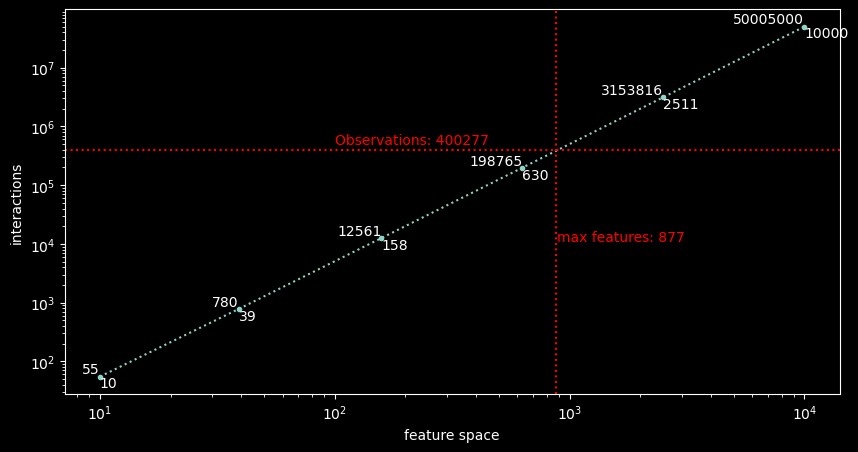

In [ ]:
feature_space = np.logspace(np.log10(10), np.log10(10000), 6, dtype='int64')
interactions = (feature_space * (feature_space + 1) / 2).astype('int64')
max_features = max_interactions(df.shape[0], minus=17)

plt.figure(figsize=(10,5))
plt.loglog(feature_space, interactions, marker='.', linestyle='dotted')
plt.axhline(df.shape[0] , linestyle='dotted', color='red')
plt.text(x=100, y=df.shape[0]*1.1, s='Observations: {}'.format(df.shape[0]), verticalalignment='bottom', color='red')

plt.axvline(max_features , linestyle='dotted', color='red')
plt.text(x=max_features*1.01, y=10**4, s='max features: {}'.format(max_features), verticalalignment='bottom', color='red')
for i,j in zip(feature_space, interactions):
    plt.text(i,j,j, horizontalalignment='right', verticalalignment='bottom')
    plt.text(i,j,i, horizontalalignment='left', verticalalignment='top')
plt.xlabel('feature space')
plt.ylabel('interactions')
plt.show()

## Interaction stress

In [ ]:
union.set_params(text_features__reducer__k = 'all')
tdm = union.fit_transform(df[FEATURES], dummy_labels)
print(f'Memory available before         : {size(psutil.virtual_memory().available)}')
tracemalloc.start()
tracemalloc.reset_peak()
tdm = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True).fit_transform(tdm)
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()
display(tdm)
print(f'Sparsity                       : {1 - tdm.nnz / (tdm.shape[0]*tdm.shape[1])}')
print(f'Sparse matrix memory usage     : {size((tdm.data.nbytes + tdm.indptr.nbytes + tdm.indices.nbytes))}')
print(f'Dense matrix memory equivalence: {size(tdm.shape[0]*tdm.shape[1]*tdm.dtype.itemsize)}')
print(f'Current memory usage           : {size(current)}')
print(f'Peak memory usage              : {size(peak)}')
print(f'Memory available after         : {size(psutil.virtual_memory().available)}')

Memory available before         : 50.5 GiB


<400277x549774164121 sparse matrix of type '<class 'numpy.float64'>'
	with 102189629 stored elements in Compressed Sparse Row format>

Sparsity                       : 0.9999999995356325
Sparse matrix memory usage     : 1.5 GiB
Dense matrix memory equivalence: 1.5 EiB
Current memory usage           : 1.5 GiB
Peak memory usage              : 4.5 GiB
Memory available after         : 49.0 GiB


## Feature scaling

[Feature scaling](https://en.wikipedia.org/wiki/Feature_scaling), also known as data normalization, is a method used to normalize the range of independent variables or features of data.

See [Compare the effect of different scalers on data with outliers](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html)

One can use different **scalers, transformers, and normalizers** to bring the data within a pre-defined range.

Scalers are **linear transformers** (more precisely [affine transformers](https://en.wikipedia.org/wiki/Affine_transformation)) and differ from each other in the way to estimate the parameters used to shift and scale **each feature**:
* `StandardScaler` - standardizes features by removing the mean and scaling to unit variance
```
(x - np.mean(x)) / np.std(x)
```
* `MinMaxScaler` - transforms features by scaling each feature to a given range, default (0, 1)
```
a = 0; b = 1; a + ( (x-min(x)) * (b-a) ) / (max(x) - min(x))
```
* `MaxAbsScaler` - scales each feature by its maximum absolute value to a range (-1, 1)
```
x / np.max(np.abs(x))
```
* `RobustScaler` - scales features using statistics that are robust to outliers

Transformers provides non-linear transformations:
* `QuantileTransformer` - transforms features using quantiles information, where distances between marginal outliers and inliers are shrunk.
* `PowerTransformer` - applies a power transform featurewise to make data more Gaussian-like, where data is mapped to a normal distribution to stabilize variance and minimize skewness.

Unlike the previous transformations, normalization refers to a **per sample** transformation instead of a **per feature** transformation:
* `Normalizer` - normalizes samples individually to unit norm
> Scaling inputs to unit norms is a common operation for text classification or clustering for instance. For instance the dot product of two l2-normalized TF-IDF vectors is the cosine similarity of the vectors and is the base similarity metric for the Vector Space Model commonly used by the Information Retrieval community.

Initial considerations:
* `StandardScaler`, `MinMaxScaler` and `MaxAbsScaler` are very sensitive to the presence of outliers when computing mean and standard deviations therefore cannot guarantee balanced feature scales in the presence of outliers.
* `MinMaxScaler` doesn't support sparse input
* `MaxAbsScaler` values are mapped across 3 ranges depending on whether negative OR positive values are present. If only positive values are present, the range is [0, 1]. If only negative values are present, the range is [-1, 0]. If both negative and positive values are present, the range is [-1, 1]. 
* On positive only data, `MaxAbsScaler` behaves similarly to MinMaxScaler.
* The centering and scaling statistics of the `RobustScaler` are based on percentiles and not influenced by a few number of very large marginal outliers. The resulting range of the 
transformed feature values is larger than for the previous scalers and are approximately similar.
* `PowerTransformer(method='Yeo-Johnson')` can be applied to both negative and positive data. Requires dense input.
* `PowerTransformer(method='Box-Cox')` can only be applied to strictly positive data. Requires dense input.
* `QuantileTransformer(output_distribution='gaussian')`: Note that this non-parametetric transformer introduces saturation artifacts for outliers.
* `QuantileTransformer(output_distribution='uniform')` as `RobustScaler`, are robust to outliers but they will also automatically collapse any outlier by setting them to the a priori defined range boundaries (0 and 1).

Final considerations:

For this problem, we need to scale a sparse matrix without destroying any sparsity, i.e., non-stored zero values should continue being like that.  The scalers/settings supporting that are:
* `StandardScaler(with_mean=False)`
* `MaxAbsScaler`
* `RobustScaler(with_centering=False)`
* `Normalizer(norm='l2')`
* `Normalizer(norm='l1')`

From these, the only scaler not sensible to outliers is the `RobustScaler`

In [ ]:
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, RobustScaler, Normalizer

Although sparse interactions allows virtually any number of resulting features, those features may be limited by the RAM requirements of the next step, scaling.

It's needed to find the $k$ best number of features that after interactions will fit into the scaler memory.

**`Normalizer l1/l2`**

They scale all features without memory impact

In [ ]:
# max_k = 'all'
# print(f'Memory available: {size(psutil.virtual_memory().available)}, k: {max_k}')
# union.set_params(text_features__reducer__k = max_k)
# tdm = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)\
#         .fit_transform(union.fit_transform(df[FEATURES], dummy_labels))
# display(tdm)
# tracemalloc.start()
# tracemalloc.reset_peak()
# t = time()
# tdm2 = Normalizer(norm='l1').fit_transform(tdm, dummy_labels)
# t = time() - t
# current, peak = tracemalloc.get_traced_memory()
# print(f'Normalizer(norm=\'l1\') min:{tdm2.min()} max:{tdm2.max()} current: {size(current)} peak: {size(peak)} {t:.2f}s')
# tracemalloc.reset_peak()
# t = time()
# tdm2 = Normalizer(norm='l2').fit_transform(tdm, dummy_labels)
# t = time() - t
# current, peak = tracemalloc.get_traced_memory()
# print(f'Normalizer(norm=\'l2\') min:{tdm2.min()} max:{tdm2.max()} current: {size(current)} peak: {size(peak)} {t:.2f}s')
# tracemalloc.stop()

```
Last executed at 2022-11-10 07:29:18 in 24.40s

Memory available: 51.9 GiB, k: all

<400277x549774164121 sparse matrix of type '<class 'numpy.float64'>'
	with 102189629 stored elements in Compressed Sparse Row format>

Normalizer(norm='l1') min:-0.23997913905929888 max:0.7697190768164074 current: 1.5 GiB peak: 1.5 GiB 0.47s
Normalizer(norm='l2') min:-0.7808688094376646 max:0.9945657677934204 current: 1.5 GiB peak: 3.1 GiB 0.48s
```

**`MaxAbsScaler`**

It affords the max `k` up to $2^{15}=32,768$ features

In [ ]:
# tracemalloc.start()
# for k in np.logspace(1, 16, 16, base=2).round().astype(int):
#     print(f'k: {k:,}', end=' ')
#     union.set_params(text_features__reducer__k = k)
#     t = time()
#     tdm = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)\
#             .fit_transform(union.fit_transform(df[FEATURES], dummy_labels))
#     print(f'interactions: {tdm.shape[1]:,} time: {time()-t:.2f}s', end= ' ')
#     tracemalloc.reset_peak()
#     t=time()
#     tdm2 = MaxAbsScaler().fit_transform(tdm, dummy_labels)
#     current, peak = tracemalloc.get_traced_memory()
#     print(f'MaxAbsScaler() min:{tdm2.min()} max:{tdm2.max()} current: {size(current)} peak: {size(peak)} time: {time()-t:.2f}s')
# tracemalloc.stop()

```
Last executed at 2022-11-10 07:44:46 in 15m 27.77s

k: 2 interactions: 190 time: 49.74s MaxAbsScaler() current: 447.2 MiB peak: 548.9 MiB time: 0.08s
k: 4 interactions: 231 time: 51.90s MaxAbsScaler() current: 727.7 MiB peak: 910.6 MiB time: 0.08s
k: 8 interactions: 325 time: 51.80s MaxAbsScaler() current: 667.9 MiB peak: 862.7 MiB time: 0.08s
k: 16 interactions: 561 time: 51.84s MaxAbsScaler() current: 995.9 MiB peak: 1.2 GiB time: 0.11s
k: 32 interactions: 1,225 time: 51.52s MaxAbsScaler() current: 1023.5 MiB peak: 1.3 GiB time: 0.20s
k: 64 interactions: 3,321 time: 51.71s MaxAbsScaler() current: 1.5 GiB peak: 2.0 GiB time: 0.32s
k: 128 interactions: 10,585 time: 51.99s MaxAbsScaler() current: 1.9 GiB peak: 2.8 GiB time: 0.71s
k: 256 interactions: 37,401 time: 53.31s MaxAbsScaler() current: 2.8 GiB peak: 4.4 GiB time: 1.34s
k: 512 interactions: 140,185 time: 53.36s MaxAbsScaler() current: 3.1 GiB peak: 5.3 GiB time: 1.87s
k: 1,024 interactions: 542,361 time: 52.66s MaxAbsScaler() current: 3.6 GiB peak: 6.1 GiB time: 2.15s
k: 2,048 interactions: 2,133,145 time: 52.54s MaxAbsScaler() current: 3.5 GiB peak: 6.2 GiB time: 2.33s
k: 4,096 interactions: 8,460,441 time: 52.59s MaxAbsScaler() current: 3.8 GiB peak: 6.7 GiB time: 2.52s
k: 8,192 interactions: 33,697,945 time: 53.77s MaxAbsScaler() current: 3.8 GiB peak: 7.2 GiB time: 2.90s
k: 16,384 interactions: 134,504,601 time: 52.88s MaxAbsScaler() current: 4.0 GiB peak: 9.7 GiB time: 4.37s
k: 32,768 interactions: 537,444,505 time: 53.03s MaxAbsScaler() current: 3.9 GiB peak: 24.0 GiB time: 10.16s
k: 65,536 interactions: 2,148,630,681 time: 52.81s MaxAbsScaler() current: 5.0 GiB peak: 84.6 GiB time: 51.86s
```

**`StandardScaler`**

It affords up to $2^{15}=32768$ features

In [ ]:
# tracemalloc.start()
# for k in np.logspace(1, 16, 16, base=2).round().astype(int):
#     print(f'k: {k:,}', end=' ')
#     union.set_params(text_features__reducer__k = k)
#     t = time()
#     tdm = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)\
#             .fit_transform(union.fit_transform(df[FEATURES], dummy_labels))
#     print(f'interactions: {tdm.shape[1]:,} time: {time()-t:.2f}s', end= ' ')
#     tracemalloc.reset_peak()
#     t=time()
#     tdm2 = StandardScaler(with_mean=False).fit_transform(tdm, dummy_labels)
#     current, peak = tracemalloc.get_traced_memory()
#     print(f'StandardScaler(with_mean=False) min:{tdm2.min()} max:{tdm2.max()} current: {size(current)} peak: {size(peak)} time: {time()-t:.2f}s')
# tracemalloc.stop()

```
Last executed at 2022-11-10 08:04:16 in 19m 29.33s

k: 2 interactions: 190 time: 53.25s StandardScaler(with_mean=False) current: 447.2 MiB peak: 548.9 MiB time: 0.05s
k: 4 interactions: 231 time: 52.36s StandardScaler(with_mean=False) current: 727.7 MiB peak: 910.6 MiB time: 0.05s
k: 8 interactions: 325 time: 51.30s StandardScaler(with_mean=False) current: 667.8 MiB peak: 862.7 MiB time: 0.06s
k: 16 interactions: 561 time: 53.45s StandardScaler(with_mean=False) current: 995.9 MiB peak: 1.2 GiB time: 0.08s
k: 32 interactions: 1,225 time: 52.88s StandardScaler(with_mean=False) current: 1023.5 MiB peak: 1.3 GiB time: 0.11s
k: 64 interactions: 3,321 time: 53.52s StandardScaler(with_mean=False) current: 1.5 GiB peak: 2.0 GiB time: 0.19s
k: 128 interactions: 10,585 time: 52.04s StandardScaler(with_mean=False) current: 1.9 GiB peak: 2.8 GiB time: 0.41s
k: 256 interactions: 37,401 time: 53.93s StandardScaler(with_mean=False) current: 2.8 GiB peak: 4.4 GiB time: 0.72s
k: 512 interactions: 140,185 time: 59.24s StandardScaler(with_mean=False) current: 2.3 GiB peak: 4.6 GiB time: 1.05s
k: 1,024 interactions: 542,361 time: 52.72s StandardScaler(with_mean=False) current: 2.8 GiB peak: 5.3 GiB time: 1.29s
k: 2,048 interactions: 2,133,145 time: 53.19s StandardScaler(with_mean=False) current: 2.8 GiB peak: 5.5 GiB time: 1.43s
k: 4,096 interactions: 8,460,441 time: 53.96s StandardScaler(with_mean=False) current: 3.0 GiB peak: 6.0 GiB time: 1.64s
k: 8,192 interactions: 33,697,945 time: 52.50s StandardScaler(with_mean=False) current: 3.0 GiB peak: 6.6 GiB time: 2.43s
k: 16,384 interactions: 134,504,601 time: 54.26s StandardScaler(with_mean=False) current: 3.2 GiB peak: 11.3 GiB time: 4.68s
k: 32,768 interactions: 537,444,505 time: 53.77s StandardScaler(with_mean=False) current: 3.2 GiB peak: 35.2 GiB time: 13.44s
k: 65,536 interactions: 2,148,630,681 time: 55.06s StandardScaler(with_mean=False) current: 4.2 GiB peak: 131.9 GiB time: 277.44s
```

**Max $k$ best features (i.e., before interactions) supported per scaler in 64GB RAM**

## Pipeline: Logistic Regression

In [ ]:
numeric_impute_missing_discrete_quantile_inclusive_sign_pl

Pipeline(steps=[('numeric_selector',
                 FunctionTransformer(func=<function select_dtype_number at 0x7fd9bea6c5e0>)),
                ('union',
                 FeatureUnion(transformer_list=[('imputer',
                                                 SimpleImputer(add_indicator=True,
                                                               fill_value=0,
                                                               strategy='constant')),
                                                ('discretizer',
                                                 Pipeline(steps=[('imputer',
                                                                  SimpleImputer(fill_value=0,
                                                                                strategy='constant')),
                                                                 ('imputed_discretizer',
                                                                  KBinsDiscretizer(n_bins=[2,
                                                                                           5],
                                                                                   subsample=None))])),
                                                ('sign_indicator',
                                                 FunctionTransformer(func=<function sign_indicator at 0x7fd9beaa0820>,
                                                                     kw_args={'missing_indicator': False}))]))])

In [ ]:
text_pl

Pipeline(steps=[('text_selector',
                 FunctionTransformer(func=<function combine_text_columns at 0x7fd9beaa0280>,
                                     kw_args={'sep': ' ',
                                              'to_drop': ['Function',
                                                          'Object_Type',
                                                          'Operating_Status',
                                                          'Position_Type',
                                                          'Pre_K', 'Reporting',
                                                          'Sharing',
                                                          'Student_Type',
                                                          'Use']})),
                ('vectorizer',
                 HashingVectorizer(alternate_sign=False, norm=None,
                                   token_pattern='(?u)\\b\\w+\\b')),
                ('reducer',
                 SelectKBest(score_func=<function chi2 at 0x7fd92840cf70>))])

In [ ]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.preprocessing import FunctionTransformer, MaxAbsScaler, PolynomialFeatures
from sklearn.metrics import classification_report
from mcr.ml.preprocessing import combine_text_columns
from mcr.ml.metrics import multi_multi_log_loss, log_loss_report, log_loss_report_complete
from mcr.ml import get_dummies_indices, fit_cache
from mcr.ml.model_selection.multilabel import multilabel_train_test_split, multilabel_sample_dataframe
from mcr.nlp import WORD_TOKENIZER_REGEX

baseline_pl = Pipeline([
    ('union', FeatureUnion([
        ('numeric_features', clone(numeric_impute_missing_discrete_quantile_inclusive_sign_pl)),
        ('text_features' , clone(text_pl))
    ], verbose=False, n_jobs=None
    )),
    ('interactor', PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)),
    # ('scaler', StandardScaler(with_mean=False)), # slower, worse and sometimes take indefinite time
    ('scaler', MaxAbsScaler()), # faster and better for the interactions of numeric and discretized features (17) plus (k) token counts
    ('classifier', OneVsRestClassifier(LogisticRegression(random_state=1, solver='liblinear', max_iter=600), n_jobs=14))
], verbose=False #, memory='/data/drivendata/cache'
)
baseline_pl

Pipeline(steps=[('union',
                 FeatureUnion(transformer_list=[('numeric_features',
                                                 Pipeline(steps=[('numeric_selector',
                                                                  FunctionTransformer(func=<function select_dtype_number at 0x7fd9bea6c5e0>)),
                                                                 ('union',
                                                                  FeatureUnion(transformer_list=[('imputer',
                                                                                                  SimpleImputer(add_indicator=True,
                                                                                                                fill_value=0,
                                                                                                                strategy='constant')),
                                                                                                 ('discretizer',
                                                                                                  Pipeline(steps=[('imputer',
                                                                                                                   Simp...
                                                                  HashingVectorizer(alternate_sign=False,
                                                                                    norm=None,
                                                                                    token_pattern='(?u)\\b\\w+\\b')),
                                                                 ('reducer',
                                                                  SelectKBest(score_func=<function chi2 at 0x7fd92840cf70>))]))])),
                ('interactor',
                 PolynomialFeatures(include_bias=False, interaction_only=True)),
                ('scaler', MaxAbsScaler()),
                ('classifier',
                 OneVsRestClassifier(estimator=LogisticRegression(max_iter=600,
                                                                  random_state=1,
                                                                  solver='liblinear'),
                                     n_jobs=14))])

### 10/90 k265 0.1262/0.4737

In [104]:
X_train, X_test, y_train, y_test = multilabel_train_test_split(df[FEATURES], dummy_labels, size=0.9, min_count=0, seed=1)
train_sample_size = X_train.shape[0]
max_k = max_interactions(train_sample_size, minus=17)
C = 1
print(f'Training: {train_sample_size} (min_count: {y_train.sum().min()}), testing: {X_test.shape[0]} (min_count: {y_test.sum().min()}) k: {max_k} C:{C}')

Training: 40028 (min_count: 4), testing: 360249 (min_count: 25) k: 265 C:1


In [108]:
pl=clone(baseline_pl)
pl.set_params(union__text_features__reducer__k = max_k)
pl.set_params(classifier__estimator__C = C)

modelname = f'{train_sample_size}-k{max_k}-logistic-regression-C{C}'
modelname

'40028-k265-logistic-regression-C1'

In [109]:
pl = fit_cache(pl, X_train, y_train, '/data/drivendata/models/2022/', modelname)
log_loss_report(simple_pl, X_train, y_train, LABELS, cci, part="Training", summary=True)
log_loss_report(simple_pl, X_test, y_test, LABELS, cci, part="Testing", summary=False)

Loading cache 40028-k265-logistic-regression-C1 ... done: 0.0 minutes
Training accuracy         : 0.9024183071849705
Training log loss         : 0.07263857130560958
Testing accuracy         : 0.830489467007542
Testing log loss         : 0.12624978520224692


```
Last executed at 2022-11-10 09:41:59 in 2m 4.73s

Fitting started on 2022-11-10T09:39
Done: 1.4 minutes
Saving cache 40028-k265-logistic-regression-C1 ... Done: 0.0 minutes
Training accuracy         : 0.9024183071849705
Training log loss         : 0.07263857130560958
Testing accuracy         : 0.830489467007542
Testing log loss         : 0.12624978520224692

Drivendata: 0.4737
```

In [ ]:
to_csv_to_zip('/data/drivendata/predictions/2022/', modelname, pl.predict_proba(holdout[FEATURES]), holdout.index, dummy_labels.columns)

### 20/80 k382 0.0898/0.4470

In [103]:
X_train, X_test, y_train, y_test = multilabel_train_test_split(df[FEATURES], dummy_labels, size=0.8, min_count=0, seed=1)
train_sample_size = X_train.shape[0]
max_k = max_interactions(train_sample_size, minus=17)
C=1
print(f'Training: {train_sample_size} (min_count: {y_train.sum().min()}), testing: {X_test.shape[0]} (min_count: {y_test.sum().min()}) k: {max_k} C:{C}')

Training: 80056 (min_count: 6), testing: 320221 (min_count: 23) k: 382 C:1


In [ ]:
pl=clone(baseline_pl)
pl.set_params(union__text_features__reducer__k = max_k)
pl.set_params(classifier__estimator__C = C)

modelname = f'{train_sample_size}-k{max_k}-logistic-regression-C{C}'
modelname

In [ ]:
pl = fit_cache(pl, X_train, y_train, '/data/drivendata/models/2022/', modelname)
log_loss_report(simple_pl, X_train, y_train, LABELS, cci, part="Training", summary=True)
log_loss_report(simple_pl, X_test, y_test, LABELS, cci, part="Testing", summary=False)

```
Last executed at 2022-11-10 09:46:21 in 4m 10.36s

Fitting started on 2022-11-10T09:42
Done: 3.4 minutes
Saving cache 80056-k382-logistic-regression-C1 ... Done: 0.0 minutes
Training accuracy         : 0.9318851803737384
Training log loss         : 0.05403061326638644
Testing accuracy         : 0.8795175831691239
Testing log loss         : 0.08977835724288001

Drivendata: 0.4470
```

In [ ]:
to_csv_to_zip('/data/drivendata/predictions/2022/', modelname, pl.predict_proba(holdout[FEATURES]), holdout.index, dummy_labels.columns)

### 30/70 k472 0.0764/0.4764

In [ ]:
X_train, X_test, y_train, y_test = multilabel_train_test_split(df[FEATURES], dummy_labels, size=0.7, min_count=0, seed=1)
train_sample_size = X_train.shape[0]
max_k = max_interactions(train_sample_size, minus=17)
C=1
print(f'Training: {train_sample_size} (min_count: {y_train.sum().min()}), testing: {X_test.shape[0]} (min_count: {y_test.sum().min()}) k: {max_k} C:{C}')

In [ ]:
pl=clone(baseline_pl)
pl.set_params(union__text_features__reducer__k = max_k)
pl.set_params(classifier__estimator__C = C)

modelname = f'{train_sample_size}-k{max_k}-logistic-regression-C{C}'
modelname

In [ ]:
pl = fit_cache(pl, X_train, y_train, '/data/drivendata/models/2022/', modelname)
log_loss_report(simple_pl, X_train, y_train, LABELS, cci, part="Training", summary=True)
log_loss_report(simple_pl, X_test, y_test, LABELS, cci, part="Testing", summary=False)

```
Last executed at 2022-11-10 09:53:13 in 6m 41.16s

Fitting started on 2022-11-10T09:46
Done: 5.9 minutes
Saving cache 120084-k472-logistic-regression-C1 ... Done: 0.0 minutes
Training accuracy         : 0.9399753505879218
Training log loss         : 0.04731941844521549
Testing accuracy         : 0.897674103207432
Testing log loss         : 0.07637298706802798

Drivendata: 0.4764
```

In [ ]:
to_csv_to_zip('/data/drivendata/predictions/2022/', modelname, pl.predict_proba(holdout[FEATURES]), holdout.index, dummy_labels.columns)

### 40/60 k548 0.0683/0.4688

In [ ]:
X_train, X_test, y_train, y_test = multilabel_train_test_split(df[FEATURES], dummy_labels, size=0.6, min_count=0, seed=1)
train_sample_size = X_train.shape[0]
max_k = max_interactions(train_sample_size, minus=17)
C=1
print(f'Training: {train_sample_size} (min_count: {y_train.sum().min()}), testing: {X_test.shape[0]} (min_count: {y_test.sum().min()}) k: {max_k} C:{C}')

In [ ]:
pl=clone(baseline_pl)
pl.set_params(union__text_features__reducer__k = max_k)
pl.set_params(classifier__estimator__C = C)

modelname = f'{train_sample_size}-k{max_k}-logistic-regression-C{C}'
modelname

In [ ]:
pl = fit_cache(pl, X_train, y_train, '/data/drivendata/models/2022/', modelname)
log_loss_report(simple_pl, X_train, y_train, LABELS, cci, part="Training", summary=True)
log_loss_report(simple_pl, X_test, y_test, LABELS, cci, part="Testing", summary=False)

```
Last executed at 2022-11-10 10:03:40 in 10m 15.48s

Fitting started on 2022-11-10T09:53
Done: 9.5 minutes
Saving cache 160111-k548-logistic-regression-C1 ... Done: 0.0 minutes
Training accuracy         : 0.9451630431388225
Training log loss         : 0.04367593654913032
Testing accuracy         : 0.9083800371409775
Testing log loss         : 0.06830101531619642

Drivendata:0.4688
```

In [ ]:
to_csv_to_zip('/data/drivendata/predictions/2022/', modelname, pl.predict_proba(holdout[FEATURES]), holdout.index, dummy_labels.columns)

### 50/50 k615 0.0630/0.4389

In [ ]:
X_train, X_test, y_train, y_test = multilabel_train_test_split(df[FEATURES], dummy_labels, size=0.5, min_count=0, seed=1)
train_sample_size = X_train.shape[0]
max_k = max_interactions(train_sample_size, minus=17)
C=1
print(f'Training: {train_sample_size} (min_count: {y_train.sum().min()}), testing: {X_test.shape[0]} (min_count: {y_test.sum().min()}) k: {max_k} C:{C}')

In [ ]:
pl=clone(baseline_pl)
pl.set_params(union__text_features__reducer__k = max_k)
pl.set_params(classifier__estimator__C = C)

modelname = f'{train_sample_size}-k{max_k}-logistic-regression-C{C}'
modelname

In [ ]:
pl = fit_cache(pl, X_train, y_train, '/data/drivendata/models/2022/', modelname)
log_loss_report(simple_pl, X_train, y_train, LABELS, cci, part="Training", summary=True)
log_loss_report(simple_pl, X_test, y_test, LABELS, cci, part="Testing", summary=False)

```
Last executed at 2022-11-10 10:17:57 in 14m 6.03s

Fitting started on 2022-11-10T10:03
Done: 13.3 minutes
Saving cache 200139-k615-logistic-regression-C1 ... Done: 0.0 minutes
Training accuracy         : 0.948166024612894
Training log loss         : 0.04175134437712791
Testing accuracy         : 0.9157781131019597
Testing log loss         : 0.0630793439083571

Drivendata: 0.4389
```

In [ ]:
to_csv_to_zip('/data/drivendata/predictions/2022/', modelname, pl.predict_proba(holdout[FEATURES]), holdout.index, dummy_labels.columns)

### 60/40 k657 0.0588/0.4297

In [ ]:
X_train, X_test, y_train, y_test = multilabel_train_test_split(df[FEATURES], dummy_labels, size=0.4, min_count=0, seed=1)
train_sample_size = X_train.shape[0]
max_k = max_interactions(train_sample_size, minus=17)
C=1
print(f'Training: {train_sample_size} (min_count: {y_train.sum().min()}), testing: {X_test.shape[0]} (min_count: {y_test.sum().min()}) k: {max_k} C:{C}')

In [ ]:
pl=clone(baseline_pl)
pl.set_params(union__text_features__reducer__k = max_k)
pl.set_params(classifier__estimator__C = C)

modelname = f'{train_sample_size}-k{max_k}-logistic-regression-C{C}'
modelname

In [ ]:
pl = fit_cache(pl, X_train, y_train, '/data/drivendata/models/2022/', modelname)
log_loss_report(simple_pl, X_train, y_train, LABELS, cci, part="Training", summary=True)
log_loss_report(simple_pl, X_test, y_test, LABELS, cci, part="Testing", summary=False)

```
Last executed at 2022-11-10 10:36:34 in 18m 25.43s

Fitting started on 2022-11-10T10:18
Done: 17.6 minutes
Saving cache 240167-k675-logistic-regression-C1 ... Done: 0.0 minutes
Training accuracy         : 0.9518793173083729
Training log loss         : 0.03963925520595123
Testing accuracy         : 0.9232215351945537
Testing log loss         : 0.05883326743947159

Drivendata: 0.4297
```

In [ ]:
to_csv_to_zip('/data/drivendata/predictions/2022/', modelname, pl.predict_proba(holdout[FEATURES]), holdout.index, dummy_labels.columns)

Your score for this submission is: 0.4930

### 70/30 k731 0.0565/0.4130

In [110]:
X_train, X_test, y_train, y_test = multilabel_train_test_split(df[FEATURES], dummy_labels, size=0.3, min_count=0, seed=1)
train_sample_size = X_train.shape[0]
max_k = max_interactions(train_sample_size, minus=17)
C = 1
print(f'Training: {train_sample_size} (min_count: {y_train.sum().min()}), testing: {X_test.shape[0]} (min_count: {y_test.sum().min()}) k: {max_k} C:{C}')

Training: 280194 (min_count: 22), testing: 120083 (min_count: 7) k: 731 C:1


In [111]:
pl=clone(baseline_pl)
pl.set_params(union__text_features__reducer__k = max_k)
pl.set_params(classifier__estimator__C = C)

modelname = f'{train_sample_size}-k{max_k}-logistic-regression-C{C}'
modelname

'280194-k731-logistic-regression-C1'

In [112]:
pl = fit_cache(pl, X_train, y_train, '/data/drivendata/models/2022/', modelname)
log_loss_report(simple_pl, X_train, y_train, LABELS, cci, part="Training", summary=True)
log_loss_report(simple_pl, X_test, y_test, LABELS, cci, part="Testing", summary=False)

Loading cache 280194-k731-logistic-regression-C1 ... done: 0.0 minutes
Training accuracy         : 0.9519404412656944
Training log loss         : 0.03884366423945736
Testing accuracy         : 0.9263759233197039
Testing log loss         : 0.056570027047699215


```
Last executed at 2022-11-10 11:00:02 in 23m 16.59s

Fitting started on 2022-11-10T10:36
Done: 22.5 minutes
Saving cache 280194-k731-logistic-regression-C1 ... Done: 0.0 minutes
Training accuracy         : 0.9519404412656944
Training log loss         : 0.03884366423945736
Testing accuracy         : 0.9263759233197039
Testing log loss         : 0.056570027047699215

Drivendata: 0.4130
```

In [103]:
to_csv_to_zip('/data/drivendata/predictions/2022/', modelname, pl.predict_proba(holdout[FEATURES]), holdout.index, dummy_labels.columns)

Saving CSV...done in 0.1 minute(s).
Zipping...done in 0.1 minute(s).


### 80/20 k782 0.0546/0.4132

In [ ]:
X_train, X_test, y_train, y_test = multilabel_train_test_split(df[FEATURES], dummy_labels, size=0.2, min_count=0, seed=1)
train_sample_size = X_train.shape[0]
max_k = max_interactions(train_sample_size, minus=17)
C=1
print(f'Training: {train_sample_size} (min_count: {y_train.sum().min()}), testing: {X_test.shape[0]} (min_count: {y_test.sum().min()}) k: {max_k} C:{C}')

In [ ]:
pl=clone(baseline_pl)
pl.set_params(union__text_features__reducer__k = max_k)
pl.set_params(classifier__estimator__C = C)

modelname = f'{train_sample_size}-k{max_k}-logistic-regression-C{C}'
modelname

In [ ]:
pl = fit_cache(pl, X_train, y_train, '/data/drivendata/models/2022/', modelname)
log_loss_report(simple_pl, X_train, y_train, LABELS, cci, part="Training", summary=True)
log_loss_report(simple_pl, X_test, y_test, LABELS, cci, part="Testing", summary=False)

```
Last executed at 2022-11-10 11:29:00 in 28m 45.54s

Fitting started on 2022-11-10T11:00
Done: 27.9 minutes
Saving cache 320222-k782-logistic-regression-C1 ... Done: 0.0 minutes
Training accuracy         : 0.9531824796547396
Training log loss         : 0.038417524694598706
Testing accuracy         : 0.9287364936606083
Testing log loss         : 0.05468098904440533

Drivendata: 0.4132
```

In [ ]:
to_csv_to_zip('/data/drivendata/predictions/2022/', modelname, pl.predict_proba(holdout[FEATURES]), holdout.index, dummy_labels.columns)

### 90/10 k831 0.0522/0.4204

In [ ]:
X_train, X_test, y_train, y_test = multilabel_train_test_split(df[FEATURES], dummy_labels, size=0.1, min_count=0, seed=1)
train_sample_size = X_train.shape[0]
max_k = max_interactions(train_sample_size, minus=17)
C=1
print(f'Training: {train_sample_size} (min_count: {y_train.sum().min()}), testing: {X_test.shape[0]} (min_count: {y_test.sum().min()}) k: {max_k} C:{C}')

In [ ]:
pl=clone(baseline_pl)
pl.set_params(union__text_features__reducer__k = max_k)
pl.set_params(classifier__estimator__C = C)

modelname = f'{train_sample_size}-k{max_k}-logistic-regression-C{C}'
modelname

In [ ]:
pl = fit_cache(pl, X_train, y_train, '/data/drivendata/models/2022/', modelname)
log_loss_report(simple_pl, X_train, y_train, LABELS, cci, part="Training", summary=True)
log_loss_report(simple_pl, X_test, y_test, LABELS, cci, part="Testing", summary=False)

```
Last executed at 2022-11-10 12:03:09 in 33m 58.03s

Fitting started on 2022-11-10T11:29
Done: 33.1 minutes
Saving cache 360250-k831-logistic-regression-C1 ... Done: 0.0 minutes
Training accuracy         : 0.9532602359472588
Training log loss         : 0.03816836885908283
Testing accuracy         : 0.930371998900742
Testing log loss         : 0.05221077452168072

Drivendata: 0.4204
```

In [ ]:
to_csv_to_zip('/data/drivendata/predictions/2022/', modelname, pl.predict_proba(holdout[FEATURES]), holdout.index, dummy_labels.columns)

### 100% k877 0.0377/0.4255

In [ ]:
train_sample_size = df.shape[0]
max_k = max_interactions(train_sample_size, minus=17)
C=1
print(f'Training: {train_sample_size} (min_count: {dummy_labels.sum().min()}) k: {max_k} C:{C}')

In [ ]:
pl=clone(baseline_pl)
pl.set_params(union__text_features__reducer__k = max_k)
pl.set_params(classifier__estimator__C = C)
modelname = f'{train_sample_size}-k{max_k}-logistic-regression-C{C}'
modelname

In [ ]:
pl = fit_cache(pl, df[FEATURES], dummy_labels, '/data/drivendata/models/2022/', modelname)
log_loss_report(pl, df[FEATURES], dummy_labels, LABELS, cci, part='Training', summary=True)

```
Last executed at 2022-11-10 12:44:09 in 40m 48.21s

Fitting started on 2022-11-10T12:03
Done: 39.9 minutes
Saving cache 400277-k877-logistic-regression-C1 ... Done: 0.0 minutes
Training accuracy         : 0.9524004626795943
Training log loss         : 0.037792284655279076

Drivendata: 0.4255
```

In [ ]:
to_csv_to_zip('/data/drivendata/predictions/2022/', modelname, pl.predict_proba(holdout[FEATURES]), holdout.index, dummy_labels.columns)

### Learning curve

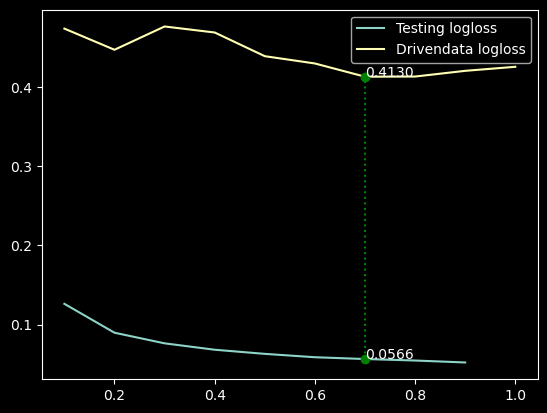

In [52]:
plt.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
         [0.12624978520224692, 0.08977835724288001, 0.07637298706802798, 0.06830101531619642, 0.0630793439083571,
          0.05883326743947159, 0.056570027047699215, 0.05468098904440533, 0.05221077452168072],
        label='Testing logloss')

plt.plot(0.7,0.056570027047699215, 'og')
plt.text(0.7,0.056570027047699215, f'0.0566')

plt.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
         [0.4737, 0.4470, 0.4764, 0.4688, 0.4389, 0.4297, 0.4130, 0.4132, 0.4204, 0.4255],
        label='Drivendata logloss')

plt.plot(0.7, 0.4130, 'og')
plt.text(0.7, 0.4130, '0.4130')
plt.plot([0.7, 0.7], [0.056570027047699215, 0.4130], ':.g')

plt.legend()

logloss as function of k

In [ ]:
plt.plot([265, 382, 472, 548, 615, 657, 731, 782, 831, 877],
[0.4737, 0.4470, 0.4764, 0.4688, 0.4389, 0.4297, 0.4130, 0.4132, 0.4204, 0.4255])

## Pipeline: Random Forest 

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Edit model step in pipeline
pl=clone(baseline_pl)
pl.steps[-1] = ('classifier',
               OneVsRestClassifier(
                   RandomForestClassifier(n_estimators=100,  # default 100
                                          criterion="gini", # default "gini"
                                          max_depth=None,  # default None (leaves are pure or < min_samples_split)
                                          min_samples_split=2,  # default 2
                                          min_samples_leaf=1,  # default 1
                                          max_features='sqrt',  # default 'auto' (sqrt(n_features))
                                          bootstrap=True,  # default=True
                                          n_jobs=None,  # default None
                                          random_state=1, #default None
                                          ), n_jobs=14))

# n_estimators=1, n_jobs=14, max_depth=2, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 197s
# n_estimators=1, n_jobs=14, max_depth=3, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 215s
# n_estimators=1, n_jobs=14, max_depth=4, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 201s
# n_estimators=10, n_jobs=14, max_depth=4, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 274s
# n_estimators=1, n_jobs=14, max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 455s
# * n_estimators=10, n_jobs=14, max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 1720s
# n_estimators=10, n_jobs=14, max_depth=2, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 289s
# n_estimators=10, n_jobs=14, max_depth=3, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 300s
# n_estimators=10, n_jobs=14, max_depth=10, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 362s
# n_estimators=10, n_jobs=14, max_depth=50, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 22m
# n_estimators=100, n_jobs=14, max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): ~4h

### 80/20 split

In [ ]:
X_train, X_test, y_train, y_test = multilabel_train_test_split(df[FEATURES], dummy_labels, size=0.2, min_count=0, seed=1)
train_sample_size = X_train.shape[0]
max_k = max_interactions(train_sample_size, minus=17)
n_estimators = 10
max_depth = 10
print(f'Training: {train_sample_size}, testing: {X_test.shape[0]} k: {max_k} n_estimators: {n_estimators} max_depth: {max_depth}')

In [ ]:
pl.set_params(union__text_features__reducer__k = max_k)
pl.set_params(classifier__estimator__n_estimators = n_estimators)
pl.set_params(classifier__estimator__max_depth = max_depth)
modelname = f'{train_sample_size}-k{max_k}-random-forest-estimators{n_estimators}-depth{max_depth}'
modelname

In [ ]:
pl = fit_cache(pl, X_train, y_train, '/data/drivendata/models/2022/', modelname)
log_loss_report_complete(pl, X_train, y_train, X_test, y_test, LABELS, get_dummies_indices(df[LABELS]), summary=True)

```
Fitting started on 2022-11-10T12:44
Done: 1.8 minutes
Saving cache 320222-k782-random-forest-estimators10-depth10 ... Done: 0.0 minutes
Training accuracy         : 0.29574482702625055
Training log loss         : 0.613617099411062
Testing accuracy         : 0.2969458497283118
Testing log loss         : 0.6168207377424058

Drivendata?


Last executed at 2022-11-02 00:01:16 in 8m 54.77s

Training accuracy         : 0.2632954637720082
Training log loss         : 0.6442667280879915
Testing accuracy         : 0.26363125351320965
Testing log loss         : 0.6473051044566009

Drivendata score: 0.8877

```

In [ ]:
to_csv_to_zip('/data/drivendata/predictions/2022/', modelname, pl.predict_proba(holdout[FEATURES]), holdout.index, dummy_labels.columns)

### 100%

In [ ]:
train_sample_size = df.shape[0]
max_k = max_interactions(train_sample_size, minus=17)
n_estimators = 10
max_depth = 10
print(f'Training: {train_sample_size} k: {max_k} n_estimators: {n_estimators} max_depth: {max_depth}')

In [ ]:
pl.set_params(union__text_features__reducer__k = max_k)
pl.set_params(classifier__estimator__n_estimators = n_estimators)
pl.set_params(classifier__estimator__max_depth = max_depth)
modelname = f'{train_sample_size}-k{max_k}-random-forest-estimators{n_estimators}-depth{max_depth}'
modelname

In [ ]:
pl = fit_cache(pl, df[FEATURES], dummy_labels, '/data/drivendata/models/2022/', modelname)
log_loss_report(pl, df[FEATURES], dummy_labels, LABELS, get_dummies_indices(df[LABELS]), summary=True)

```
Last executed at 2022-11-10 13:05:59 in 11m 0.56s

Fitting started on 2022-11-10T12:54
Done: 2.3 minutes
Saving cache 400277-k877-random-forest-estimators10-depth10 ... Done: 0.0 minutes
Training accuracy         : 0.2990928781818591
Training log loss         : 0.607716925785152

Drivendata?

Last executed at 2022-11-02 00:10:58 in 9m 20.77s

Training accuracy         : 0.2381201018294831
Training log loss         : 0.653389141704923

Drivendata: 0.8728
```

In [ ]:
to_csv_to_zip('/data/drivendata/predictions/2022/', modelname, pl.predict_proba(holdout[FEATURES]), holdout.index, dummy_labels.columns)

# Learning from the Experts

* NLP tricks: Range of n-grams, punctuation tokenization (regular expression)
* Stats trick: Interaction terms
* Computation trick: Hashing vectorizer
* What class of model to use?
    * Deep Convolutional Neural Network?
    * Extreme Gradient Boosted Trees
    * An ensemble of local-expert elasticnet regressions?
* **No, the winning model was the Logistic Regression and not a cutting edge algorithm**
    * Carefully create features
    * Easily implemented tricks

> Rather than reaching advanced alghoritms hard to interpret and expensive to train it's always worth it to see how far you can get with simpler methods.

# Can you do better?

Ways to improve:

* NLP: Stemming, stop-word removal
* Model: RandomForest, k-NN, Naïve Bayes
* Numeric preprocessing: Imputation strategies
* Optimization: Grid search over pipeline objects
* Experiment new scikit-learn tech docs